In [5]:
import os
import pandas as pd
import re
from tqdm import tqdm
from IPython.display import Image, display
from datetime import date, timedelta
import numpy as np


def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'generated/data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')


def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f['total_space'] = node_f.total_space/node_f.total_space.max()
    node_f['monthly_fee'] = node_f.monthly_fee/node_f.monthly_fee.max()
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

from matplotlib.pyplot import *

def compare_plot(train, name, save_path, n=3):
    fig, ax = subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    key=9
    for w in range(1,n):
        seqs_normal[w:w+96][key].plot(ax=ax) 
    for w in range(1,n):
        generated_seq = train.generate()
        generated_seq.plot(ax=ax)
    ax.legend(['real'+str(w) for w in range(1,n)]+['gen'+str(w) for w in range(1,n)]);
    fig.savefig(save_path+"/compare_" + name + ".png")

In [ ]:
basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

from graph_utils import build_graph

target_park = '电影大厦'
target_area, adj, target_map, nks, kns = build_graph(basic_info_df, target_park)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]
seqs_raw = build_area_seqs(target_area, start='2016-10-01', end='2016-11-01')
seqs_normal = seqs_raw/seqs_raw.max()
node_f = get_nodes_features(target_area)

In [2]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv

l2_reg = 5e-4 / 2  # L2 regularization rate


class Generator(Model, ABC):

    def __init__(self, adj, nodes_features, base=8, dropout=0.5):
        super(Generator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(dropout)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(4*base,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(1*base,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(4*base, activation='relu')
        self.dense_2 = Dense(8*base, activation='relu')
        self.gru = GRU(16*base, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*32
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)  # 1*96*32
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*32
        return self.final_dense(ro)  # 96*1


class Discriminator(Model, ABC):

    def __init__(self, adj, nodes_features, base=8, dropout=0.5, alpha=0.2):
        super(Discriminator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.leaky_relu = LeakyReLU(alpha=alpha)
        self.dropout = Dropout(dropout)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(4*base,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(1*base,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(4*base)
        self.dense_2 = Dense(8*base)
        self.gru = GRU(16*base, return_sequences=True)
        self.final_dense = Dense(1, activation='sigmoid')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # 11*F
        g = tf.convert_to_tensor(self.adj)  # 11*11
        s = tf.convert_to_tensor(seq)  # 96*11

        c = self.graph_conv_1([f, g])  # 11*11
        c = self.graph_conv_2([c, g])  # 11*11
        s = tf.matmul(s, c)  # 96*11

        fc = self.dense_1(s)  # 96*32
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*64
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*64
        return self.final_dense(ro)  # 96*1


In [3]:
import os
from tensorflow.keras.optimizers import Adam
from spektral.utils import normalized_laplacian
# from model import Generator, Discriminator
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 96
save_interval = 5

class Train:
    def __init__(self, seqs, adj, nodes_features, epochs=1000,
                 lr = 1e-3, adam_beta_1 = 0.5, key=9, base=8, dropout=0.5, alpha=0.2):
        self.epochs = epochs
        self.seqs = seqs.astype('float32')

        self.gen_optimizer = Adam(lr, adam_beta_1)
        self.desc_optimizer = Adam(lr, adam_beta_1)

        self.adj = normalized_laplacian(adj.astype('float32'))
        self.nodes_features = nodes_features.astype('float32')
        self.generator = Generator(self.adj, self.nodes_features, base, dropout)
        self.discriminator = Discriminator(self.adj, self.nodes_features, base, dropout, alpha)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.key = key

    def __call__(self, epochs=None ,save_path='generated/'):
        save_path += str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if epochs is None:
            epochs = self.epochs
            
        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size)  # 2976/96=31

        time_consumed_total = 0.
        for epoch in range(1, epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0

            for week in range(0, total_batch):
                current_seqs = self.seqs[week*batch_size:week*batch_size + batch_size]
                seqs_noised = current_seqs.copy()
                max_s = current_seqs[self.key].max()
                seqs_noised[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0,
                                                         size=(current_seqs.shape[0])).astype('float32')
                gen_loss, disc_loss = self.train_step(current_seqs, seqs_noised)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            epochs_last = epochs - epoch
            estimate_time_last = epochs_last * time_consumed_agv
            print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
                  .format(epoch, round(time.time() - start, 2),
                          epochs, round(time_consumed_total, 2),
                          round(float(total_gen_loss / total_batch), 5),
                          round(float(total_disc_loss / total_batch), 5),
                          round(estimate_time_last, 2)))

            if epoch % save_interval == 0:
                fig = self.generate().plot().get_figure()
                fig.savefig(save_path + "/gen_" + str(epoch) + ".png")

    @tf.function
    def train_step(self, seqs, seqs_noised):
        with tf.GradientTape(persistent=True) as tape:
            real_output = self.discriminator(seqs)  # 评价高
            generated = self.generator(seqs_noised)
            left = tf.slice(seqs, [0, 0], [batch_size, self.key])
            right = tf.slice(seqs, [0, self.key + 1], [batch_size, -1])
            combined = tf.concat([left, generated, right], 1)
            generated_output = self.discriminator(combined)  # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d

    def generate(self):
        import random as random
        week = 1 # random.randint(0,31)
        seqs_replace = self.seqs[week*batch_size:week*batch_size + batch_size].copy()
        max_s = seqs_replace[self.key].max()
        seqs_replace[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)

        from sklearn import preprocessing
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(gen_data.numpy())
        return pd.DataFrame(x_scaled) # [self.key]

    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        """
        ...
        """
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        """
        ...
        """
        return loss_object(tf.ones_like(fake_output), fake_output)

  0%|          | 0/2 [00:00<?, ?it/s]

0.0005_0.5_5_0.5_0.3
epoch 1(3.26)/500(3.26) - gen_loss = 0.51088, disc_loss = 1.42897, estimated to finish: 1628.82
epoch 2(0.68)/500(3.94) - gen_loss = 0.64144, disc_loss = 1.38733, estimated to finish: 981.85
epoch 3(0.68)/500(4.62) - gen_loss = 0.67532, disc_loss = 1.38915, estimated to finish: 765.7
epoch 4(0.67)/500(5.29) - gen_loss = 0.68755, disc_loss = 1.38847, estimated to finish: 656.17
epoch 5(0.68)/500(5.97) - gen_loss = 0.68863, disc_loss = 1.38713, estimated to finish: 591.13
epoch 6(0.69)/500(6.66) - gen_loss = 0.6891, disc_loss = 1.38672, estimated to finish: 548.57
epoch 7(0.69)/500(7.35) - gen_loss = 0.68963, disc_loss = 1.38585, estimated to finish: 517.95
epoch 8(0.69)/500(8.04) - gen_loss = 0.68933, disc_loss = 1.38582, estimated to finish: 494.44
epoch 9(0.7)/500(8.74) - gen_loss = 0.68912, disc_loss = 1.38484, estimated to finish: 476.72
epoch 10(0.69)/500(9.43) - gen_loss = 0.67133, disc_loss = 1.38027, estimated to finish: 462.22
epoch 11(0.68)/500(10.11) - ge

epoch 86(0.75)/500(63.31) - gen_loss = 0.69279, disc_loss = 1.38629, estimated to finish: 304.79
epoch 87(0.69)/500(64.0) - gen_loss = 0.69271, disc_loss = 1.38645, estimated to finish: 303.83
epoch 88(0.78)/500(64.78) - gen_loss = 0.69279, disc_loss = 1.38637, estimated to finish: 303.3
epoch 89(0.74)/500(65.53) - gen_loss = 0.69287, disc_loss = 1.38622, estimated to finish: 302.6
epoch 90(0.77)/500(66.3) - gen_loss = 0.69283, disc_loss = 1.38631, estimated to finish: 302.04
epoch 91(0.75)/500(67.05) - gen_loss = 0.69281, disc_loss = 1.38624, estimated to finish: 301.37
epoch 92(0.76)/500(67.82) - gen_loss = 0.69276, disc_loss = 1.3863, estimated to finish: 300.75
epoch 93(0.68)/500(68.5) - gen_loss = 0.69279, disc_loss = 1.38628, estimated to finish: 299.78
epoch 94(0.68)/500(69.18) - gen_loss = 0.6927, disc_loss = 1.38647, estimated to finish: 298.81
epoch 95(0.77)/500(69.96) - gen_loss = 0.69278, disc_loss = 1.38631, estimated to finish: 298.24
epoch 96(0.77)/500(70.72) - gen_loss 

/home/mark/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch 106(0.72)/500(77.84) - gen_loss = 0.69285, disc_loss = 1.38624, estimated to finish: 289.31
epoch 107(0.68)/500(78.51) - gen_loss = 0.69272, disc_loss = 1.38648, estimated to finish: 288.37
epoch 108(0.67)/500(79.18) - gen_loss = 0.69288, disc_loss = 1.38625, estimated to finish: 287.41
epoch 109(0.69)/500(79.87) - gen_loss = 0.69272, disc_loss = 1.38641, estimated to finish: 286.52
epoch 110(0.68)/500(80.56) - gen_loss = 0.69278, disc_loss = 1.38639, estimated to finish: 285.61
epoch 111(0.71)/500(81.27) - gen_loss = 0.69294, disc_loss = 1.38609, estimated to finish: 284.8
epoch 112(0.68)/500(81.95) - gen_loss = 0.69285, disc_loss = 1.38629, estimated to finish: 283.9
epoch 113(0.69)/500(82.64) - gen_loss = 0.69288, disc_loss = 1.38627, estimated to finish: 283.03
epoch 114(0.68)/500(83.32) - gen_loss = 0.69285, disc_loss = 1.38616, estimated to finish: 282.13
epoch 115(0.69)/500(84.01) - gen_loss = 0.69282, disc_loss = 1.38641, estimated to finish: 281.26
epoch 116(0.71)/500(84

epoch 190(0.7)/500(135.5) - gen_loss = 0.69308, disc_loss = 1.38633, estimated to finish: 221.08
epoch 191(0.68)/500(136.18) - gen_loss = 0.69307, disc_loss = 1.38633, estimated to finish: 220.32
epoch 192(0.68)/500(136.86) - gen_loss = 0.69312, disc_loss = 1.38629, estimated to finish: 219.55
epoch 193(0.68)/500(137.54) - gen_loss = 0.69308, disc_loss = 1.38629, estimated to finish: 218.78
epoch 194(0.68)/500(138.22) - gen_loss = 0.6931, disc_loss = 1.38626, estimated to finish: 218.01
epoch 195(0.7)/500(138.91) - gen_loss = 0.69309, disc_loss = 1.3863, estimated to finish: 217.28
epoch 196(0.69)/500(139.61) - gen_loss = 0.69311, disc_loss = 1.3863, estimated to finish: 216.53
epoch 197(0.68)/500(140.29) - gen_loss = 0.69311, disc_loss = 1.38627, estimated to finish: 215.78
epoch 198(0.68)/500(140.97) - gen_loss = 0.69312, disc_loss = 1.38625, estimated to finish: 215.02
epoch 199(0.68)/500(141.66) - gen_loss = 0.69311, disc_loss = 1.38627, estimated to finish: 214.26
epoch 200(0.69)/

epoch 274(0.7)/500(195.34) - gen_loss = 0.6931, disc_loss = 1.38629, estimated to finish: 161.12
epoch 275(0.7)/500(196.04) - gen_loss = 0.69311, disc_loss = 1.38631, estimated to finish: 160.4
epoch 276(0.76)/500(196.81) - gen_loss = 0.69311, disc_loss = 1.38627, estimated to finish: 159.73
epoch 277(0.74)/500(197.55) - gen_loss = 0.69311, disc_loss = 1.38626, estimated to finish: 159.04
epoch 278(0.72)/500(198.27) - gen_loss = 0.69312, disc_loss = 1.38625, estimated to finish: 158.33
epoch 279(0.7)/500(198.98) - gen_loss = 0.69305, disc_loss = 1.38632, estimated to finish: 157.61
epoch 280(0.67)/500(199.65) - gen_loss = 0.69311, disc_loss = 1.38625, estimated to finish: 156.87
epoch 281(0.68)/500(200.34) - gen_loss = 0.69306, disc_loss = 1.38628, estimated to finish: 156.13
epoch 282(0.68)/500(201.02) - gen_loss = 0.69311, disc_loss = 1.38627, estimated to finish: 155.4
epoch 283(0.67)/500(201.69) - gen_loss = 0.69309, disc_loss = 1.38628, estimated to finish: 154.65
epoch 284(0.68)/

epoch 358(0.69)/500(256.38) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 101.69
epoch 359(0.68)/500(257.06) - gen_loss = 0.69313, disc_loss = 1.3863, estimated to finish: 100.96
epoch 360(0.68)/500(257.75) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 100.23
epoch 361(0.72)/500(258.47) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 99.52
epoch 362(0.73)/500(259.2) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 98.81
epoch 363(0.8)/500(260.0) - gen_loss = 0.69315, disc_loss = 1.38625, estimated to finish: 98.13
epoch 364(0.82)/500(260.82) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 97.45
epoch 365(0.79)/500(261.61) - gen_loss = 0.69314, disc_loss = 1.38627, estimated to finish: 96.76
epoch 366(0.81)/500(262.42) - gen_loss = 0.6931, disc_loss = 1.38633, estimated to finish: 96.08
epoch 367(0.81)/500(263.23) - gen_loss = 0.69312, disc_loss = 1.38631, estimated to finish: 95.4
epoch 368(0.82)/500(264.0

epoch 443(0.72)/500(320.38) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 41.22
epoch 444(0.69)/500(321.07) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 40.5
epoch 445(0.71)/500(321.78) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 39.77
epoch 446(0.71)/500(322.49) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 39.05
epoch 447(0.72)/500(323.21) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 38.32
epoch 448(0.71)/500(323.92) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 37.6
epoch 449(0.78)/500(324.7) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 36.88
epoch 450(0.79)/500(325.49) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 36.17
epoch 451(0.82)/500(326.31) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 35.45
epoch 452(0.74)/500(327.05) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 34.73
epoch 453(0.82)/500(327.87) 

epoch 28(0.7)/500(22.19) - gen_loss = 0.6917, disc_loss = 1.38648, estimated to finish: 374.13
epoch 29(0.72)/500(22.92) - gen_loss = 0.69202, disc_loss = 1.3862, estimated to finish: 372.2
epoch 30(0.76)/500(23.68) - gen_loss = 0.69198, disc_loss = 1.38613, estimated to finish: 371.0
epoch 31(0.99)/500(24.67) - gen_loss = 0.69191, disc_loss = 1.38607, estimated to finish: 373.22
epoch 32(0.88)/500(25.55) - gen_loss = 0.69175, disc_loss = 1.38661, estimated to finish: 373.63
epoch 33(0.88)/500(26.43) - gen_loss = 0.69169, disc_loss = 1.38668, estimated to finish: 374.0
epoch 34(0.81)/500(27.24) - gen_loss = 0.69202, disc_loss = 1.38651, estimated to finish: 373.31
epoch 35(0.79)/500(28.03) - gen_loss = 0.69215, disc_loss = 1.38636, estimated to finish: 372.4
epoch 36(0.85)/500(28.88) - gen_loss = 0.69229, disc_loss = 1.38634, estimated to finish: 372.21
epoch 37(0.73)/500(29.61) - gen_loss = 0.69212, disc_loss = 1.38643, estimated to finish: 370.5
epoch 38(0.71)/500(30.32) - gen_loss =

epoch 113(0.7)/500(84.58) - gen_loss = 0.69306, disc_loss = 1.38625, estimated to finish: 289.68
epoch 114(0.74)/500(85.32) - gen_loss = 0.69304, disc_loss = 1.38628, estimated to finish: 288.89
epoch 115(0.71)/500(86.03) - gen_loss = 0.69297, disc_loss = 1.38626, estimated to finish: 288.02
epoch 116(0.69)/500(86.72) - gen_loss = 0.693, disc_loss = 1.38628, estimated to finish: 287.08
epoch 117(0.68)/500(87.4) - gen_loss = 0.69299, disc_loss = 1.38627, estimated to finish: 286.11
epoch 118(0.68)/500(88.08) - gen_loss = 0.69298, disc_loss = 1.38629, estimated to finish: 285.14
epoch 119(0.68)/500(88.76) - gen_loss = 0.693, disc_loss = 1.3863, estimated to finish: 284.19
epoch 120(0.69)/500(89.46) - gen_loss = 0.69305, disc_loss = 1.38631, estimated to finish: 283.28
epoch 121(0.73)/500(90.18) - gen_loss = 0.69299, disc_loss = 1.38633, estimated to finish: 282.48
epoch 122(0.73)/500(90.91) - gen_loss = 0.69304, disc_loss = 1.38628, estimated to finish: 281.68
epoch 123(0.69)/500(91.6) -

epoch 197(0.76)/500(145.21) - gen_loss = 0.69312, disc_loss = 1.38628, estimated to finish: 223.35
epoch 198(0.8)/500(146.01) - gen_loss = 0.69312, disc_loss = 1.38629, estimated to finish: 222.7
epoch 199(0.74)/500(146.75) - gen_loss = 0.69312, disc_loss = 1.38631, estimated to finish: 221.97
epoch 200(0.71)/500(147.46) - gen_loss = 0.69311, disc_loss = 1.38629, estimated to finish: 221.19
epoch 201(0.71)/500(148.17) - gen_loss = 0.6931, disc_loss = 1.38632, estimated to finish: 220.42
epoch 202(0.75)/500(148.93) - gen_loss = 0.69309, disc_loss = 1.38634, estimated to finish: 219.71
epoch 203(0.83)/500(149.76) - gen_loss = 0.69313, disc_loss = 1.3863, estimated to finish: 219.1
epoch 204(0.72)/500(150.48) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 218.34
epoch 205(0.69)/500(151.17) - gen_loss = 0.69312, disc_loss = 1.38629, estimated to finish: 217.54
epoch 206(0.71)/500(151.88) - gen_loss = 0.69312, disc_loss = 1.38631, estimated to finish: 216.76
epoch 207(0.7)/

epoch 281(0.74)/500(205.72) - gen_loss = 0.69312, disc_loss = 1.3863, estimated to finish: 160.33
epoch 282(0.77)/500(206.49) - gen_loss = 0.69313, disc_loss = 1.38629, estimated to finish: 159.63
epoch 283(0.68)/500(207.17) - gen_loss = 0.69313, disc_loss = 1.3863, estimated to finish: 158.85
epoch 284(0.76)/500(207.93) - gen_loss = 0.69314, disc_loss = 1.38628, estimated to finish: 158.14
epoch 285(0.73)/500(208.66) - gen_loss = 0.69313, disc_loss = 1.38629, estimated to finish: 157.41
epoch 286(0.7)/500(209.36) - gen_loss = 0.69312, disc_loss = 1.3863, estimated to finish: 156.66
epoch 287(0.79)/500(210.16) - gen_loss = 0.69311, disc_loss = 1.38628, estimated to finish: 155.97
epoch 288(0.72)/500(210.88) - gen_loss = 0.69311, disc_loss = 1.38632, estimated to finish: 155.23
epoch 289(0.68)/500(211.56) - gen_loss = 0.69313, disc_loss = 1.38627, estimated to finish: 154.46
epoch 290(0.67)/500(212.23) - gen_loss = 0.69312, disc_loss = 1.38629, estimated to finish: 153.68
epoch 291(0.7)

epoch 365(0.68)/500(265.39) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 98.16
epoch 366(0.71)/500(266.1) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 97.42
epoch 367(0.75)/500(266.85) - gen_loss = 0.69313, disc_loss = 1.38631, estimated to finish: 96.7
epoch 368(0.73)/500(267.57) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 95.98
epoch 369(0.77)/500(268.35) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 95.27
epoch 370(0.73)/500(269.07) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 94.54
epoch 371(0.75)/500(269.82) - gen_loss = 0.69315, disc_loss = 1.38628, estimated to finish: 93.82
epoch 372(0.69)/500(270.52) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 93.08
epoch 373(0.74)/500(271.25) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 92.36
epoch 374(0.71)/500(271.97) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 91.63
epoch 375(0.73)/500(272.69)

epoch 450(0.72)/500(327.01) - gen_loss = 0.69307, disc_loss = 1.38636, estimated to finish: 36.33
epoch 451(0.71)/500(327.72) - gen_loss = 0.69312, disc_loss = 1.38623, estimated to finish: 35.61
epoch 452(0.68)/500(328.4) - gen_loss = 0.69313, disc_loss = 1.38627, estimated to finish: 34.87
epoch 453(0.7)/500(329.1) - gen_loss = 0.69301, disc_loss = 1.3863, estimated to finish: 34.14
epoch 454(0.72)/500(329.82) - gen_loss = 0.6931, disc_loss = 1.38629, estimated to finish: 33.42
epoch 455(0.71)/500(330.53) - gen_loss = 0.69311, disc_loss = 1.38621, estimated to finish: 32.69
epoch 456(0.73)/500(331.26) - gen_loss = 0.69302, disc_loss = 1.38644, estimated to finish: 31.96
epoch 457(0.69)/500(331.95) - gen_loss = 0.69309, disc_loss = 1.38628, estimated to finish: 31.23
epoch 458(0.69)/500(332.63) - gen_loss = 0.69302, disc_loss = 1.38633, estimated to finish: 30.5
epoch 459(0.7)/500(333.33) - gen_loss = 0.69307, disc_loss = 1.38625, estimated to finish: 29.77
epoch 460(0.69)/500(334.03)

epoch 35(0.85)/500(29.64) - gen_loss = 0.6926, disc_loss = 1.38637, estimated to finish: 393.81
epoch 36(0.76)/500(30.41) - gen_loss = 0.69263, disc_loss = 1.38646, estimated to finish: 391.89
epoch 37(0.84)/500(31.25) - gen_loss = 0.69282, disc_loss = 1.38623, estimated to finish: 390.99
epoch 38(0.78)/500(32.02) - gen_loss = 0.69275, disc_loss = 1.3863, estimated to finish: 389.32
epoch 39(0.74)/500(32.76) - gen_loss = 0.69274, disc_loss = 1.38632, estimated to finish: 387.22
epoch 40(0.76)/500(33.52) - gen_loss = 0.6928, disc_loss = 1.38632, estimated to finish: 385.43
epoch 41(0.86)/500(34.37) - gen_loss = 0.69286, disc_loss = 1.38627, estimated to finish: 384.8
epoch 42(0.8)/500(35.18) - gen_loss = 0.69273, disc_loss = 1.38642, estimated to finish: 383.59
epoch 43(0.81)/500(35.99) - gen_loss = 0.69284, disc_loss = 1.38632, estimated to finish: 382.46
epoch 44(0.84)/500(36.83) - gen_loss = 0.6928, disc_loss = 1.38637, estimated to finish: 381.69
epoch 45(0.75)/500(37.58) - gen_loss

epoch 120(0.72)/500(94.93) - gen_loss = 0.6931, disc_loss = 1.3863, estimated to finish: 300.61
epoch 121(0.74)/500(95.67) - gen_loss = 0.6931, disc_loss = 1.38628, estimated to finish: 299.67
epoch 122(0.73)/500(96.41) - gen_loss = 0.69306, disc_loss = 1.38633, estimated to finish: 298.7
epoch 123(0.75)/500(97.15) - gen_loss = 0.69308, disc_loss = 1.38627, estimated to finish: 297.78
epoch 124(0.73)/500(97.89) - gen_loss = 0.69308, disc_loss = 1.38631, estimated to finish: 296.81
epoch 125(0.79)/500(98.68) - gen_loss = 0.69305, disc_loss = 1.38634, estimated to finish: 296.03
epoch 126(0.77)/500(99.45) - gen_loss = 0.69311, disc_loss = 1.38629, estimated to finish: 295.19
epoch 127(0.75)/500(100.2) - gen_loss = 0.69312, disc_loss = 1.38628, estimated to finish: 294.28
epoch 128(0.74)/500(100.93) - gen_loss = 0.6931, disc_loss = 1.38629, estimated to finish: 293.34
epoch 129(0.73)/500(101.67) - gen_loss = 0.69307, disc_loss = 1.38633, estimated to finish: 292.4
epoch 130(0.74)/500(102.

epoch 204(0.73)/500(158.04) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 229.32
epoch 205(0.74)/500(158.79) - gen_loss = 0.69313, disc_loss = 1.38629, estimated to finish: 228.5
epoch 206(0.92)/500(159.71) - gen_loss = 0.69311, disc_loss = 1.38629, estimated to finish: 227.94
epoch 207(1.02)/500(160.74) - gen_loss = 0.69312, disc_loss = 1.3863, estimated to finish: 227.52
epoch 208(1.0)/500(161.74) - gen_loss = 0.69311, disc_loss = 1.38631, estimated to finish: 227.06
epoch 209(0.89)/500(162.63) - gen_loss = 0.69314, disc_loss = 1.38628, estimated to finish: 226.43
epoch 210(0.95)/500(163.58) - gen_loss = 0.69312, disc_loss = 1.38631, estimated to finish: 225.89
epoch 211(0.95)/500(164.53) - gen_loss = 0.69313, disc_loss = 1.38631, estimated to finish: 225.35
epoch 212(1.02)/500(165.55) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 224.9
epoch 213(0.76)/500(166.31) - gen_loss = 0.69313, disc_loss = 1.38629, estimated to finish: 224.09
epoch 214(0.84)

epoch 288(0.77)/500(223.82) - gen_loss = 0.69313, disc_loss = 1.38631, estimated to finish: 164.75
epoch 289(0.74)/500(224.55) - gen_loss = 0.6931, disc_loss = 1.38633, estimated to finish: 163.95
epoch 290(0.76)/500(225.31) - gen_loss = 0.69314, disc_loss = 1.38622, estimated to finish: 163.16
epoch 291(0.75)/500(226.06) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 162.36
epoch 292(0.74)/500(226.81) - gen_loss = 0.69314, disc_loss = 1.38616, estimated to finish: 161.56
epoch 293(0.73)/500(227.54) - gen_loss = 0.69313, disc_loss = 1.38626, estimated to finish: 160.75
epoch 294(0.76)/500(228.29) - gen_loss = 0.69305, disc_loss = 1.38642, estimated to finish: 159.96
epoch 295(0.87)/500(229.17) - gen_loss = 0.69312, disc_loss = 1.38633, estimated to finish: 159.25
epoch 296(0.81)/500(229.98) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 158.5
epoch 297(0.76)/500(230.74) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 157.71
epoch 298(0.76)

epoch 372(0.86)/500(289.74) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 99.7
epoch 373(0.75)/500(290.49) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 98.91
epoch 374(0.78)/500(291.27) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 98.13
epoch 375(0.82)/500(292.09) - gen_loss = 0.69314, disc_loss = 1.3863, estimated to finish: 97.36
epoch 376(0.86)/500(292.95) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 96.61
epoch 377(0.81)/500(293.76) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 95.84
epoch 378(0.86)/500(294.62) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 95.09
epoch 379(0.76)/500(295.39) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 94.31
epoch 380(0.74)/500(296.13) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 93.51
epoch 381(0.75)/500(296.88) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 92.73
epoch 382(0.75)/500(297.63

epoch 457(0.74)/500(357.12) - gen_loss = 0.69314, disc_loss = 1.38629, estimated to finish: 33.6
epoch 458(0.74)/500(357.86) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 32.82
epoch 459(0.77)/500(358.63) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 32.03
epoch 460(0.79)/500(359.42) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 31.25
epoch 461(0.75)/500(360.17) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 30.47
epoch 462(0.75)/500(360.92) - gen_loss = 0.69315, disc_loss = 1.3863, estimated to finish: 29.69
epoch 463(0.74)/500(361.67) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 28.9
epoch 464(0.75)/500(362.42) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 28.12
epoch 465(0.72)/500(363.14) - gen_loss = 0.69315, disc_loss = 1.38628, estimated to finish: 27.33
epoch 466(0.75)/500(363.89) - gen_loss = 0.69315, disc_loss = 1.38629, estimated to finish: 26.55
epoch 467(0.73)/500(364.6

 50%|█████     | 1/2 [19:13<19:13, 1153.91s/it]

0.001_0.5_5_0.5_0.3
epoch 1(4.26)/500(4.26) - gen_loss = 0.57253, disc_loss = 1.40795, estimated to finish: 2124.42
epoch 2(0.75)/500(5.01) - gen_loss = 0.68153, disc_loss = 1.38741, estimated to finish: 1248.05
epoch 3(0.77)/500(5.78) - gen_loss = 0.68563, disc_loss = 1.38632, estimated to finish: 957.79
epoch 4(0.81)/500(6.59) - gen_loss = 0.68454, disc_loss = 1.3863, estimated to finish: 817.22
epoch 5(0.71)/500(7.3) - gen_loss = 0.68699, disc_loss = 1.38734, estimated to finish: 722.56
epoch 6(0.82)/500(8.11) - gen_loss = 0.68858, disc_loss = 1.38679, estimated to finish: 668.13
epoch 7(0.78)/500(8.9) - gen_loss = 0.68924, disc_loss = 1.38695, estimated to finish: 626.66
epoch 8(0.79)/500(9.69) - gen_loss = 0.68987, disc_loss = 1.3867, estimated to finish: 595.92
epoch 9(0.72)/500(10.41) - gen_loss = 0.69036, disc_loss = 1.38659, estimated to finish: 568.04
epoch 10(0.9)/500(11.31) - gen_loss = 0.69062, disc_loss = 1.38646, estimated to finish: 554.09
epoch 11(0.93)/500(12.24) - ge

epoch 86(0.69)/500(74.15) - gen_loss = 0.69294, disc_loss = 1.38636, estimated to finish: 356.95
epoch 87(0.7)/500(74.85) - gen_loss = 0.69292, disc_loss = 1.38645, estimated to finish: 355.31
epoch 88(0.72)/500(75.56) - gen_loss = 0.69305, disc_loss = 1.38626, estimated to finish: 353.78
epoch 89(0.7)/500(76.27) - gen_loss = 0.693, disc_loss = 1.38634, estimated to finish: 352.2
epoch 90(0.69)/500(76.95) - gen_loss = 0.69307, disc_loss = 1.38628, estimated to finish: 350.57
epoch 91(0.7)/500(77.65) - gen_loss = 0.69307, disc_loss = 1.38624, estimated to finish: 349.02
epoch 92(0.69)/500(78.35) - gen_loss = 0.69306, disc_loss = 1.38631, estimated to finish: 347.45
epoch 93(0.68)/500(79.03) - gen_loss = 0.69306, disc_loss = 1.38634, estimated to finish: 345.86
epoch 94(0.73)/500(79.75) - gen_loss = 0.69308, disc_loss = 1.38629, estimated to finish: 344.47
epoch 95(0.71)/500(80.46) - gen_loss = 0.69307, disc_loss = 1.38627, estimated to finish: 343.02
epoch 96(0.72)/500(81.18) - gen_loss

epoch 170(1.02)/500(142.59) - gen_loss = 0.68397, disc_loss = 1.38558, estimated to finish: 276.8
epoch 171(1.03)/500(143.62) - gen_loss = 0.67739, disc_loss = 1.38528, estimated to finish: 276.32
epoch 172(0.98)/500(144.6) - gen_loss = 0.64118, disc_loss = 1.37863, estimated to finish: 275.75
epoch 173(0.97)/500(145.57) - gen_loss = 0.59155, disc_loss = 1.36283, estimated to finish: 275.15
epoch 174(1.01)/500(146.58) - gen_loss = 0.61048, disc_loss = 1.33448, estimated to finish: 274.62
epoch 175(1.01)/500(147.59) - gen_loss = 0.62035, disc_loss = 1.31847, estimated to finish: 274.1
epoch 176(1.02)/500(148.61) - gen_loss = 0.54423, disc_loss = 1.45435, estimated to finish: 273.57
epoch 177(1.01)/500(149.61) - gen_loss = 0.52096, disc_loss = 1.3281, estimated to finish: 273.02
epoch 178(1.0)/500(150.62) - gen_loss = 0.60503, disc_loss = 1.1642, estimated to finish: 272.46
epoch 179(0.98)/500(151.6) - gen_loss = 0.53673, disc_loss = 1.3766, estimated to finish: 271.86
epoch 180(1.0)/500

epoch 254(1.0)/500(226.93) - gen_loss = 0.67702, disc_loss = 1.36016, estimated to finish: 219.79
epoch 255(1.01)/500(227.94) - gen_loss = 0.65025, disc_loss = 1.26827, estimated to finish: 219.0
epoch 256(1.03)/500(228.98) - gen_loss = 0.60692, disc_loss = 1.33431, estimated to finish: 218.24
epoch 257(0.97)/500(229.94) - gen_loss = 0.60484, disc_loss = 1.33053, estimated to finish: 217.42
epoch 258(1.01)/500(230.95) - gen_loss = 0.65424, disc_loss = 1.3533, estimated to finish: 216.63
epoch 259(1.0)/500(231.94) - gen_loss = 0.64527, disc_loss = 1.36052, estimated to finish: 215.82
epoch 260(1.01)/500(232.95) - gen_loss = 0.66329, disc_loss = 1.28696, estimated to finish: 215.03
epoch 261(1.0)/500(233.95) - gen_loss = 0.65095, disc_loss = 1.31395, estimated to finish: 214.23
epoch 262(0.98)/500(234.93) - gen_loss = 0.67841, disc_loss = 1.19117, estimated to finish: 213.41
epoch 263(1.0)/500(235.94) - gen_loss = 0.61484, disc_loss = 1.31922, estimated to finish: 212.61
epoch 264(1.01)/

epoch 338(1.02)/500(313.9) - gen_loss = 0.6919, disc_loss = 1.38594, estimated to finish: 150.45
epoch 339(1.01)/500(314.91) - gen_loss = 0.69205, disc_loss = 1.38469, estimated to finish: 149.56
epoch 340(1.01)/500(315.92) - gen_loss = 0.69007, disc_loss = 1.38383, estimated to finish: 148.67
epoch 341(0.89)/500(316.8) - gen_loss = 0.68727, disc_loss = 1.38466, estimated to finish: 147.72
epoch 342(0.79)/500(317.59) - gen_loss = 0.68126, disc_loss = 1.38604, estimated to finish: 146.72
epoch 343(0.8)/500(318.39) - gen_loss = 0.68415, disc_loss = 1.38805, estimated to finish: 145.74
epoch 344(0.79)/500(319.18) - gen_loss = 0.68628, disc_loss = 1.38679, estimated to finish: 144.74
epoch 345(0.86)/500(320.04) - gen_loss = 0.67417, disc_loss = 1.37744, estimated to finish: 143.79
epoch 346(1.02)/500(321.07) - gen_loss = 0.62475, disc_loss = 1.42227, estimated to finish: 142.9
epoch 347(1.01)/500(322.07) - gen_loss = 0.68097, disc_loss = 1.30551, estimated to finish: 142.01
epoch 348(1.0)/

epoch 422(1.0)/500(400.22) - gen_loss = 0.6745, disc_loss = 1.38816, estimated to finish: 73.97
epoch 423(1.0)/500(401.22) - gen_loss = 0.68034, disc_loss = 1.38734, estimated to finish: 73.04
epoch 424(1.92)/500(403.15) - gen_loss = 0.67383, disc_loss = 1.38283, estimated to finish: 72.26
epoch 425(1.04)/500(404.18) - gen_loss = 0.67334, disc_loss = 1.38768, estimated to finish: 71.33
epoch 426(1.03)/500(405.22) - gen_loss = 0.68248, disc_loss = 1.38175, estimated to finish: 70.39
epoch 427(1.01)/500(406.23) - gen_loss = 0.67673, disc_loss = 1.37976, estimated to finish: 69.45
epoch 428(0.99)/500(407.22) - gen_loss = 0.66356, disc_loss = 1.38953, estimated to finish: 68.5
epoch 429(0.99)/500(408.22) - gen_loss = 0.6642, disc_loss = 1.38204, estimated to finish: 67.56
epoch 430(1.0)/500(409.22) - gen_loss = 0.67299, disc_loss = 1.38541, estimated to finish: 66.62
epoch 431(1.0)/500(410.22) - gen_loss = 0.67356, disc_loss = 1.38361, estimated to finish: 65.67
epoch 432(1.02)/500(411.24)

epoch 7(1.04)/500(10.45) - gen_loss = 0.68999, disc_loss = 1.38614, estimated to finish: 736.15
epoch 8(1.19)/500(11.64) - gen_loss = 0.68985, disc_loss = 1.3865, estimated to finish: 715.76
epoch 9(1.07)/500(12.71) - gen_loss = 0.69053, disc_loss = 1.38618, estimated to finish: 693.56
epoch 10(1.01)/500(13.73) - gen_loss = 0.69025, disc_loss = 1.38669, estimated to finish: 672.58
epoch 11(1.02)/500(14.75) - gen_loss = 0.69074, disc_loss = 1.38657, estimated to finish: 655.52
epoch 12(1.03)/500(15.78) - gen_loss = 0.69084, disc_loss = 1.38658, estimated to finish: 641.59
epoch 13(1.02)/500(16.8) - gen_loss = 0.69095, disc_loss = 1.38672, estimated to finish: 629.29
epoch 14(0.96)/500(17.76) - gen_loss = 0.69127, disc_loss = 1.38625, estimated to finish: 616.54
epoch 15(0.99)/500(18.75) - gen_loss = 0.69158, disc_loss = 1.38638, estimated to finish: 606.13
epoch 16(1.07)/500(19.81) - gen_loss = 0.69128, disc_loss = 1.38631, estimated to finish: 599.33
epoch 17(1.27)/500(21.08) - gen_los

epoch 92(1.01)/500(104.67) - gen_loss = 0.69208, disc_loss = 1.38652, estimated to finish: 464.19
epoch 93(1.04)/500(105.72) - gen_loss = 0.69218, disc_loss = 1.3865, estimated to finish: 462.65
epoch 94(1.08)/500(106.8) - gen_loss = 0.69211, disc_loss = 1.38637, estimated to finish: 461.27
epoch 95(1.14)/500(107.94) - gen_loss = 0.69217, disc_loss = 1.38651, estimated to finish: 460.15
epoch 96(1.15)/500(109.09) - gen_loss = 0.69216, disc_loss = 1.38647, estimated to finish: 459.09
epoch 97(1.05)/500(110.14) - gen_loss = 0.69222, disc_loss = 1.38656, estimated to finish: 457.57
epoch 98(1.13)/500(111.26) - gen_loss = 0.69214, disc_loss = 1.38655, estimated to finish: 456.4
epoch 99(1.03)/500(112.29) - gen_loss = 0.69223, disc_loss = 1.38643, estimated to finish: 454.83
epoch 100(1.03)/500(113.32) - gen_loss = 0.69225, disc_loss = 1.38647, estimated to finish: 453.27
epoch 101(1.04)/500(114.36) - gen_loss = 0.69226, disc_loss = 1.38625, estimated to finish: 451.79
epoch 102(1.02)/500(1

epoch 176(0.99)/500(195.51) - gen_loss = 0.69172, disc_loss = 1.38611, estimated to finish: 359.92
epoch 177(1.03)/500(196.54) - gen_loss = 0.69151, disc_loss = 1.38627, estimated to finish: 358.66
epoch 178(1.02)/500(197.56) - gen_loss = 0.69158, disc_loss = 1.38612, estimated to finish: 357.39
epoch 179(1.0)/500(198.56) - gen_loss = 0.69123, disc_loss = 1.38625, estimated to finish: 356.09
epoch 180(1.02)/500(199.59) - gen_loss = 0.6914, disc_loss = 1.38625, estimated to finish: 354.82
epoch 181(0.95)/500(200.54) - gen_loss = 0.69116, disc_loss = 1.38616, estimated to finish: 353.43
epoch 182(1.02)/500(201.56) - gen_loss = 0.69129, disc_loss = 1.38635, estimated to finish: 352.17
epoch 183(1.02)/500(202.58) - gen_loss = 0.69119, disc_loss = 1.3865, estimated to finish: 350.91
epoch 184(1.01)/500(203.58) - gen_loss = 0.69138, disc_loss = 1.38645, estimated to finish: 349.63
epoch 185(1.97)/500(205.56) - gen_loss = 0.69163, disc_loss = 1.38639, estimated to finish: 350.0
epoch 186(0.99

epoch 260(0.98)/500(284.73) - gen_loss = 0.69165, disc_loss = 1.38665, estimated to finish: 262.83
epoch 261(1.02)/500(285.76) - gen_loss = 0.69205, disc_loss = 1.38652, estimated to finish: 261.67
epoch 262(1.01)/500(286.77) - gen_loss = 0.69217, disc_loss = 1.3864, estimated to finish: 260.5
epoch 263(1.03)/500(287.81) - gen_loss = 0.69219, disc_loss = 1.38642, estimated to finish: 259.35
epoch 264(1.0)/500(288.81) - gen_loss = 0.6923, disc_loss = 1.38647, estimated to finish: 258.18
epoch 265(1.0)/500(289.81) - gen_loss = 0.69234, disc_loss = 1.3863, estimated to finish: 257.0
epoch 266(1.04)/500(290.85) - gen_loss = 0.69237, disc_loss = 1.38637, estimated to finish: 255.86
epoch 267(1.05)/500(291.91) - gen_loss = 0.69244, disc_loss = 1.38626, estimated to finish: 254.73
epoch 268(1.03)/500(292.93) - gen_loss = 0.69244, disc_loss = 1.38633, estimated to finish: 253.58
epoch 269(2.0)/500(294.94) - gen_loss = 0.69247, disc_loss = 1.3862, estimated to finish: 253.27
epoch 270(1.04)/500

epoch 344(0.98)/500(374.38) - gen_loss = 0.68661, disc_loss = 1.3884, estimated to finish: 169.78
epoch 345(1.92)/500(376.3) - gen_loss = 0.68942, disc_loss = 1.38674, estimated to finish: 169.06
epoch 346(1.02)/500(377.32) - gen_loss = 0.68948, disc_loss = 1.38695, estimated to finish: 167.94
epoch 347(1.01)/500(378.33) - gen_loss = 0.69038, disc_loss = 1.38647, estimated to finish: 166.81
epoch 348(1.0)/500(379.33) - gen_loss = 0.69068, disc_loss = 1.38657, estimated to finish: 165.69
epoch 349(0.98)/500(380.32) - gen_loss = 0.69115, disc_loss = 1.38646, estimated to finish: 164.55
epoch 350(0.99)/500(381.31) - gen_loss = 0.69113, disc_loss = 1.38639, estimated to finish: 163.42
epoch 351(1.02)/500(382.33) - gen_loss = 0.69089, disc_loss = 1.38686, estimated to finish: 162.3
epoch 352(1.0)/500(383.33) - gen_loss = 0.69166, disc_loss = 1.38601, estimated to finish: 161.17
epoch 353(1.01)/500(384.34) - gen_loss = 0.69121, disc_loss = 1.38588, estimated to finish: 160.05
epoch 354(0.96)

epoch 428(1.63)/500(463.43) - gen_loss = 0.67844, disc_loss = 1.38482, estimated to finish: 77.96
epoch 429(1.32)/500(464.75) - gen_loss = 0.68015, disc_loss = 1.37881, estimated to finish: 76.92
epoch 430(0.96)/500(465.72) - gen_loss = 0.6821, disc_loss = 1.39186, estimated to finish: 75.81
epoch 431(1.02)/500(466.73) - gen_loss = 0.69064, disc_loss = 1.38631, estimated to finish: 74.72
epoch 432(1.0)/500(467.73) - gen_loss = 0.69103, disc_loss = 1.38641, estimated to finish: 73.62
epoch 433(0.99)/500(468.73) - gen_loss = 0.6912, disc_loss = 1.38594, estimated to finish: 72.53
epoch 434(1.0)/500(469.72) - gen_loss = 0.69115, disc_loss = 1.38522, estimated to finish: 71.43
epoch 435(1.0)/500(470.72) - gen_loss = 0.68995, disc_loss = 1.38578, estimated to finish: 70.34
epoch 436(1.02)/500(471.75) - gen_loss = 0.68871, disc_loss = 1.38825, estimated to finish: 69.25
epoch 437(0.99)/500(472.74) - gen_loss = 0.6907, disc_loss = 1.38304, estimated to finish: 68.15
epoch 438(0.99)/500(473.74

epoch 13(1.21)/500(19.05) - gen_loss = 0.6921, disc_loss = 1.38634, estimated to finish: 713.49
epoch 14(1.17)/500(20.22) - gen_loss = 0.69222, disc_loss = 1.38614, estimated to finish: 701.83
epoch 15(1.19)/500(21.4) - gen_loss = 0.6923, disc_loss = 1.38646, estimated to finish: 692.05
epoch 16(1.16)/500(22.56) - gen_loss = 0.69243, disc_loss = 1.38638, estimated to finish: 682.46
epoch 17(1.19)/500(23.75) - gen_loss = 0.69252, disc_loss = 1.38628, estimated to finish: 674.72
epoch 18(1.17)/500(24.92) - gen_loss = 0.6926, disc_loss = 1.38621, estimated to finish: 667.37
epoch 19(1.18)/500(26.1) - gen_loss = 0.69258, disc_loss = 1.3864, estimated to finish: 660.81
epoch 20(1.19)/500(27.29) - gen_loss = 0.6927, disc_loss = 1.38621, estimated to finish: 655.02
epoch 21(1.14)/500(28.43) - gen_loss = 0.69261, disc_loss = 1.38635, estimated to finish: 648.58
epoch 22(1.2)/500(29.63) - gen_loss = 0.69271, disc_loss = 1.38625, estimated to finish: 643.82
epoch 23(1.16)/500(30.79) - gen_loss =

epoch 98(1.19)/500(121.09) - gen_loss = 0.69312, disc_loss = 1.38629, estimated to finish: 496.71
epoch 99(1.2)/500(122.29) - gen_loss = 0.69309, disc_loss = 1.3863, estimated to finish: 495.35
epoch 100(2.07)/500(124.37) - gen_loss = 0.69307, disc_loss = 1.38635, estimated to finish: 497.47
epoch 101(1.21)/500(125.57) - gen_loss = 0.69309, disc_loss = 1.38629, estimated to finish: 496.08
epoch 102(1.16)/500(126.74) - gen_loss = 0.69305, disc_loss = 1.38635, estimated to finish: 494.52
epoch 103(1.13)/500(127.87) - gen_loss = 0.69309, disc_loss = 1.38633, estimated to finish: 492.85
epoch 104(1.2)/500(129.07) - gen_loss = 0.69311, disc_loss = 1.38632, estimated to finish: 491.46
epoch 105(1.19)/500(130.26) - gen_loss = 0.69311, disc_loss = 1.38633, estimated to finish: 490.02
epoch 106(1.2)/500(131.45) - gen_loss = 0.6931, disc_loss = 1.38634, estimated to finish: 488.61
epoch 107(1.19)/500(132.64) - gen_loss = 0.69313, disc_loss = 1.3863, estimated to finish: 487.17
epoch 108(1.12)/50

epoch 182(1.17)/500(222.73) - gen_loss = 0.31326, disc_loss = 1.62655, estimated to finish: 389.16
epoch 183(1.94)/500(224.67) - gen_loss = 0.31326, disc_loss = 1.62656, estimated to finish: 389.18
epoch 184(1.33)/500(226.0) - gen_loss = 0.31326, disc_loss = 1.62661, estimated to finish: 388.13
epoch 185(1.21)/500(227.21) - gen_loss = 0.31326, disc_loss = 1.62653, estimated to finish: 386.86
epoch 186(1.21)/500(228.42) - gen_loss = 0.31326, disc_loss = 1.62654, estimated to finish: 385.61
epoch 187(1.16)/500(229.58) - gen_loss = 0.31326, disc_loss = 1.62659, estimated to finish: 384.27
epoch 188(1.2)/500(230.78) - gen_loss = 0.31326, disc_loss = 1.62655, estimated to finish: 383.0
epoch 189(1.15)/500(231.93) - gen_loss = 0.31326, disc_loss = 1.62663, estimated to finish: 381.65
epoch 190(1.16)/500(233.1) - gen_loss = 0.31326, disc_loss = 1.62655, estimated to finish: 380.32
epoch 191(1.2)/500(234.3) - gen_loss = 0.31326, disc_loss = 1.62656, estimated to finish: 379.05
epoch 192(1.17)/

epoch 266(1.14)/500(324.53) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 285.49
epoch 267(1.92)/500(326.45) - gen_loss = 0.31326, disc_loss = 1.62654, estimated to finish: 284.88
epoch 268(1.36)/500(327.81) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 283.78
epoch 269(1.17)/500(328.98) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 282.51
epoch 270(1.18)/500(330.16) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 281.24
epoch 271(1.13)/500(331.29) - gen_loss = 0.31326, disc_loss = 1.62653, estimated to finish: 279.94
epoch 272(1.19)/500(332.48) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 278.7
epoch 273(1.21)/500(333.69) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 277.46
epoch 274(1.19)/500(334.88) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 276.21
epoch 275(1.15)/500(336.03) - gen_loss = 0.31326, disc_loss = 1.62653, estimated to finish: 274.93
epoch 276(1

epoch 350(1.22)/500(427.8) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 183.34
epoch 351(1.18)/500(428.98) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 182.1
epoch 352(1.12)/500(430.1) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 180.84
epoch 353(0.89)/500(430.99) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 179.48
epoch 354(0.84)/500(431.84) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 178.1
epoch 355(0.87)/500(432.7) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 176.74
epoch 356(0.89)/500(433.6) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 175.39
epoch 357(1.18)/500(434.78) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 174.15
epoch 358(1.21)/500(435.99) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 172.93
epoch 359(1.21)/500(437.19) - gen_loss = 0.31326, disc_loss = 1.62652, estimated to finish: 171.71
epoch 360(1.19)/

epoch 434(1.19)/500(528.34) - gen_loss = 0.69312, disc_loss = 1.00646, estimated to finish: 80.35
epoch 435(1.2)/500(529.54) - gen_loss = 0.69311, disc_loss = 1.00684, estimated to finish: 79.13
epoch 436(1.23)/500(530.77) - gen_loss = 0.69312, disc_loss = 1.00646, estimated to finish: 77.91
epoch 437(1.16)/500(531.92) - gen_loss = 0.69311, disc_loss = 1.00647, estimated to finish: 76.68
epoch 438(1.17)/500(533.1) - gen_loss = 0.69312, disc_loss = 1.00648, estimated to finish: 75.46
epoch 439(1.19)/500(534.28) - gen_loss = 0.69312, disc_loss = 1.00645, estimated to finish: 74.24
epoch 440(1.18)/500(535.46) - gen_loss = 0.69312, disc_loss = 1.00646, estimated to finish: 73.02
epoch 441(1.2)/500(536.66) - gen_loss = 0.69311, disc_loss = 1.00659, estimated to finish: 71.8
epoch 442(1.12)/500(537.78) - gen_loss = 0.6931, disc_loss = 1.00655, estimated to finish: 70.57
epoch 443(1.19)/500(538.96) - gen_loss = 0.69312, disc_loss = 1.00668, estimated to finish: 69.35
epoch 444(1.18)/500(540.1

100%|██████████| 2/2 [47:15<00:00, 1312.15s/it]


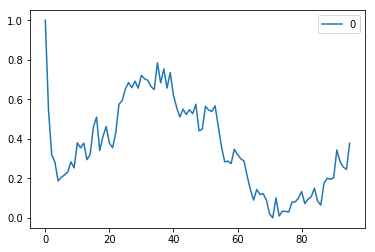

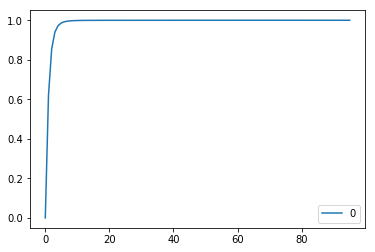

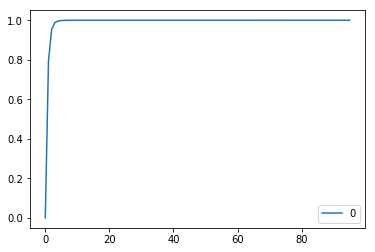

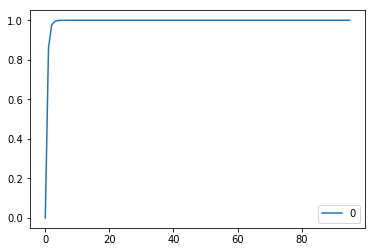

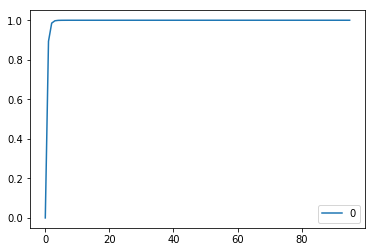

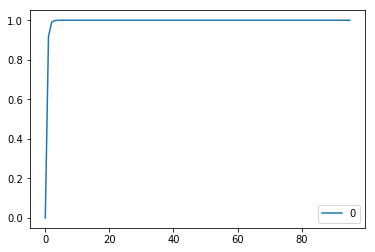

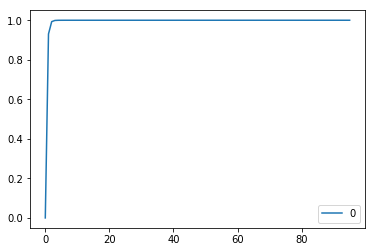

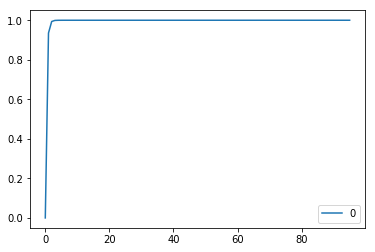

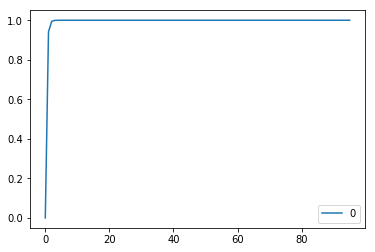

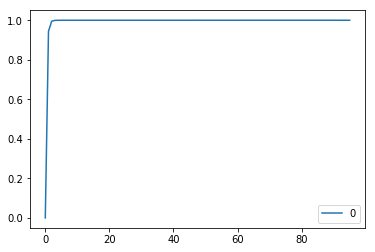

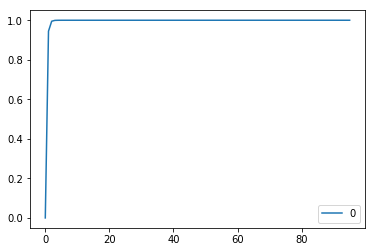

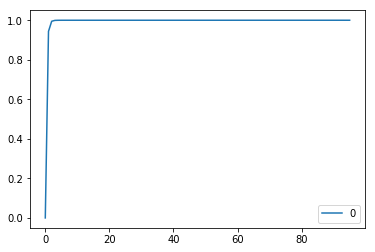

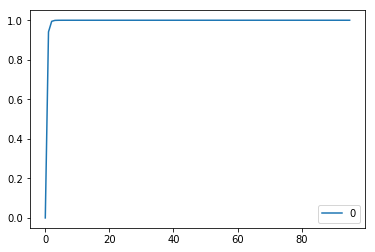

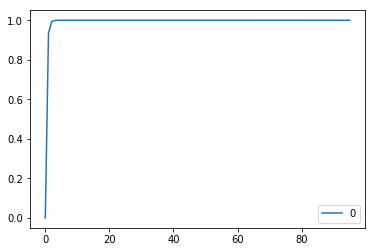

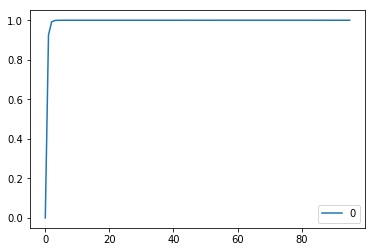

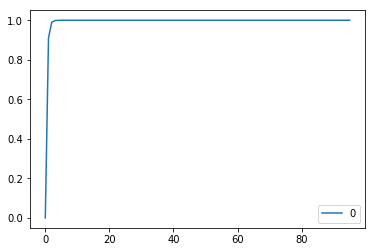

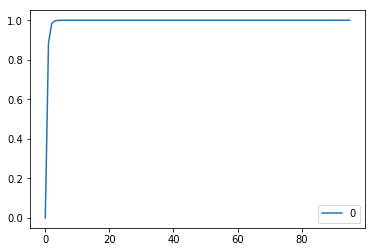

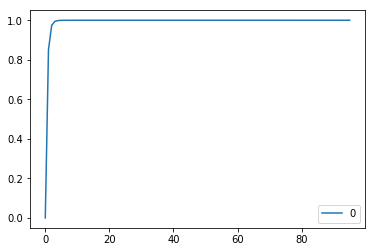

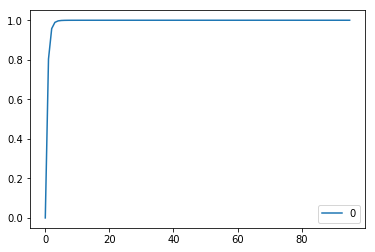

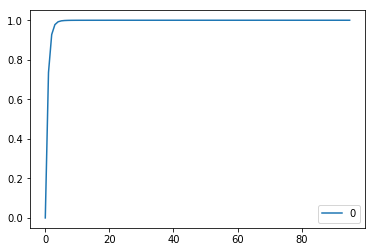

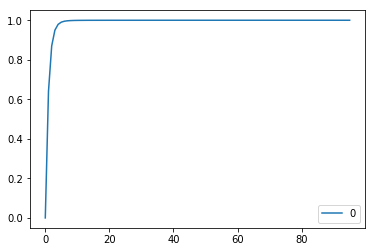

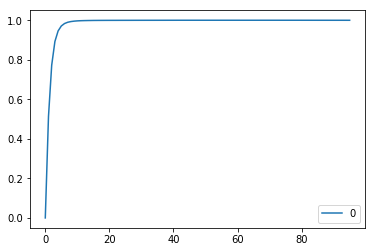

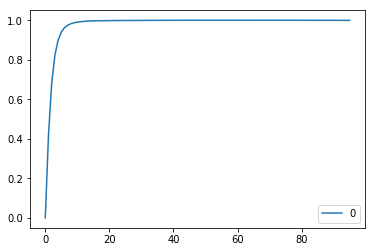

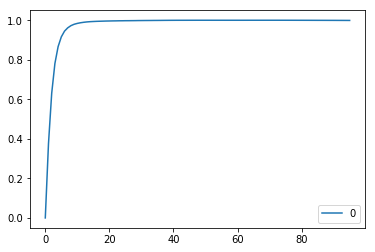

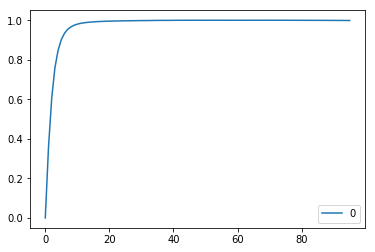

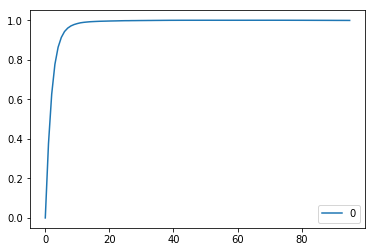

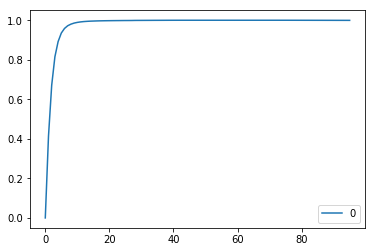

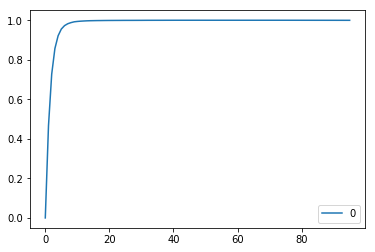

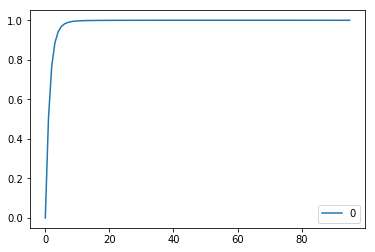

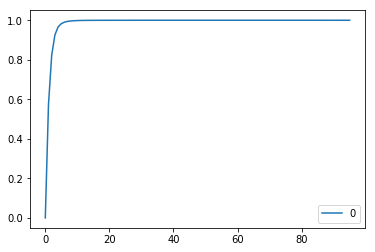

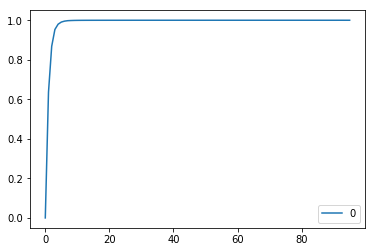

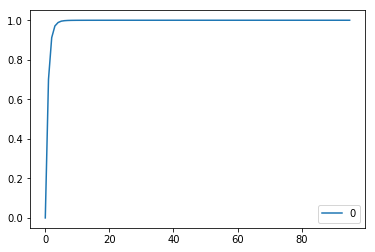

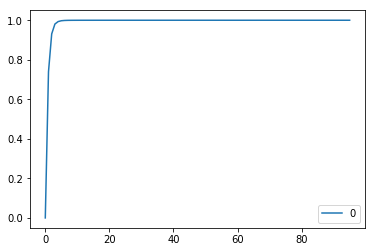

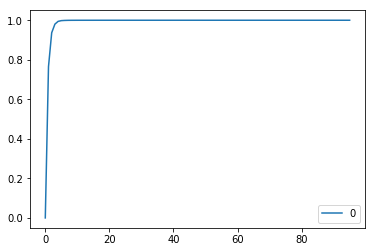

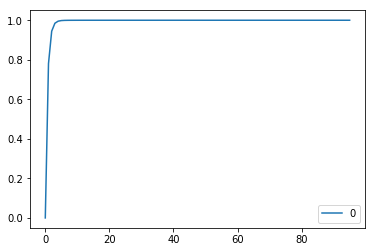

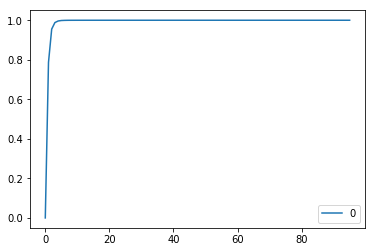

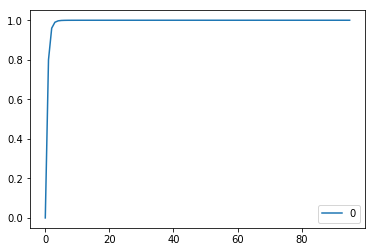

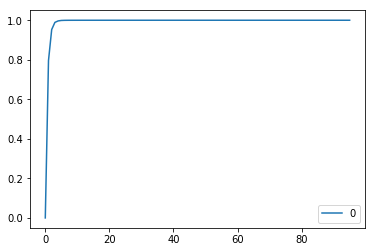

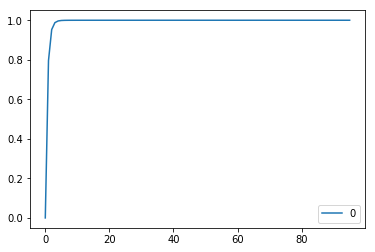

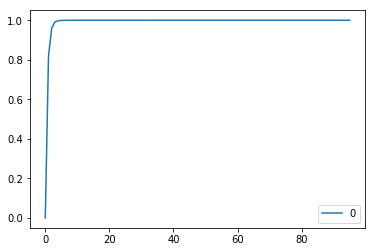

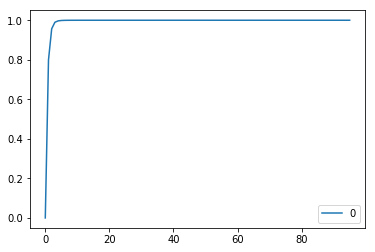

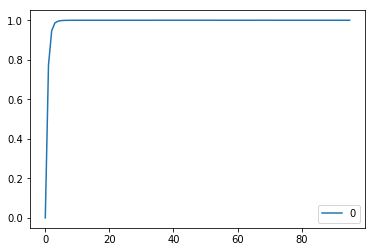

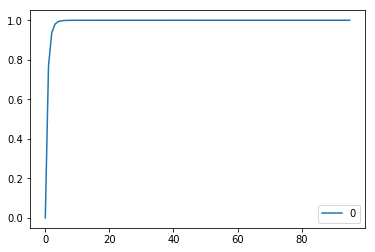

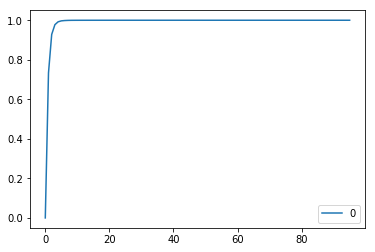

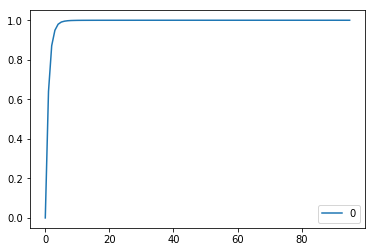

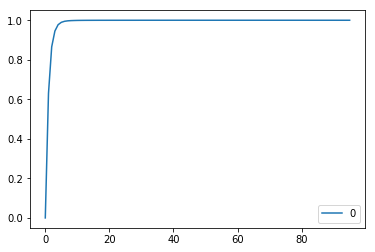

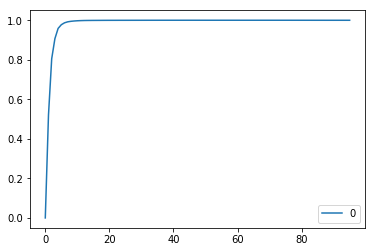

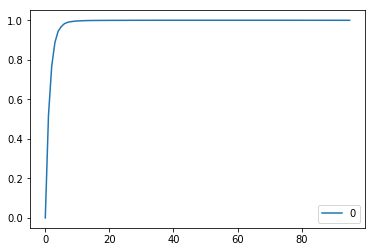

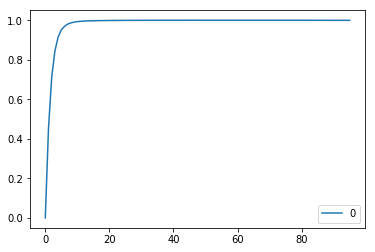

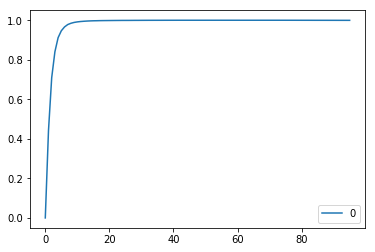

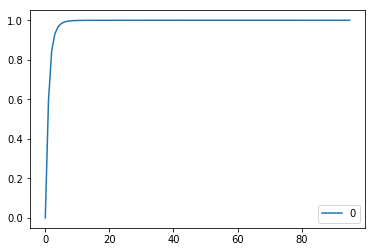

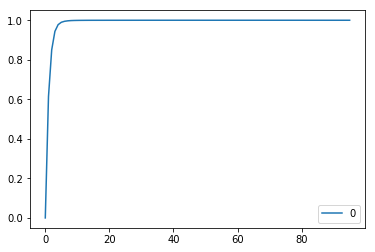

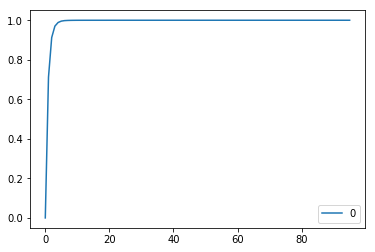

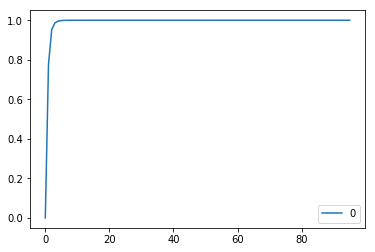

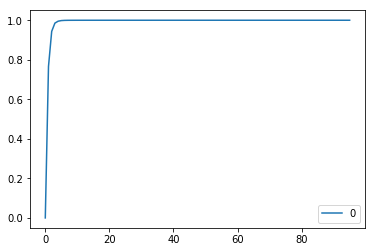

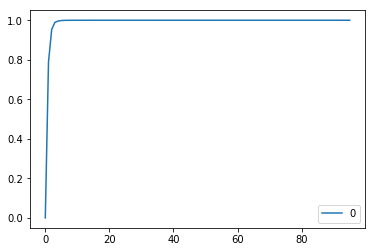

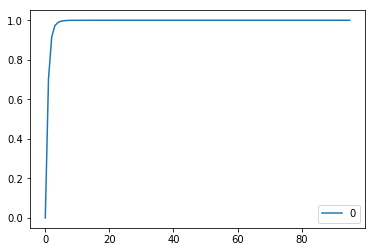

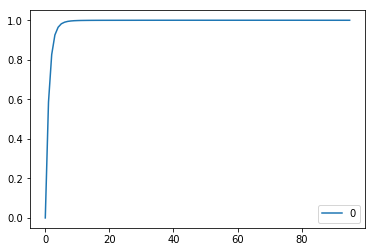

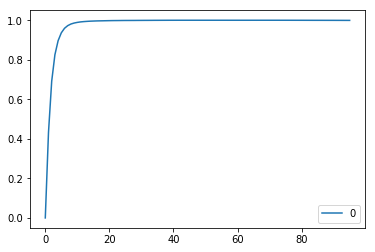

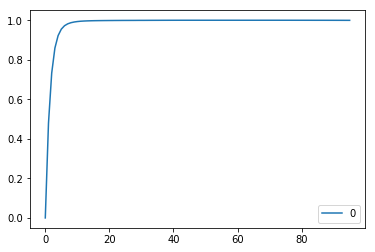

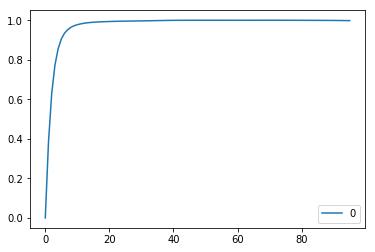

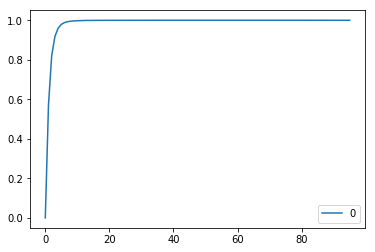

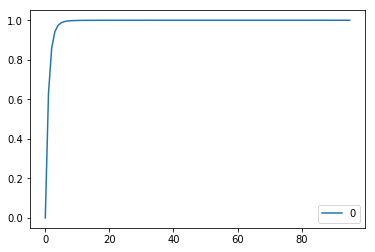

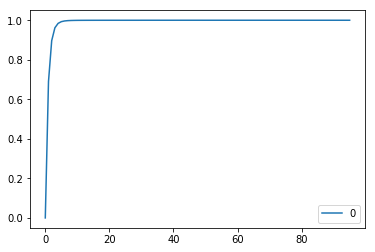

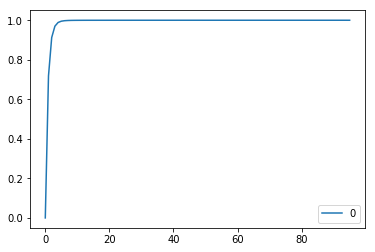

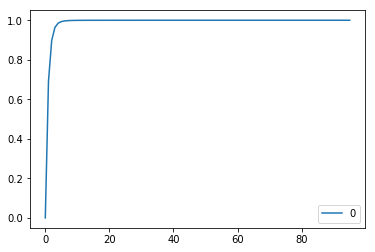

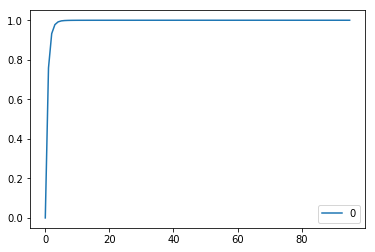

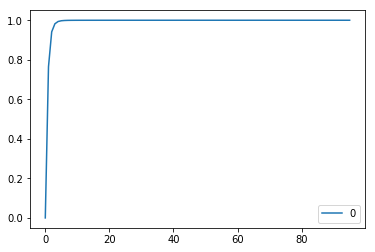

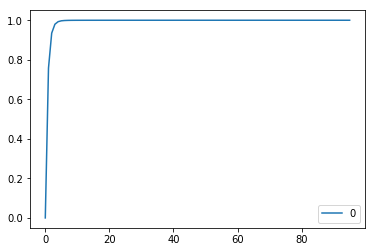

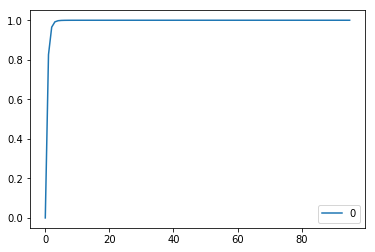

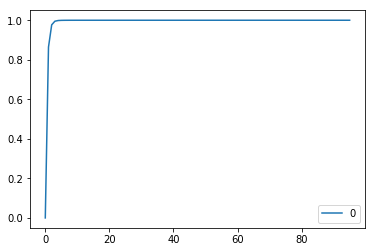

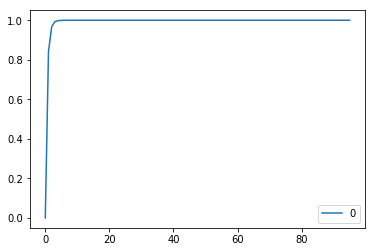

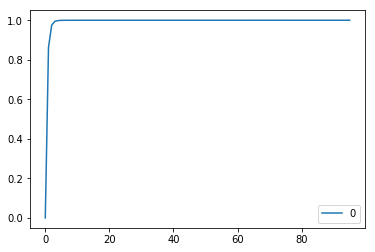

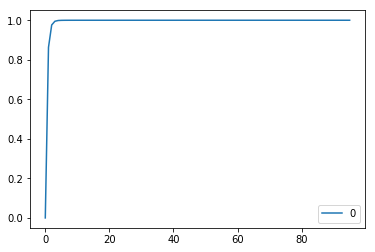

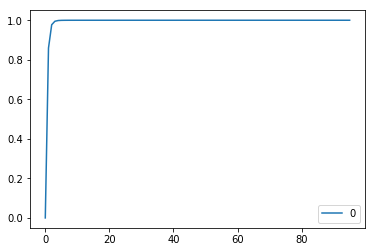

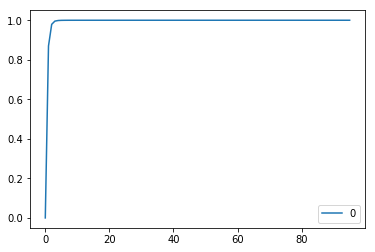

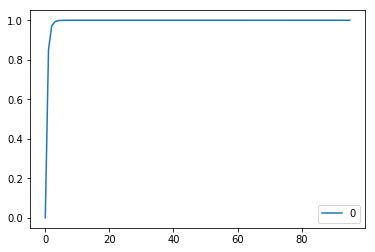

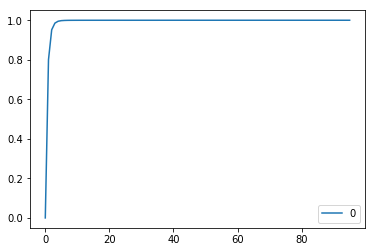

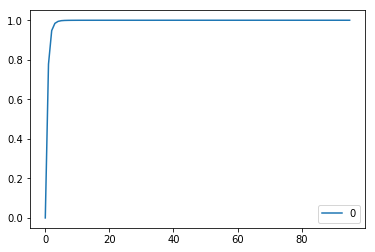

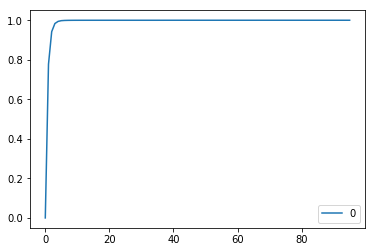

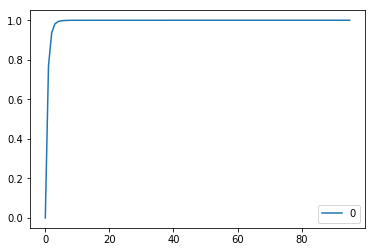

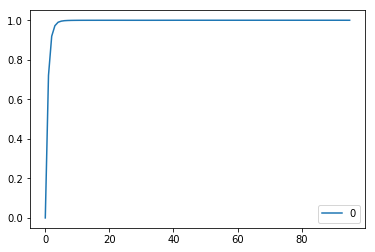

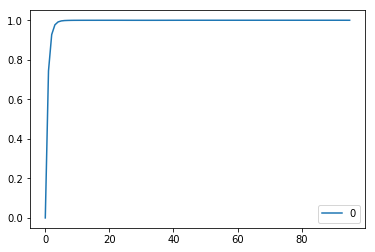

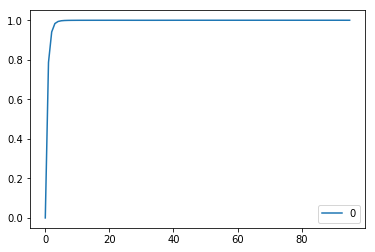

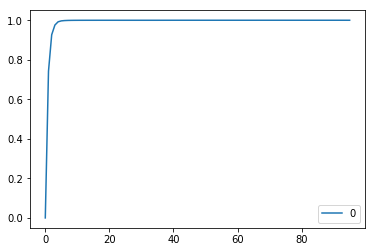

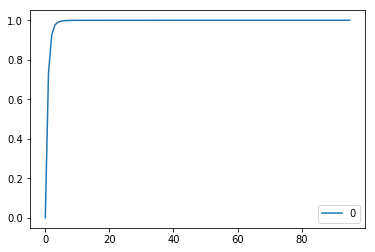

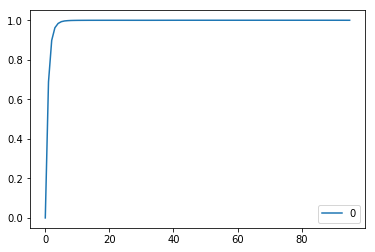

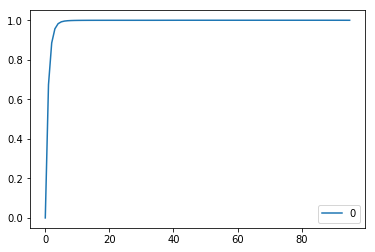

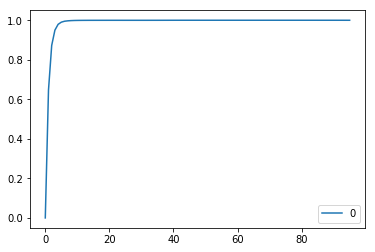

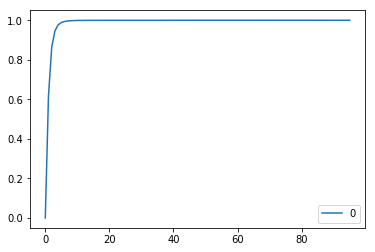

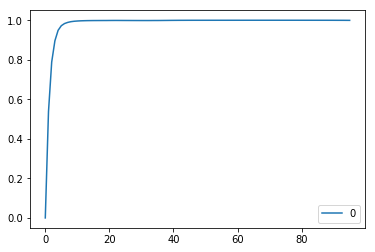

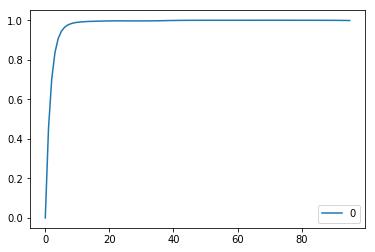

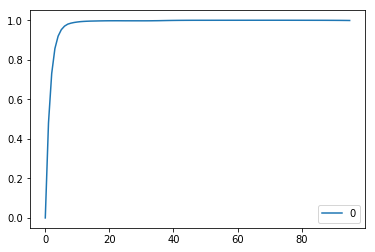

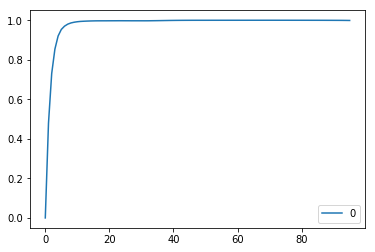

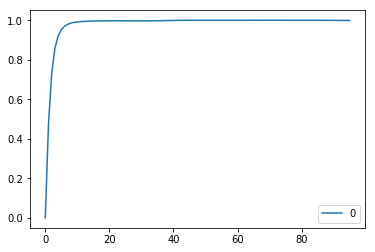

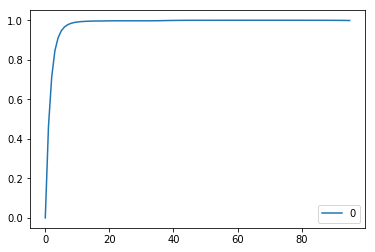

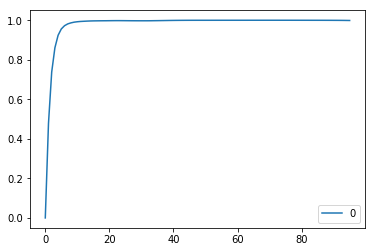

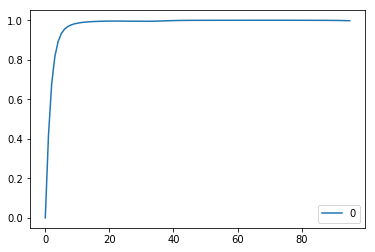

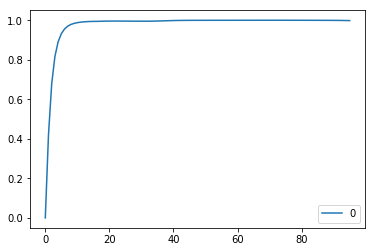

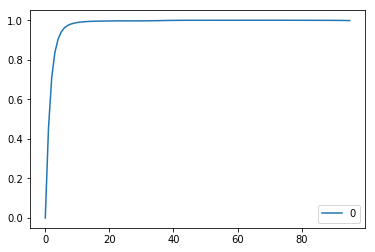

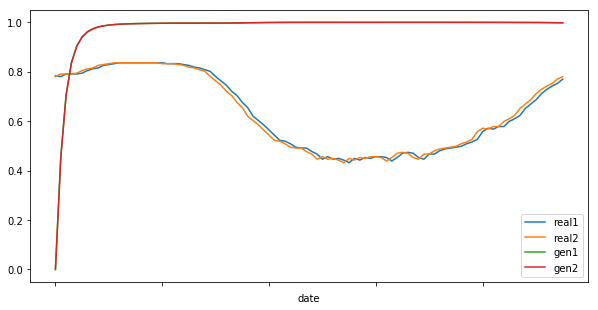

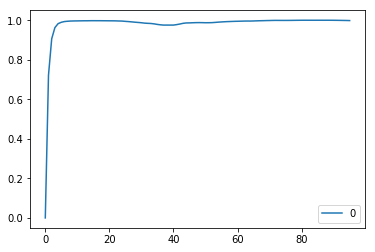

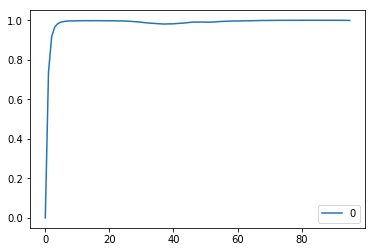

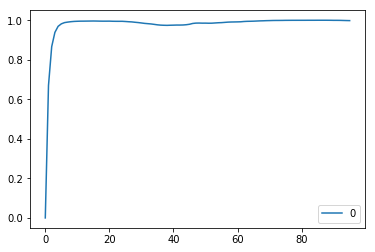

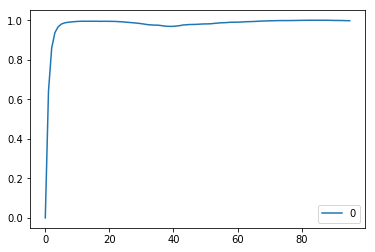

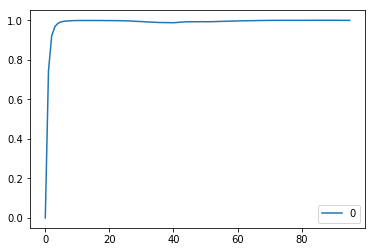

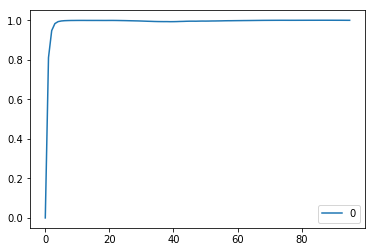

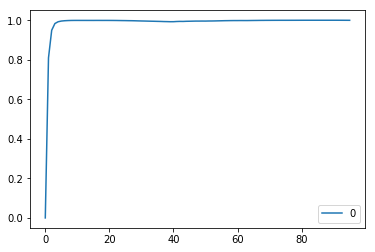

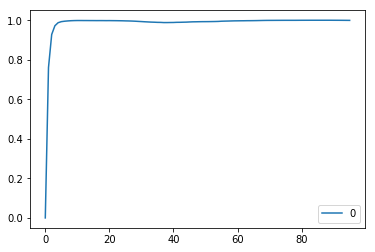

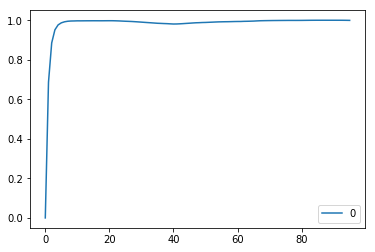

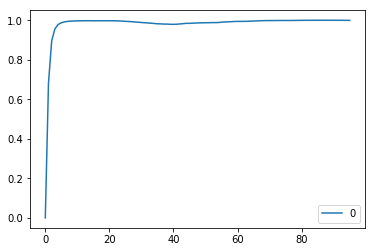

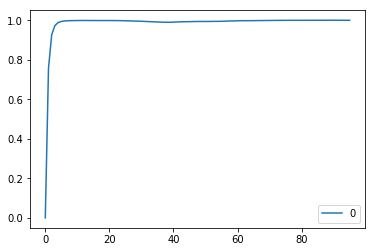

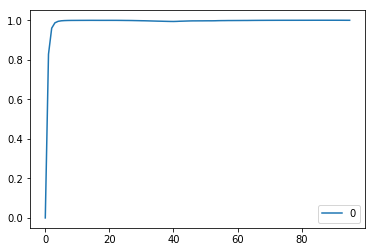

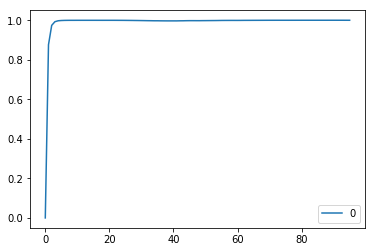

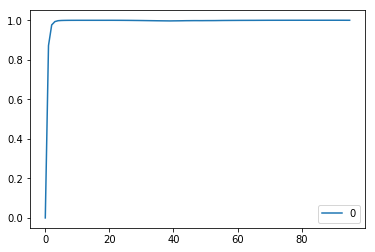

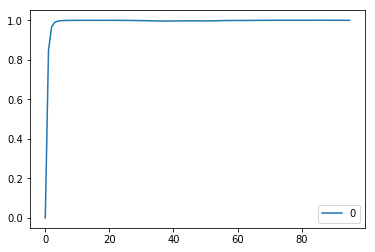

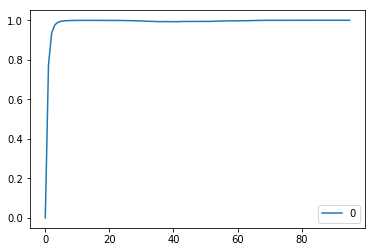

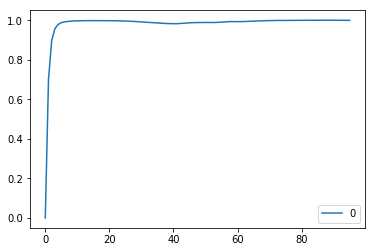

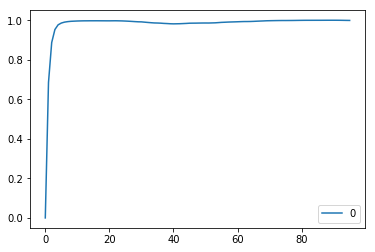

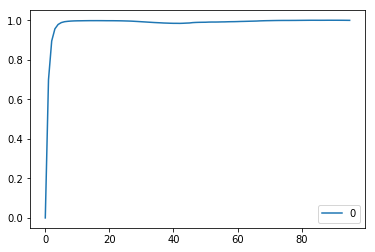

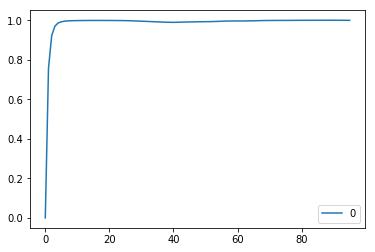

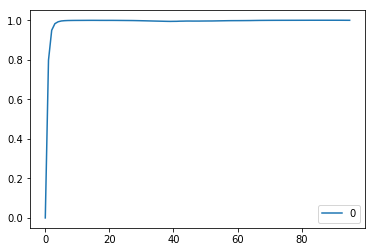

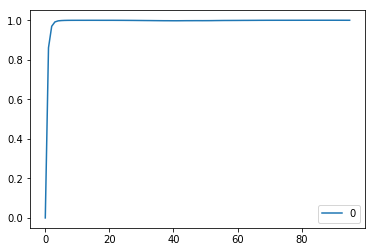

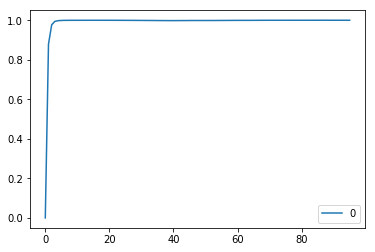

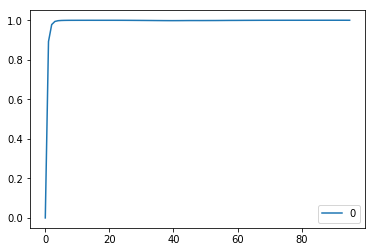

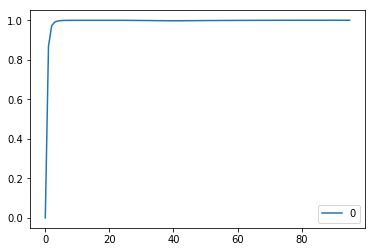

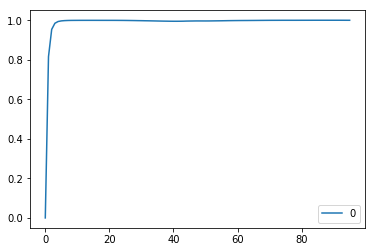

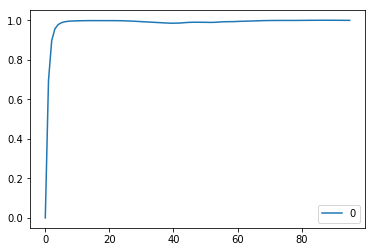

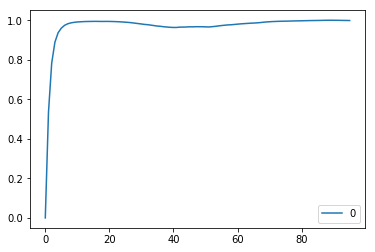

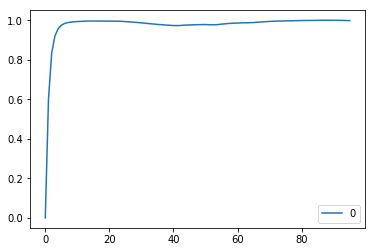

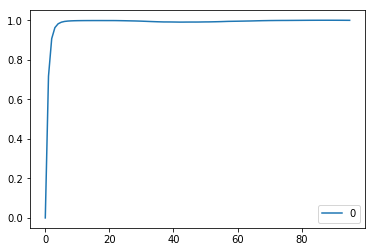

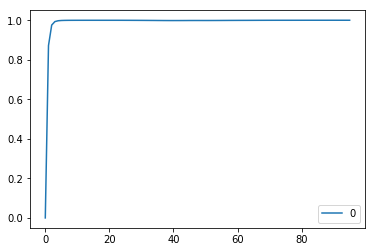

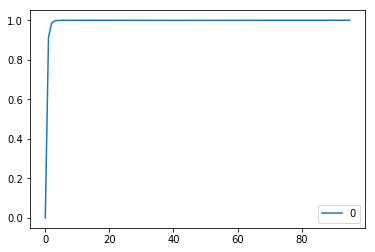

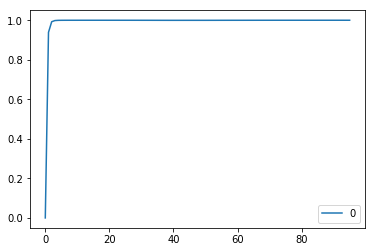

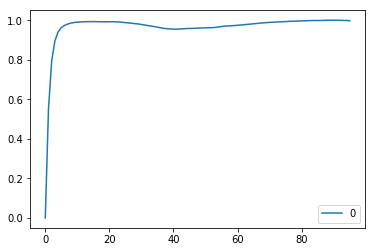

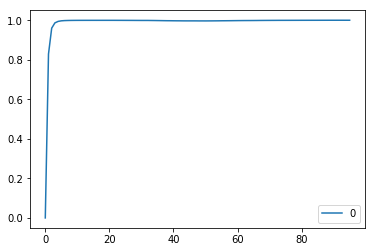

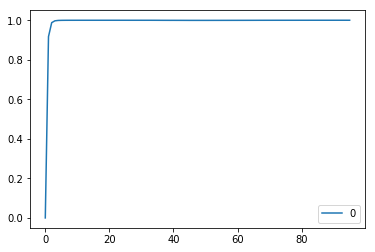

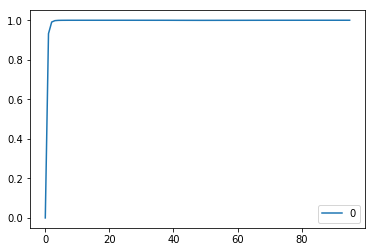

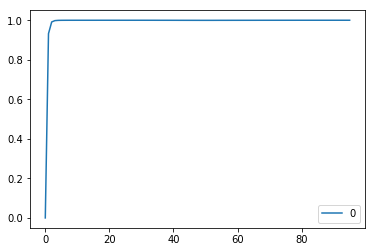

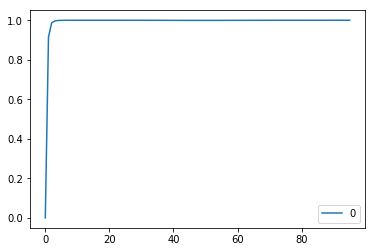

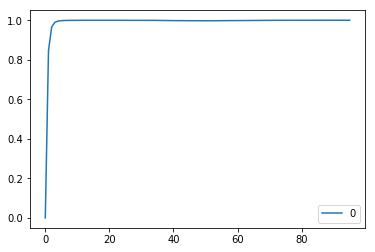

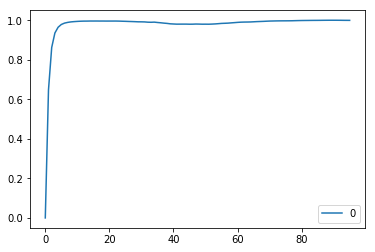

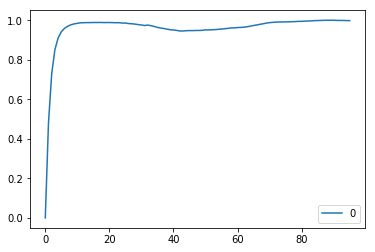

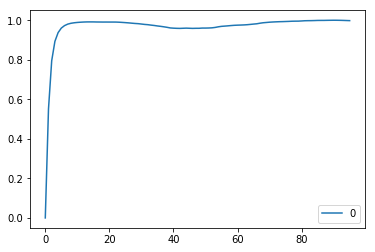

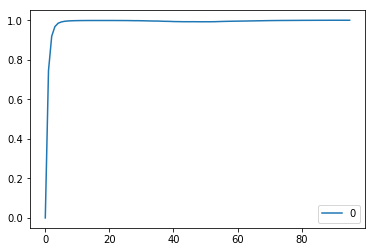

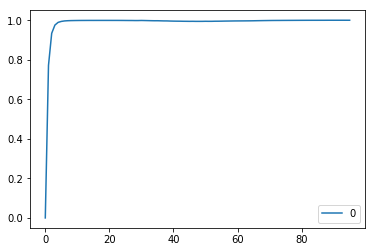

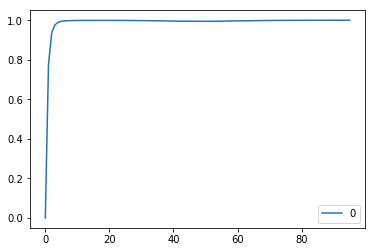

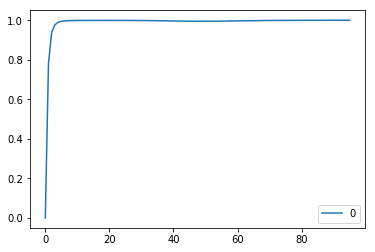

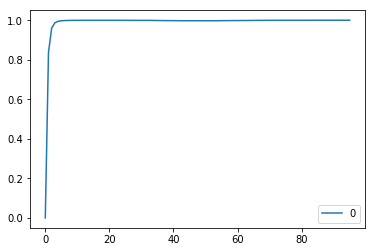

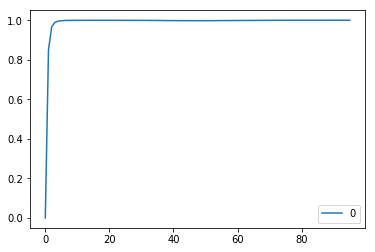

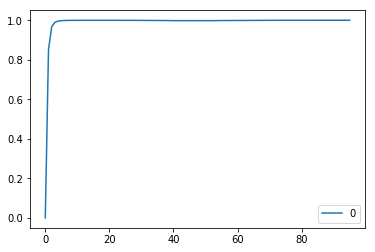

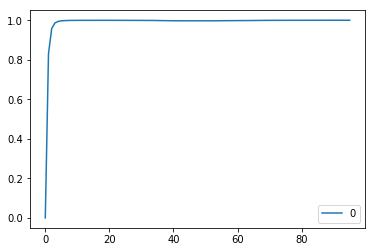

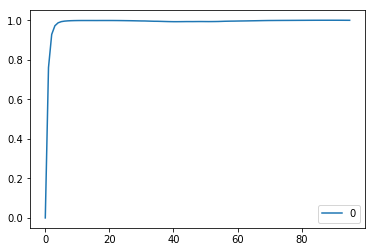

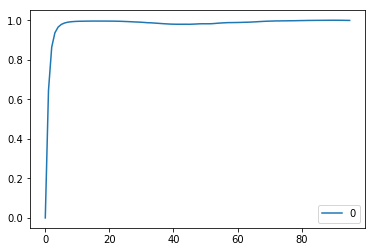

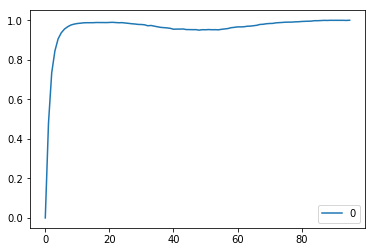

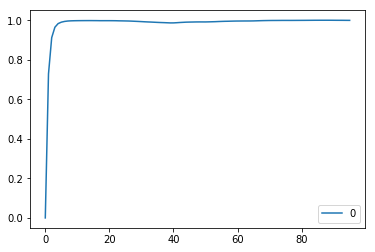

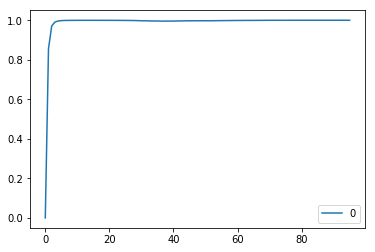

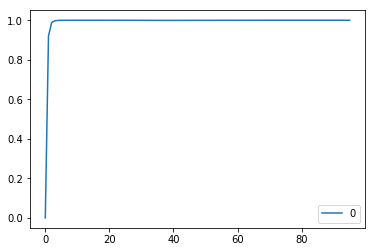

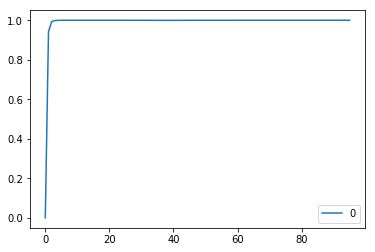

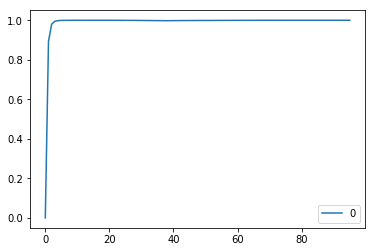

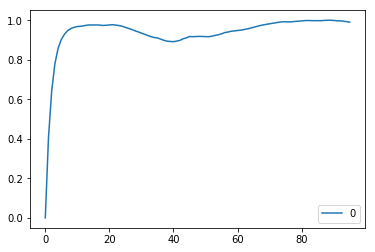

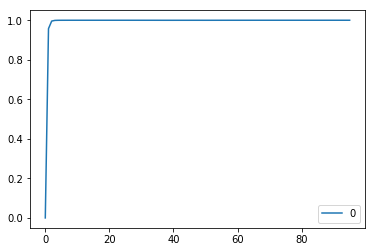

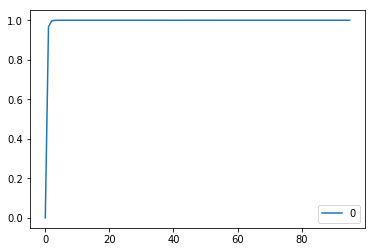

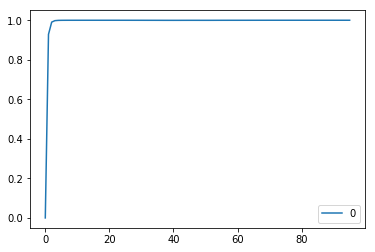

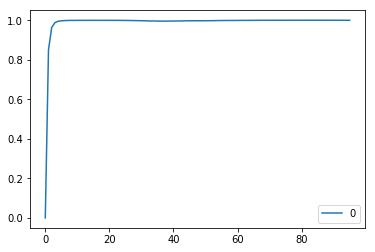

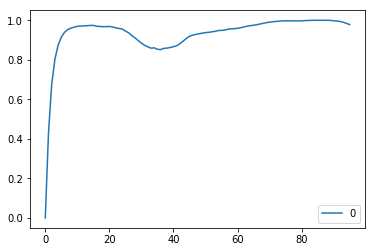

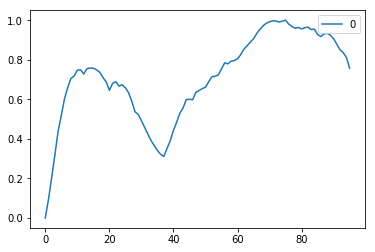

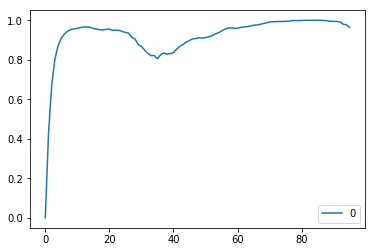

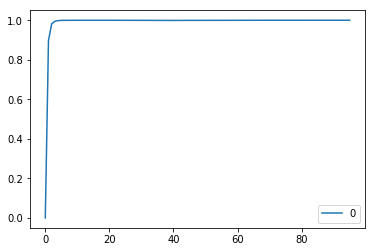

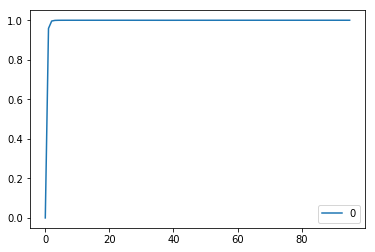

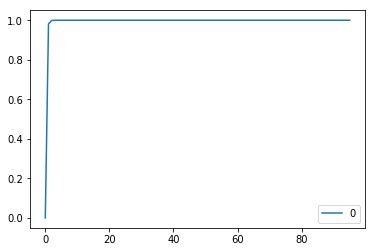

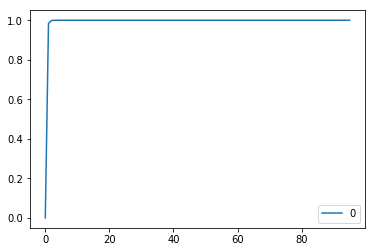

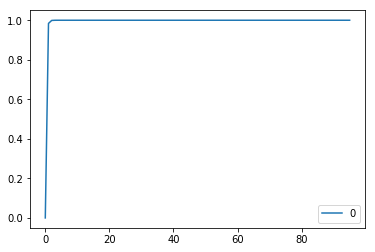

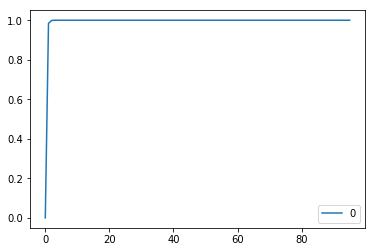

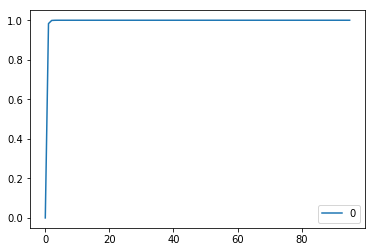

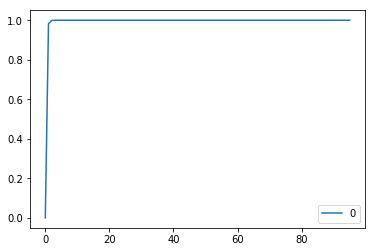

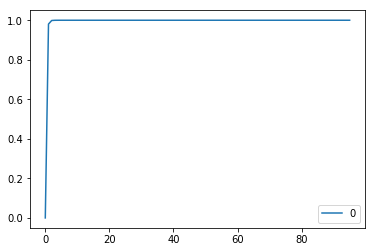

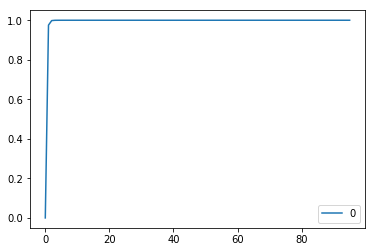

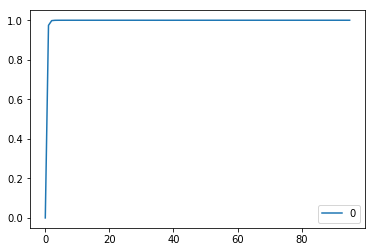

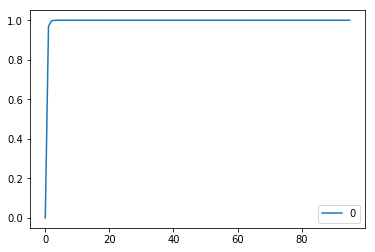

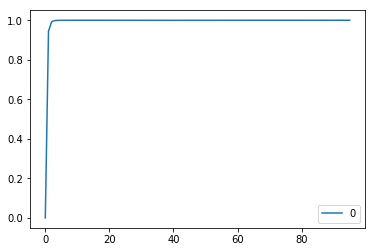

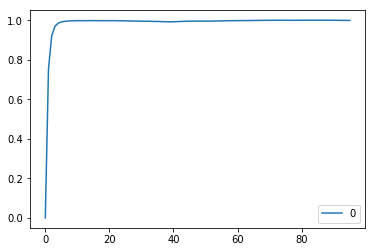

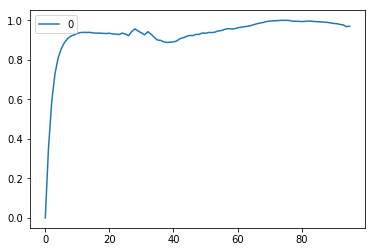

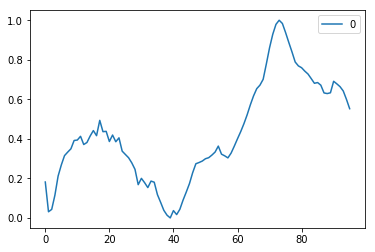

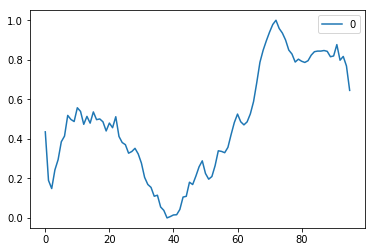

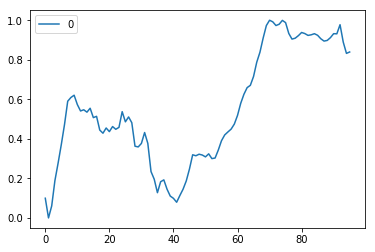

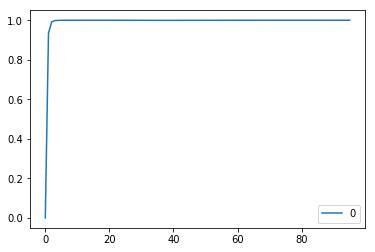

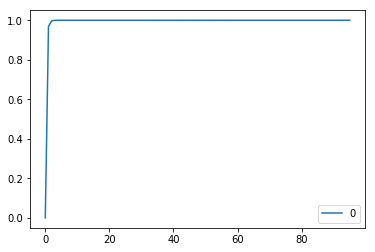

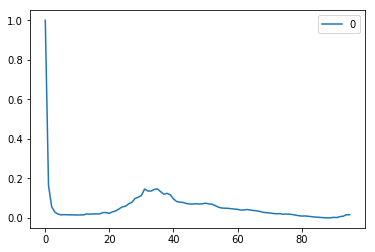

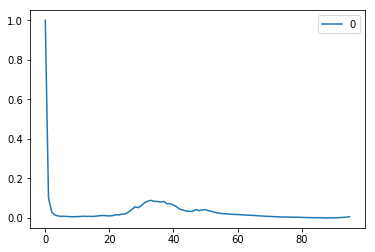

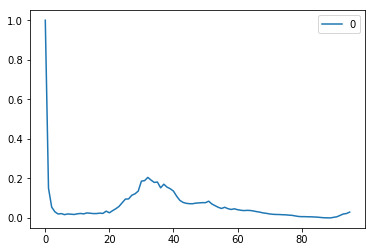

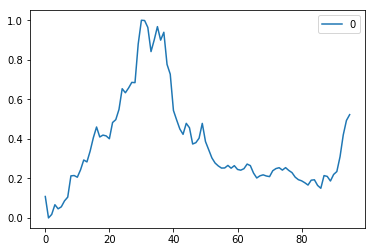

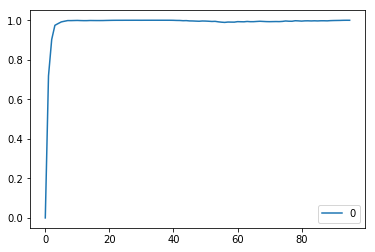

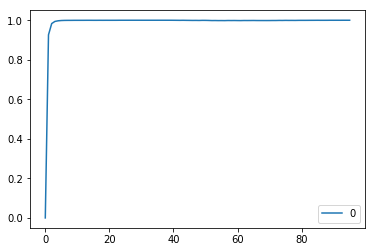

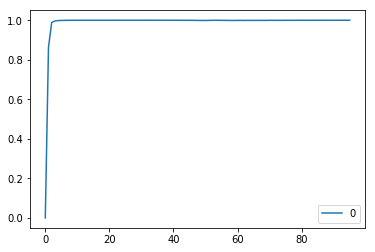

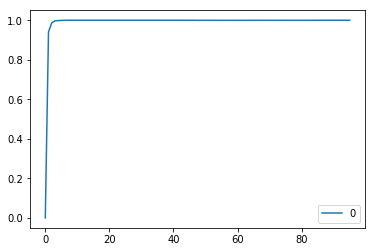

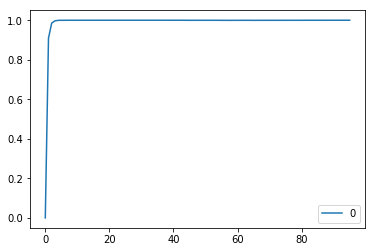

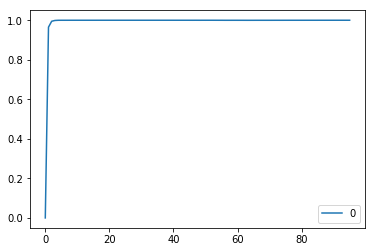

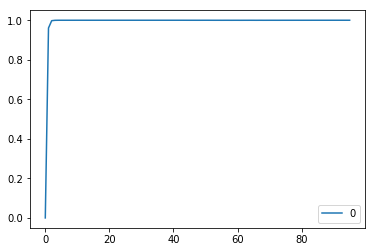

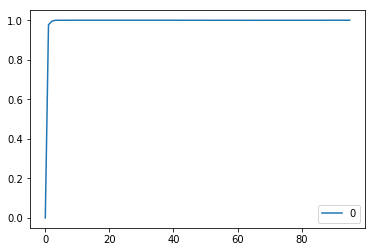

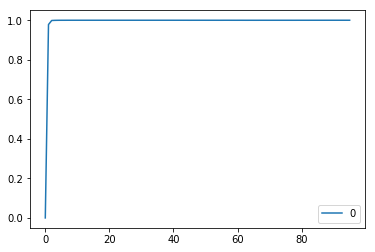

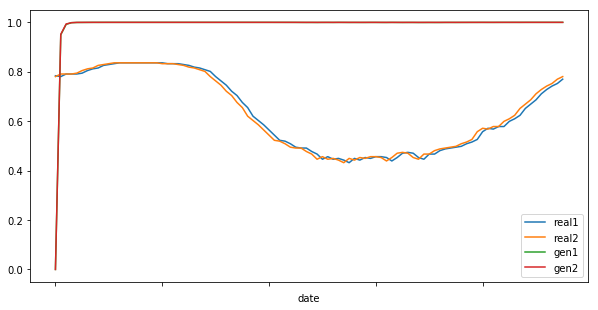

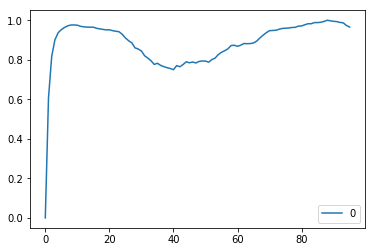

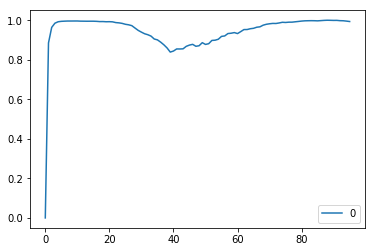

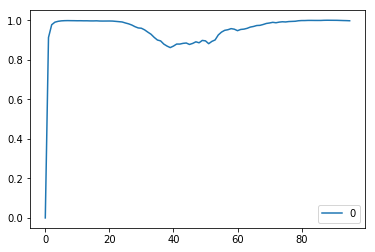

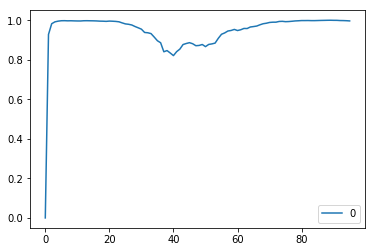

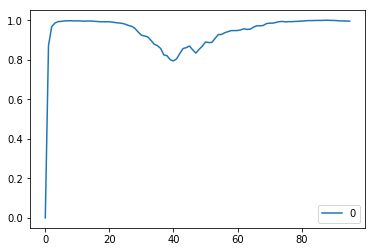

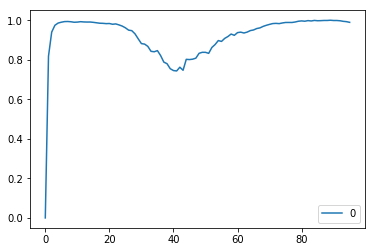

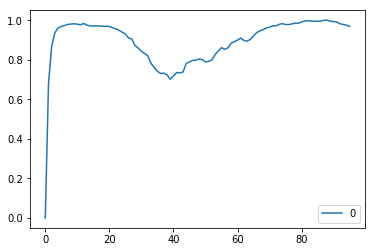

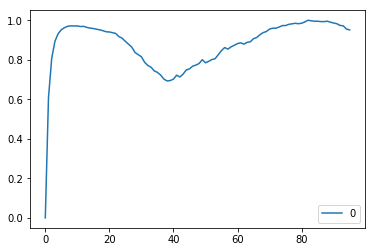

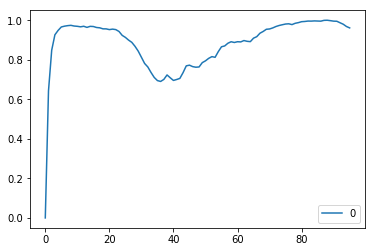

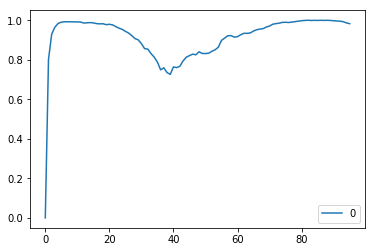

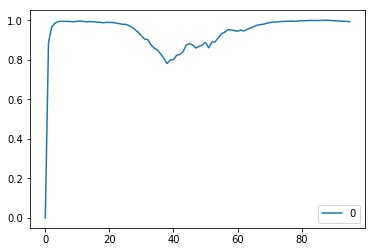

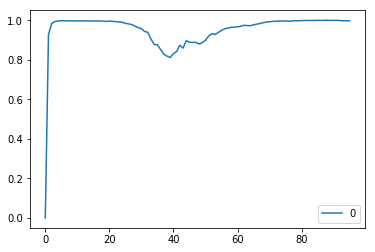

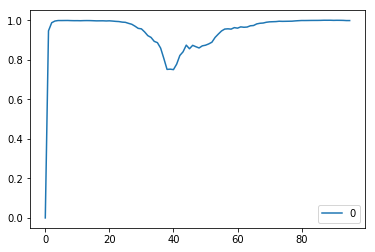

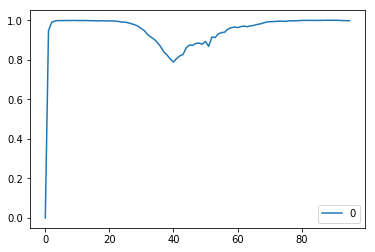

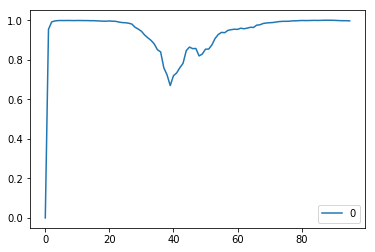

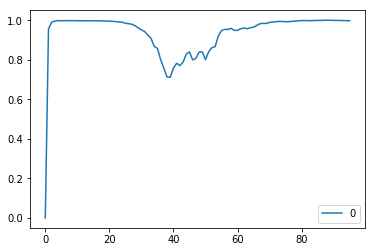

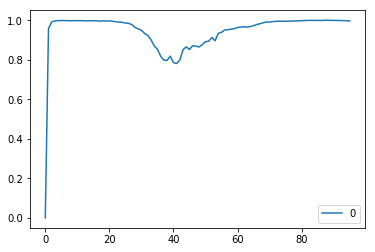

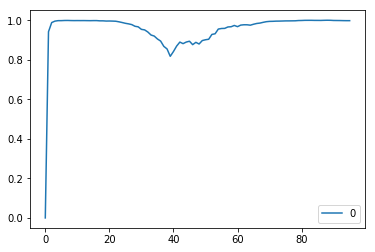

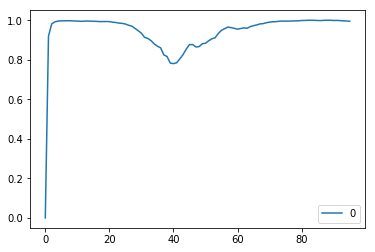

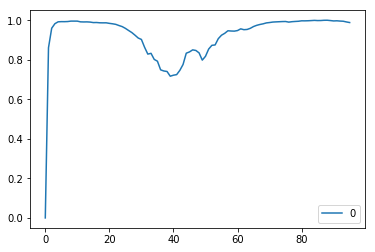

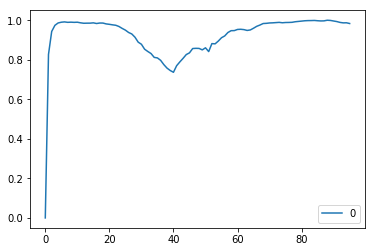

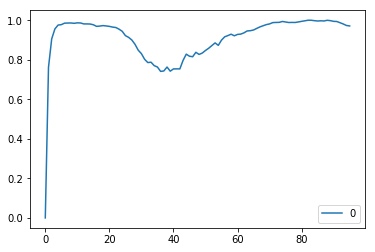

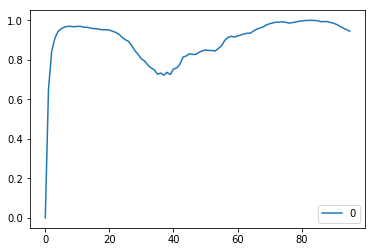

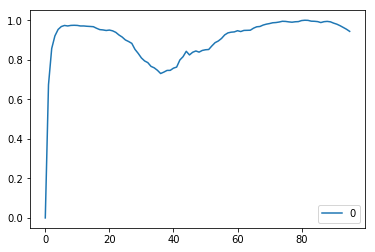

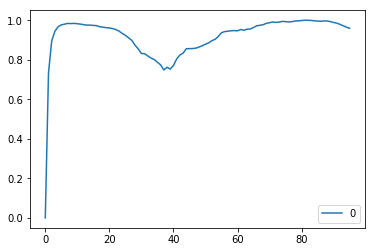

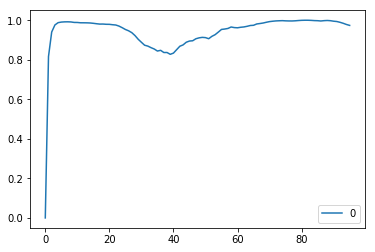

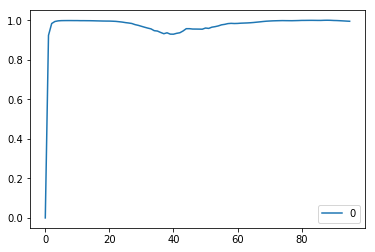

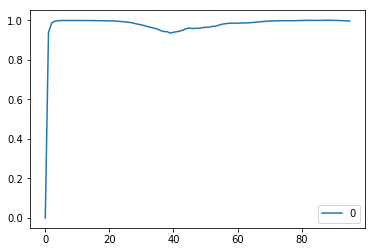

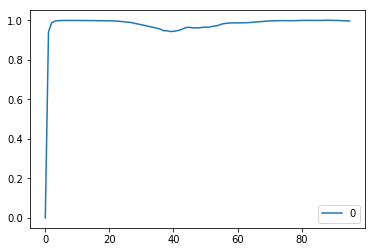

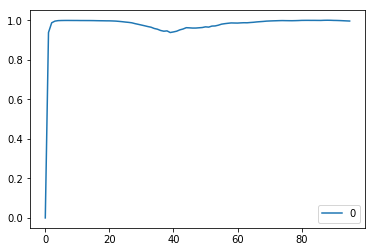

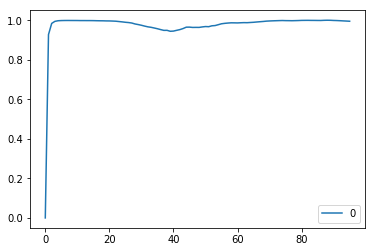

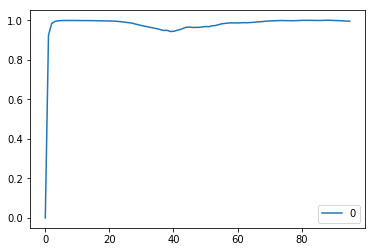

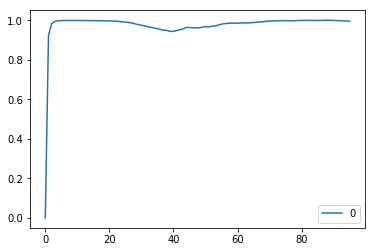

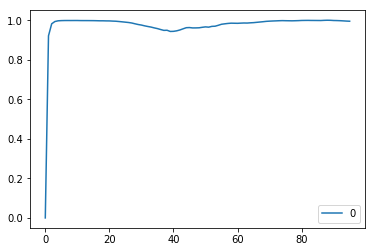

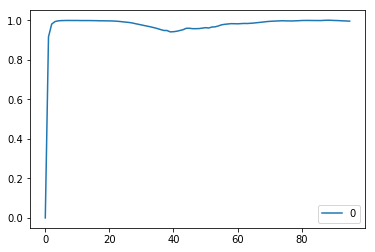

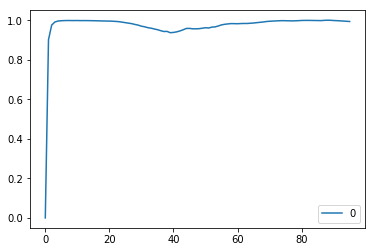

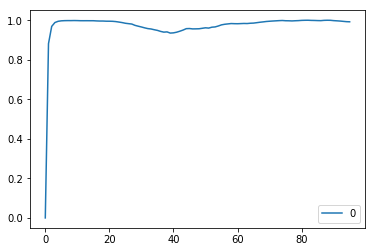

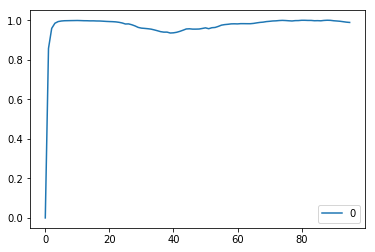

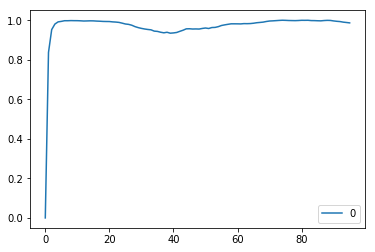

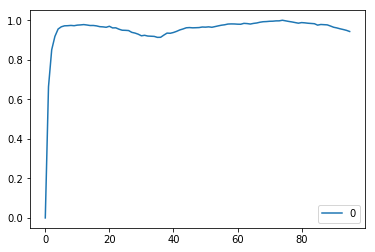

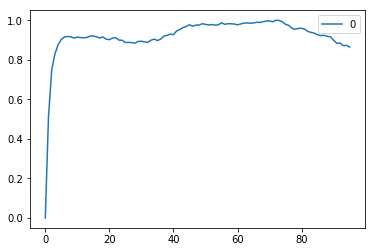

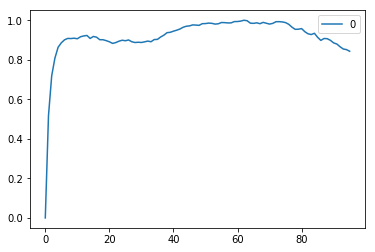

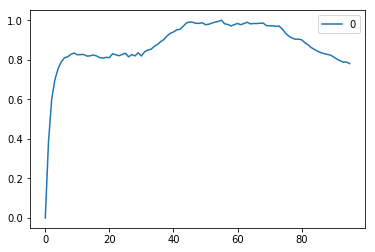

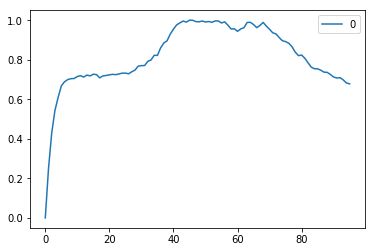

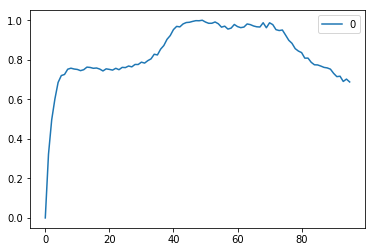

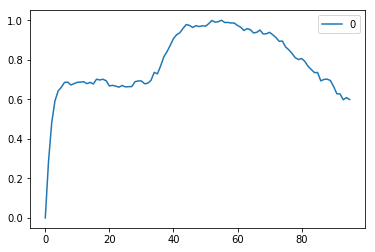

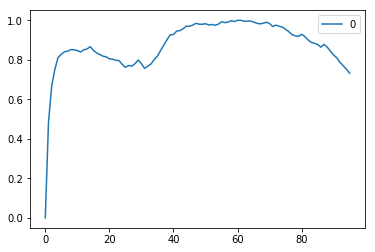

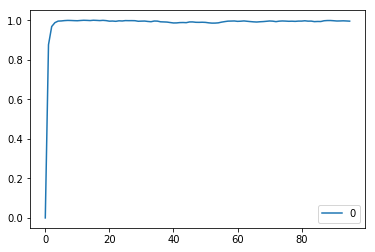

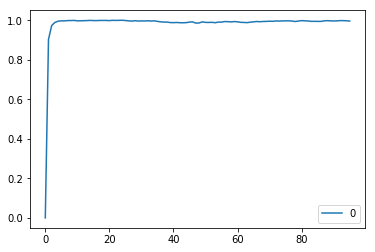

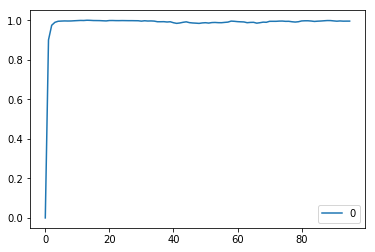

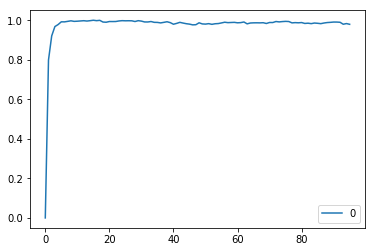

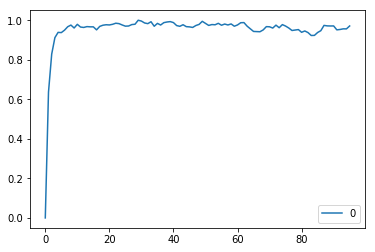

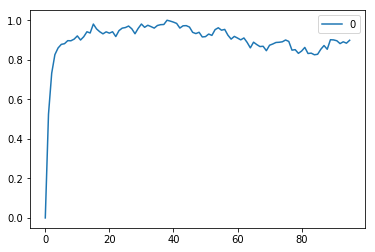

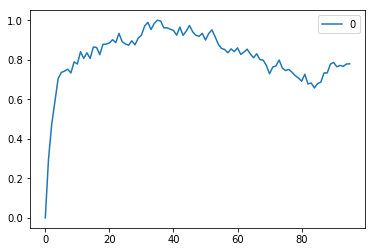

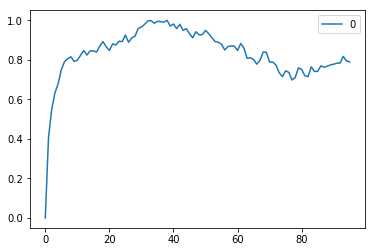

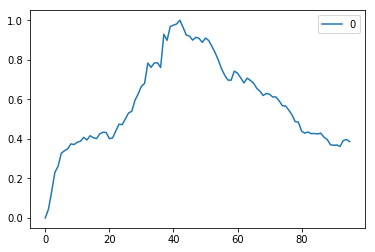

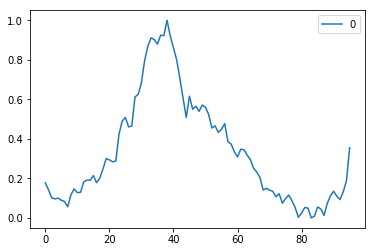

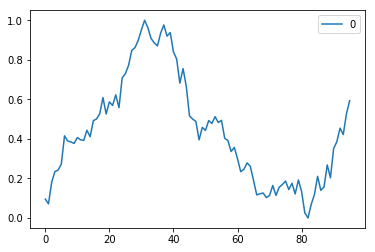

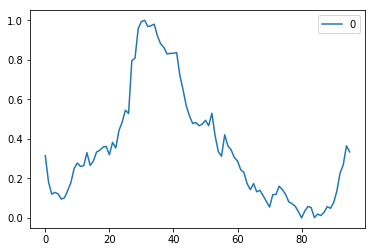

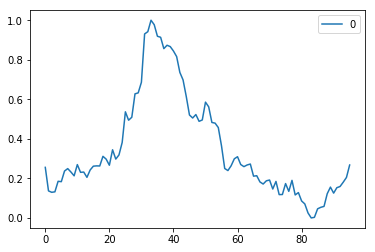

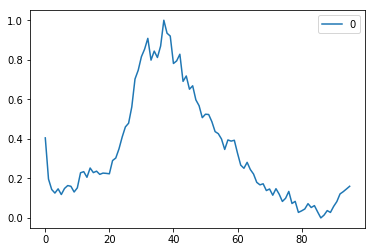

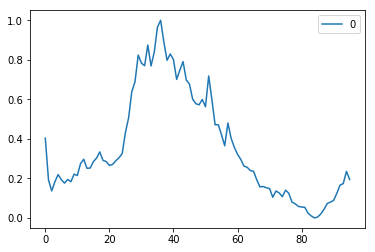

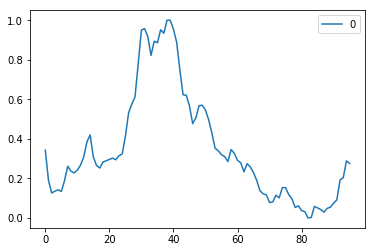

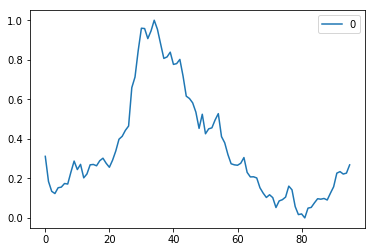

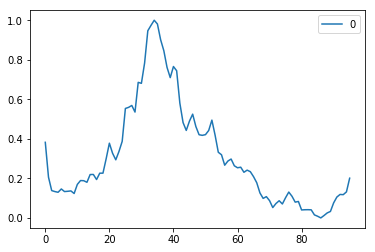

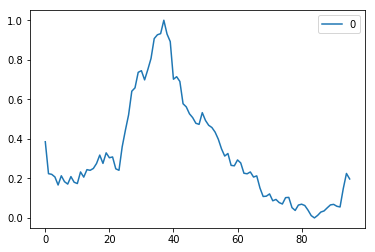

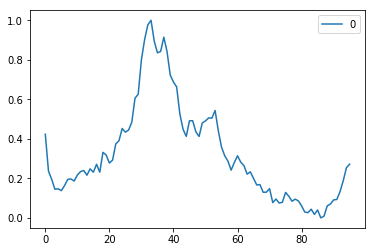

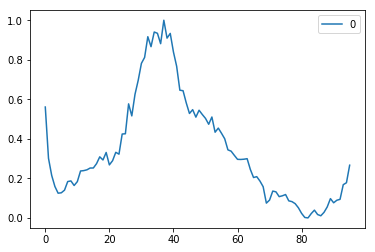

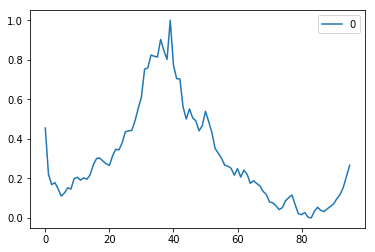

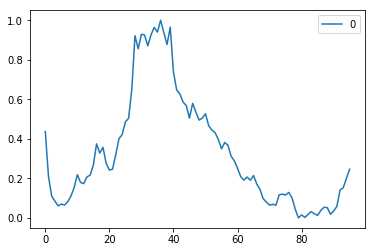

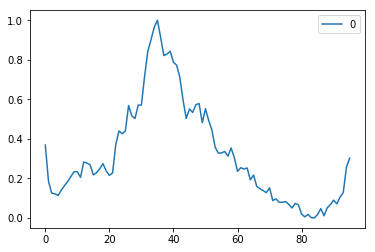

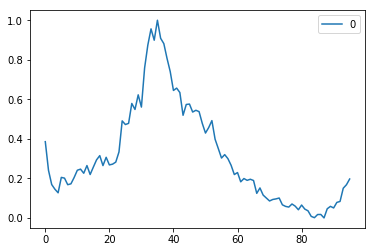

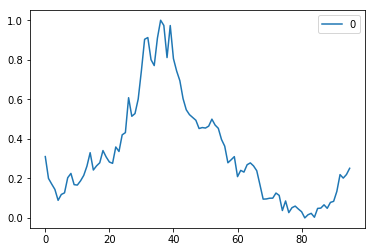

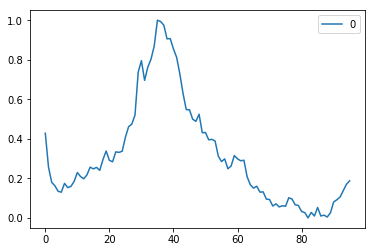

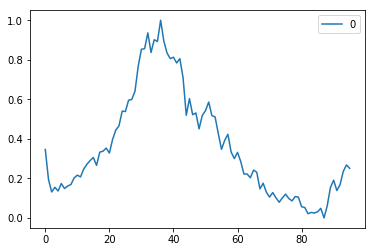

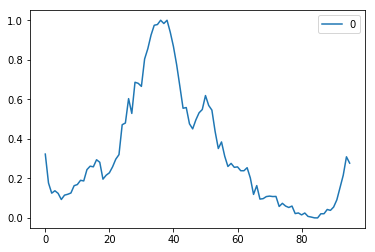

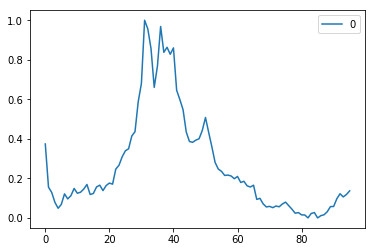

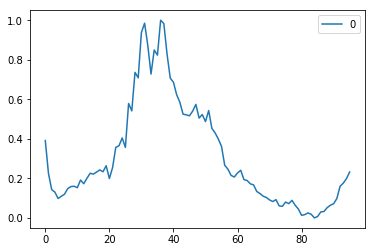

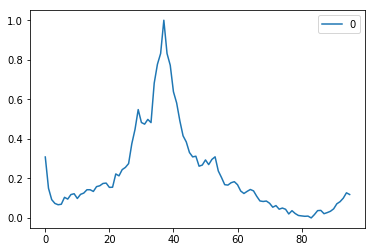

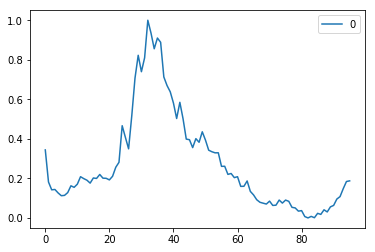

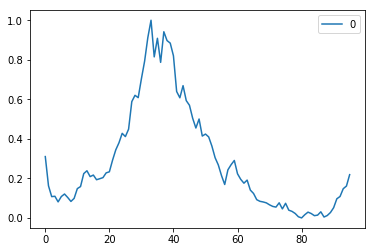

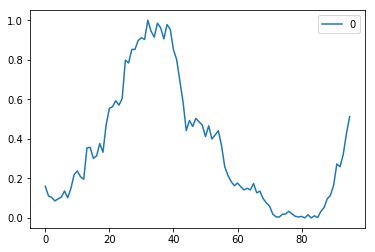

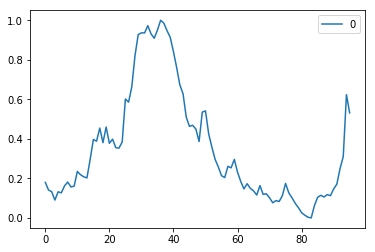

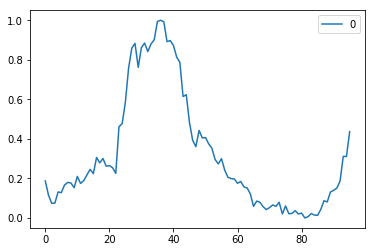

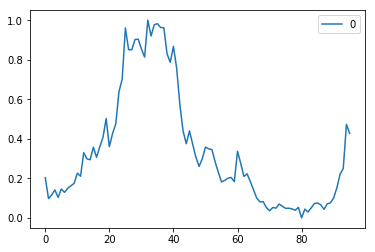

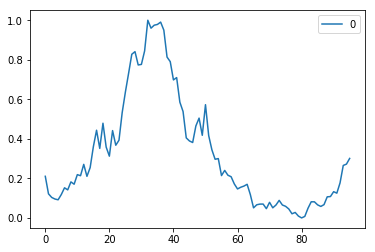

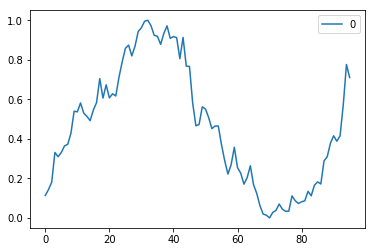

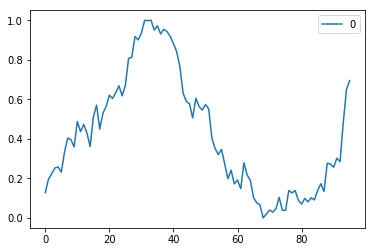

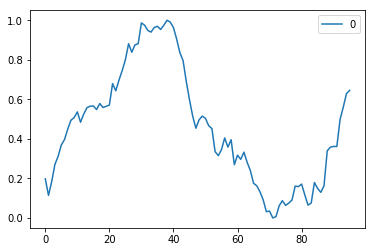

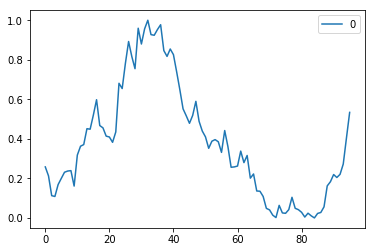

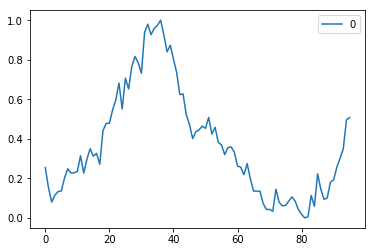

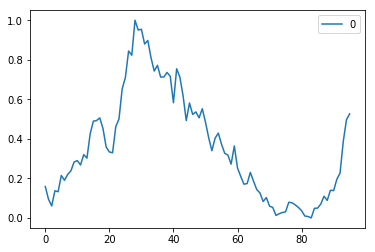

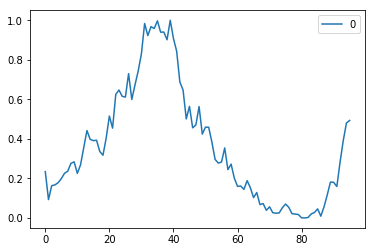

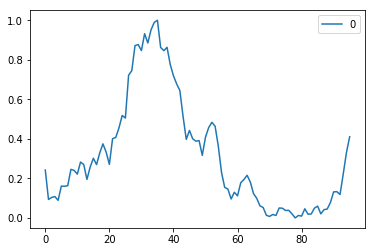

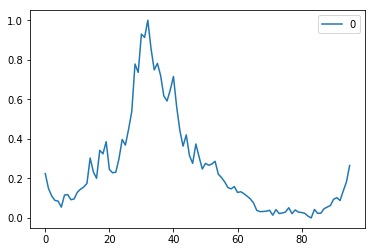

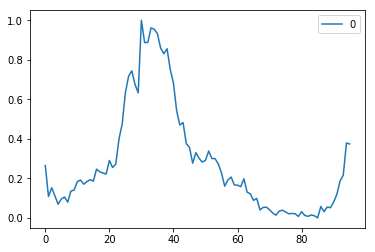

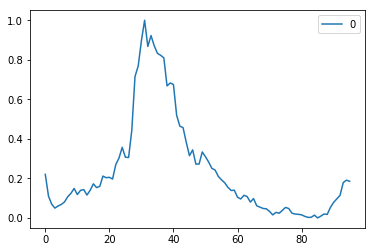

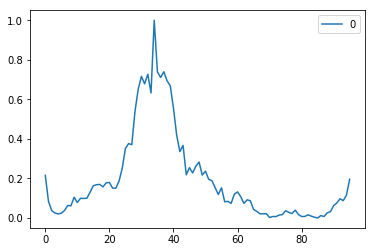

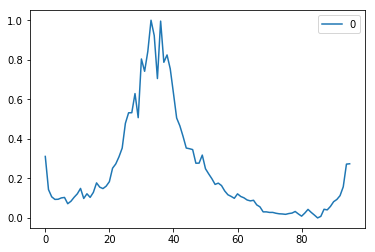

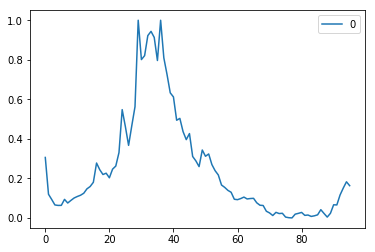

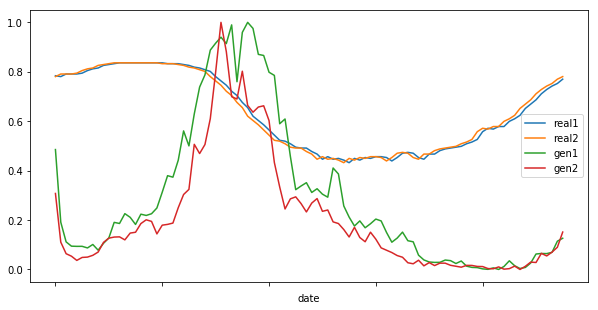

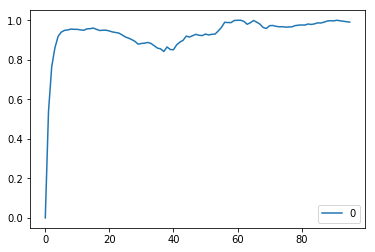

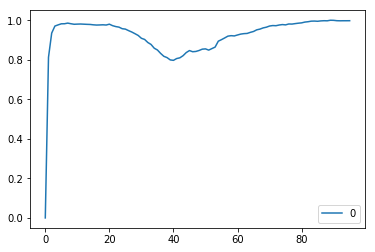

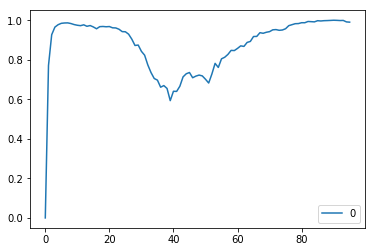

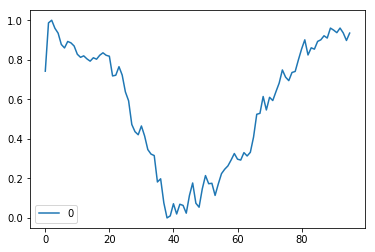

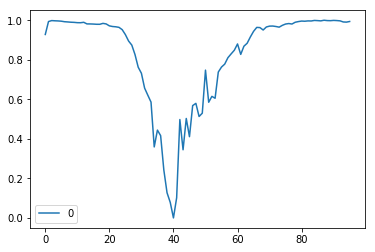

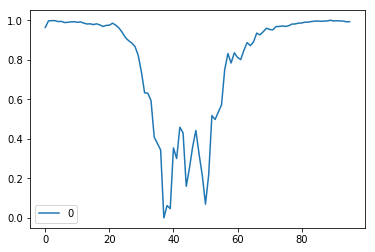

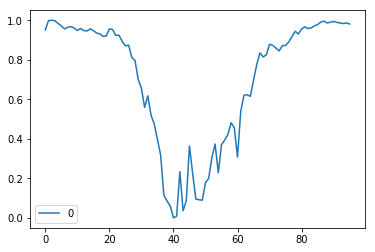

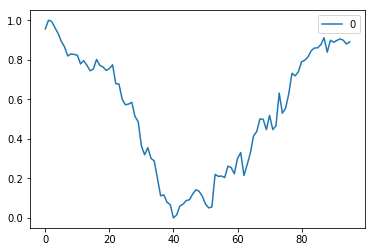

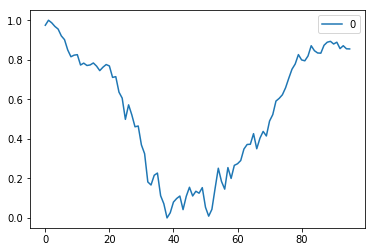

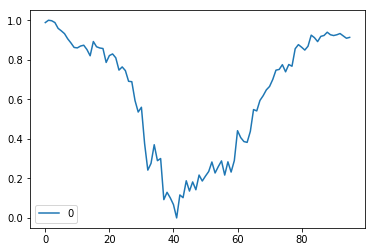

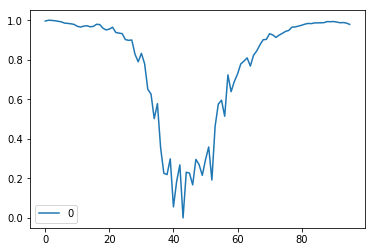

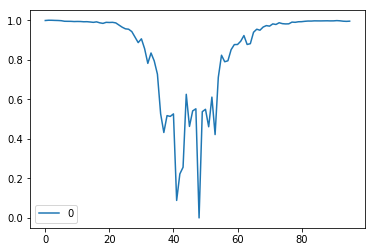

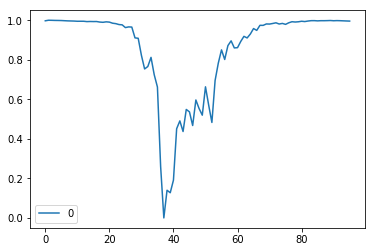

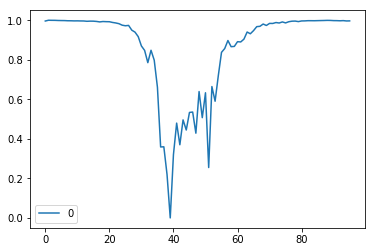

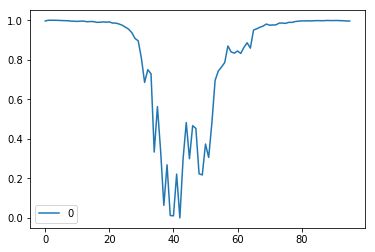

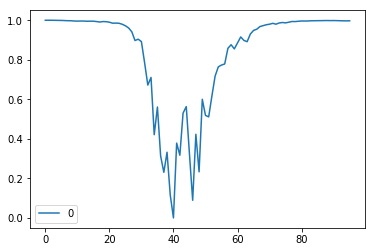

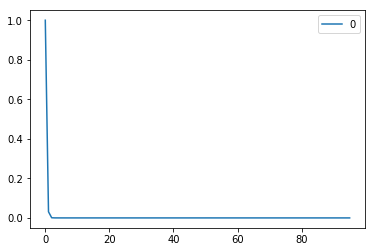

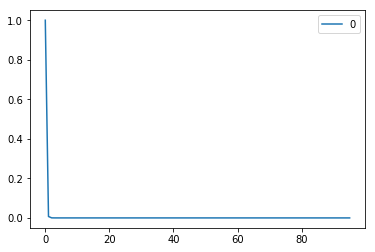

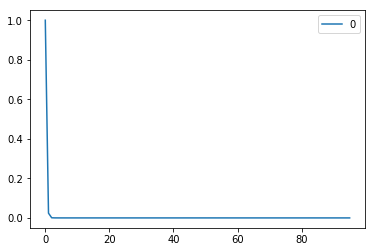

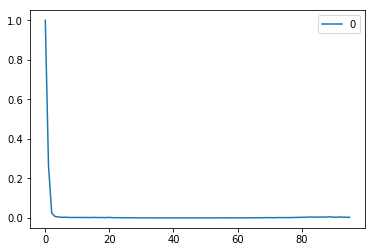

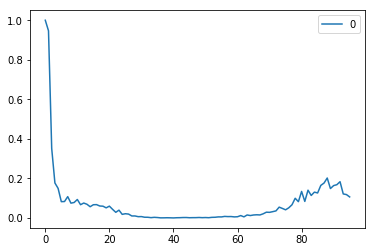

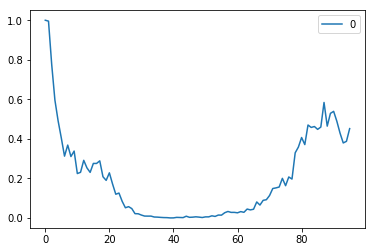

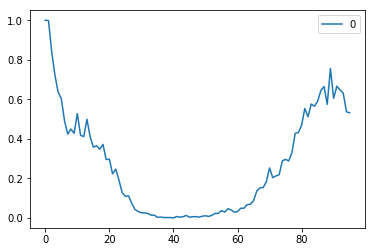

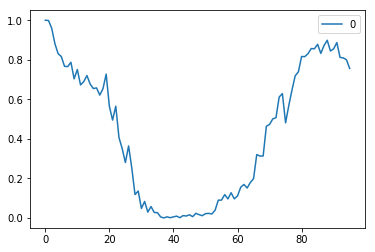

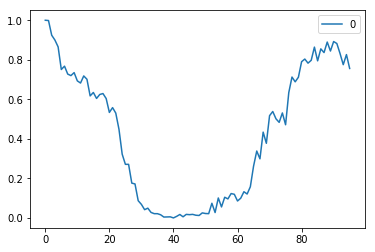

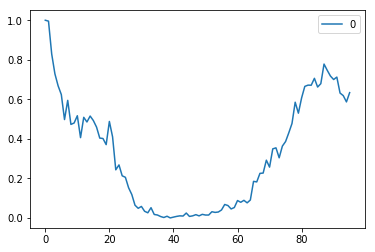

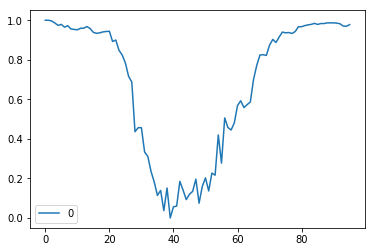

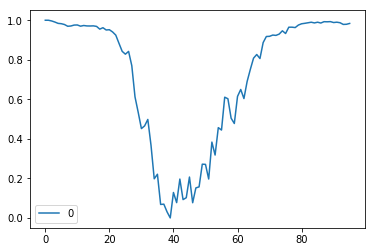

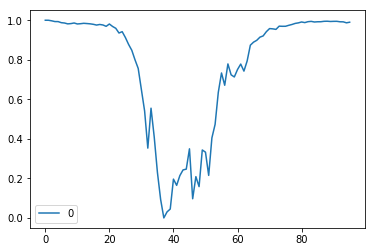

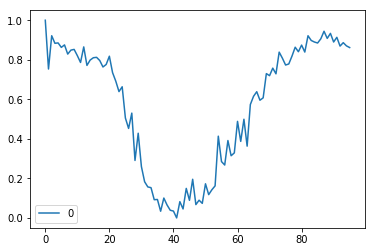

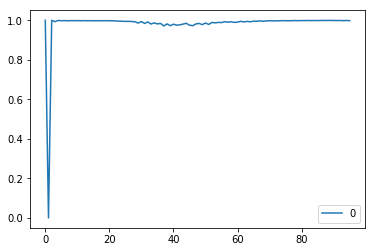

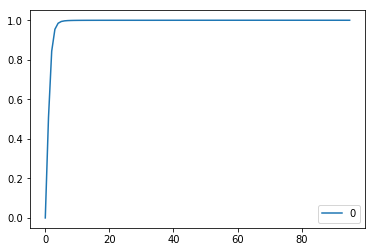

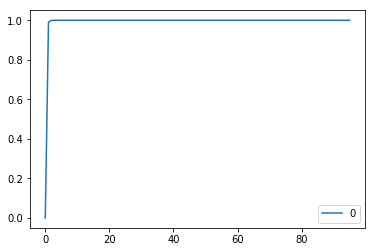

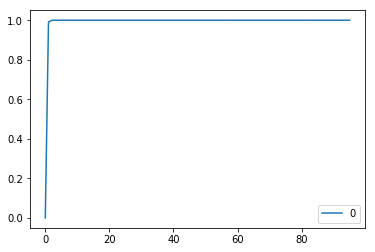

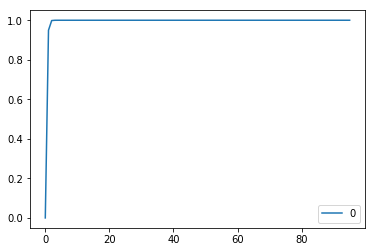

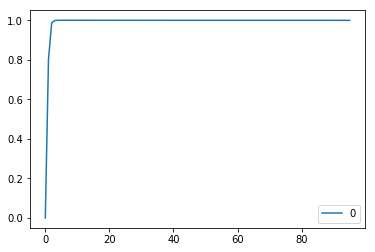

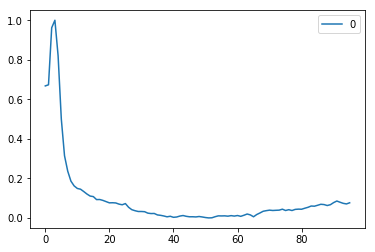

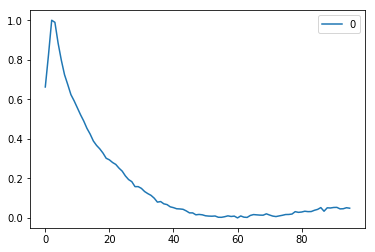

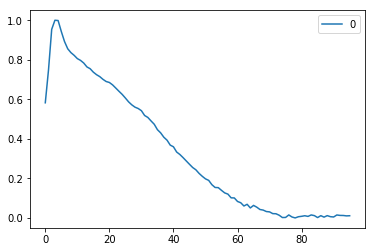

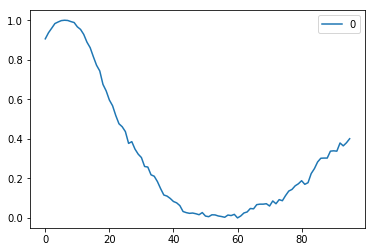

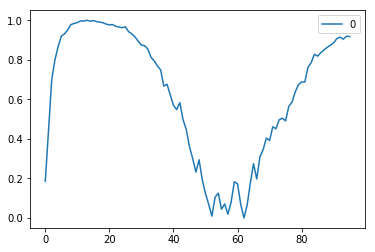

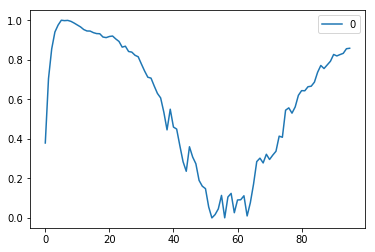

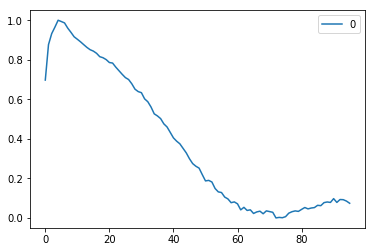

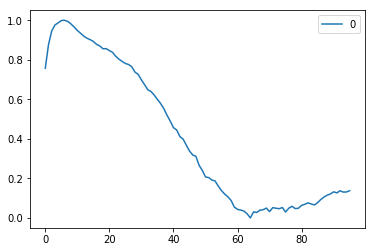

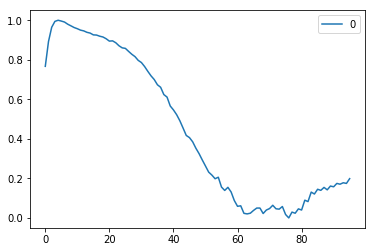

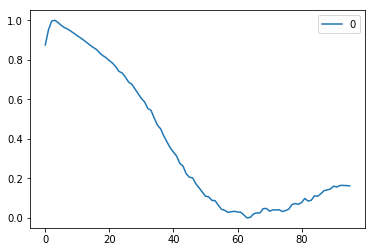

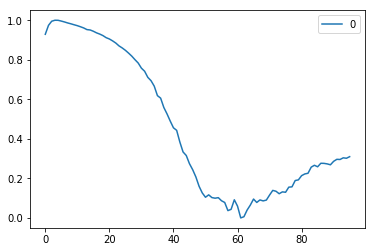

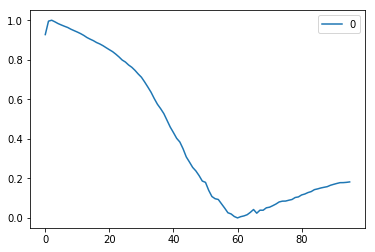

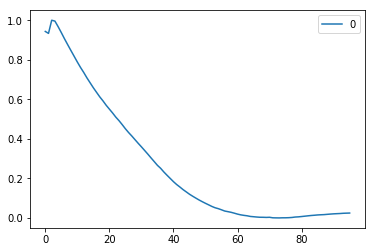

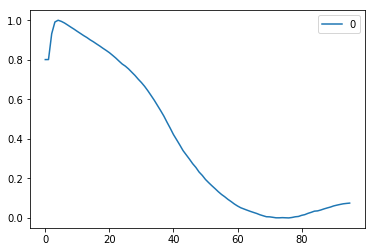

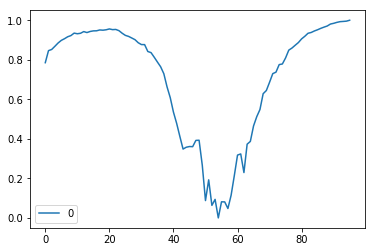

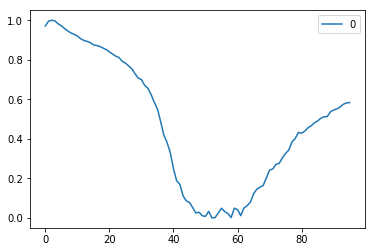

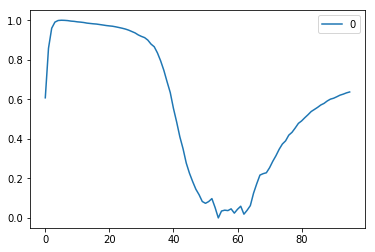

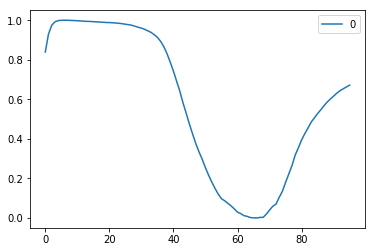

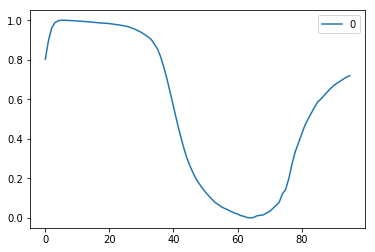

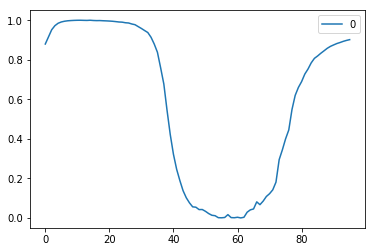

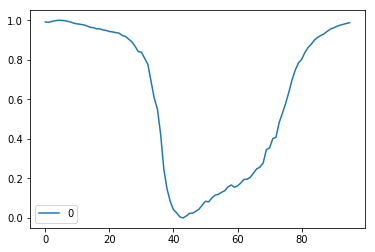

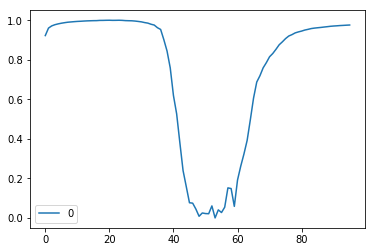

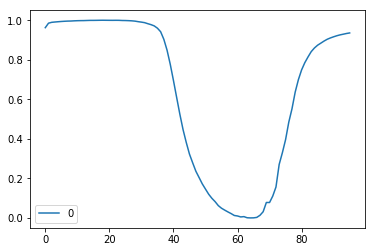

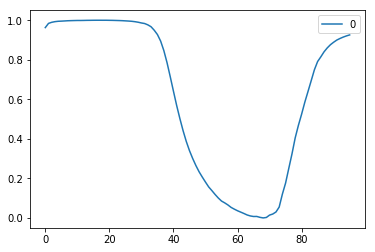

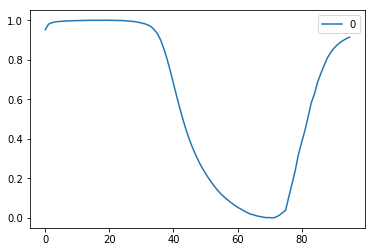

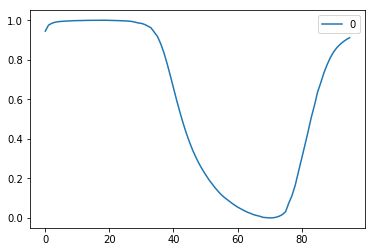

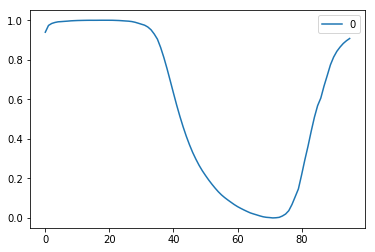

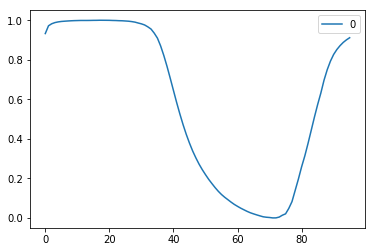

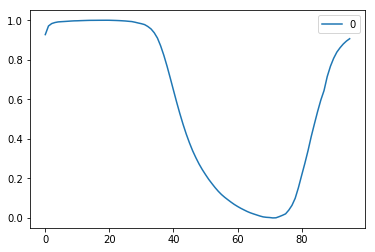

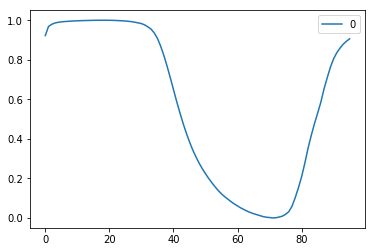

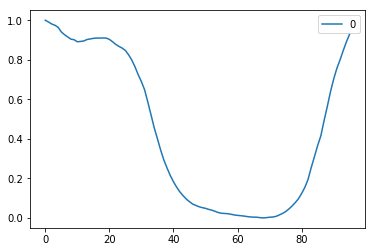

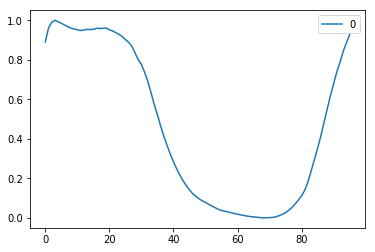

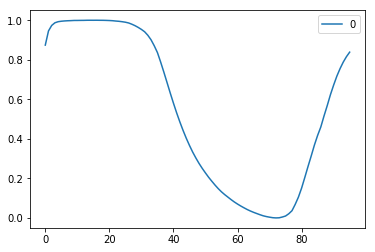

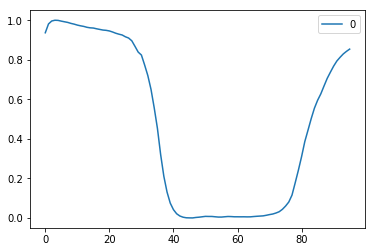

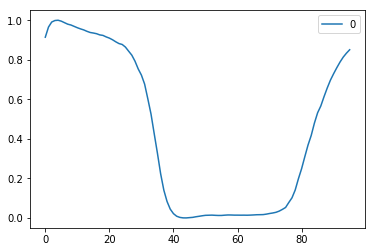

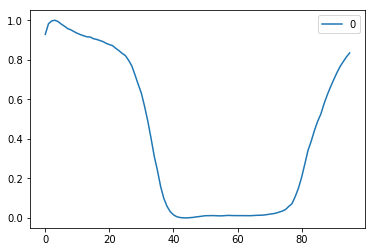

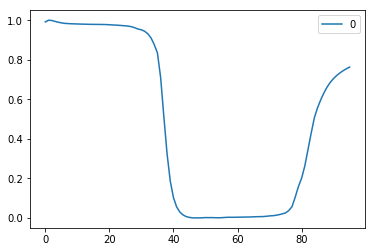

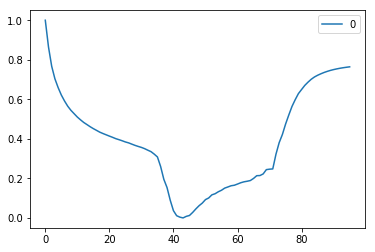

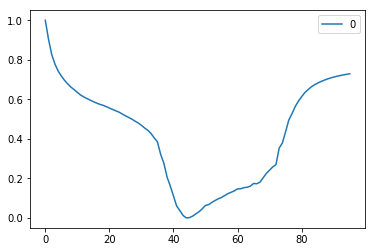

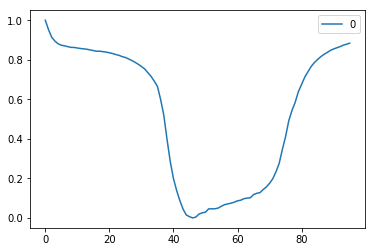

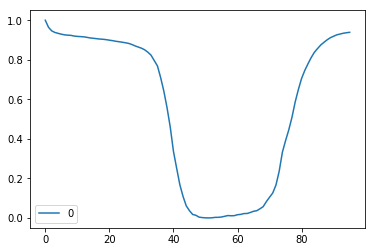

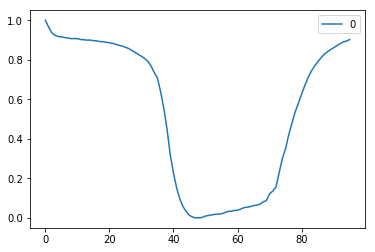

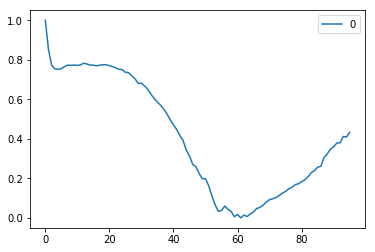

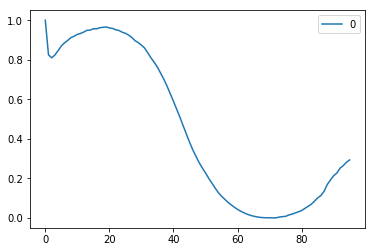

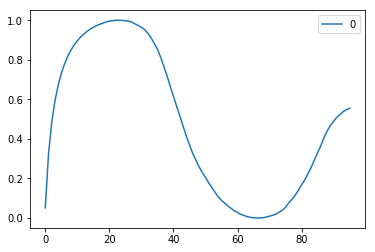

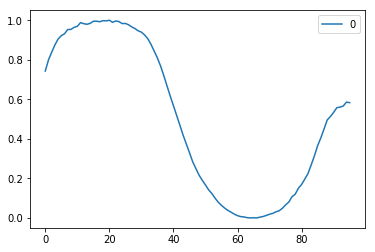

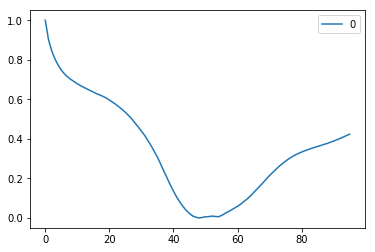

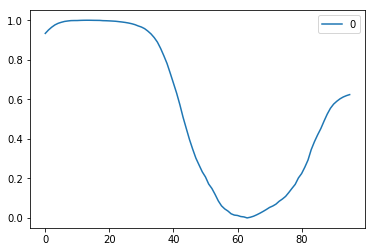

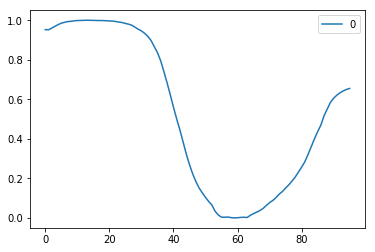

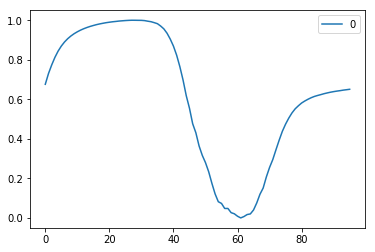

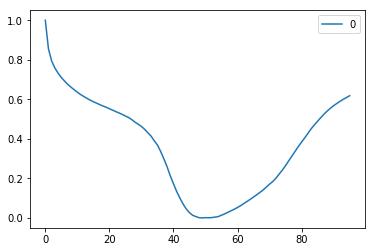

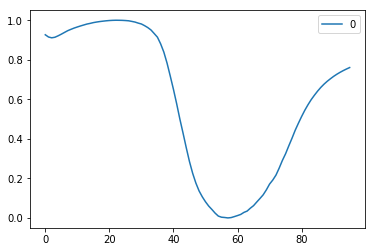

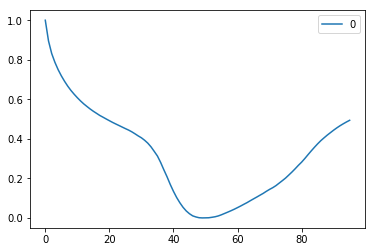

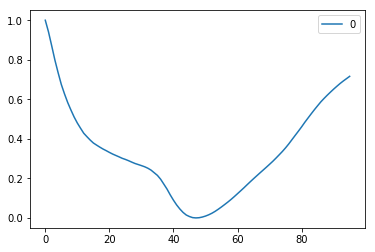

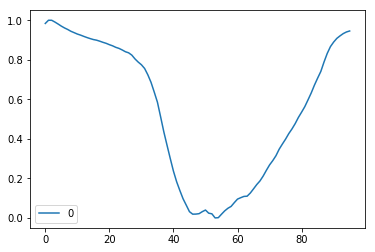

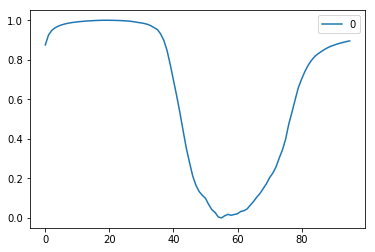

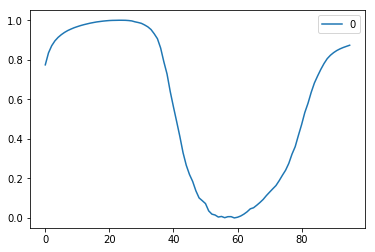

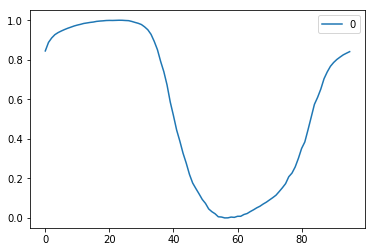

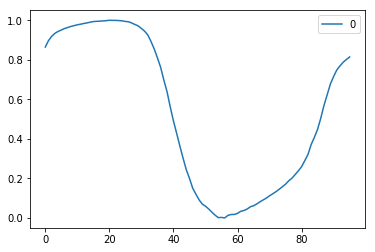

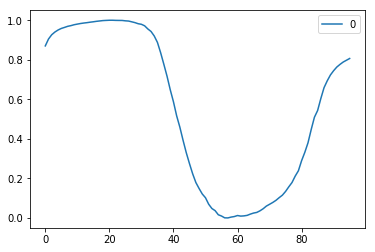

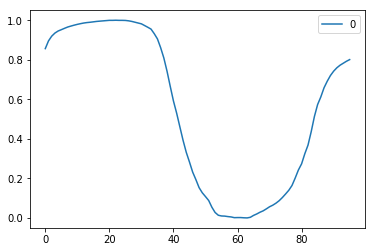

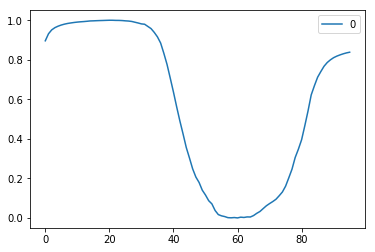

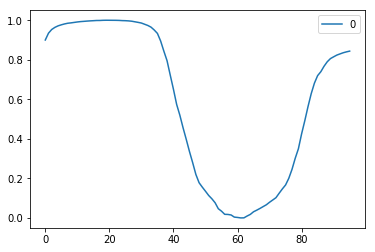

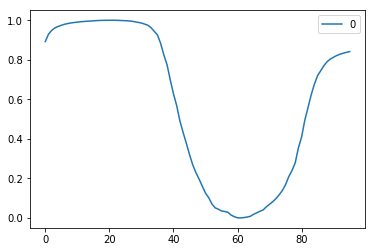

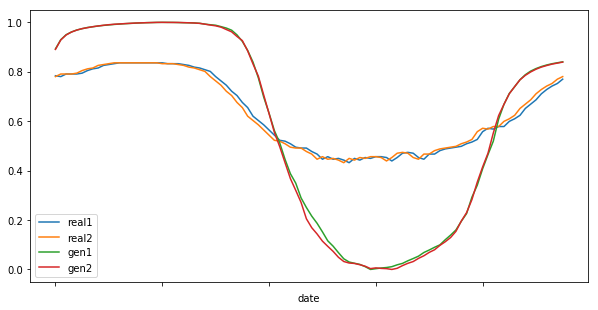

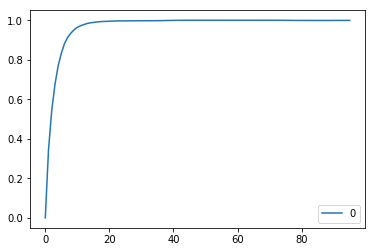

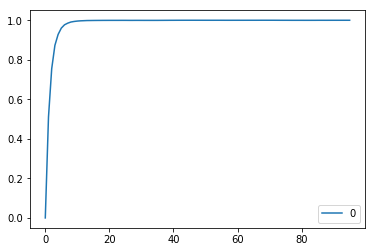

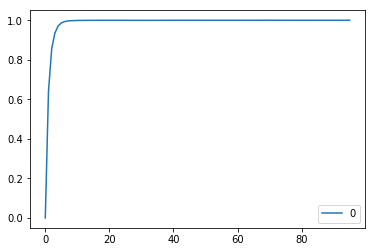

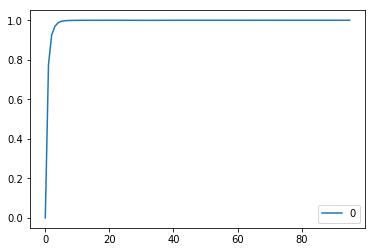

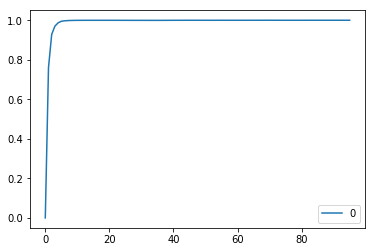

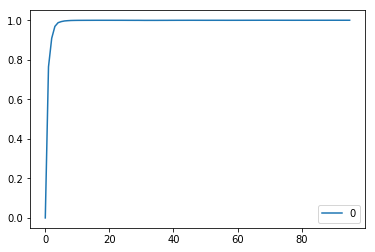

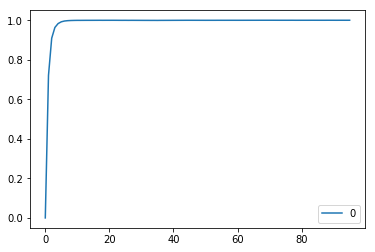

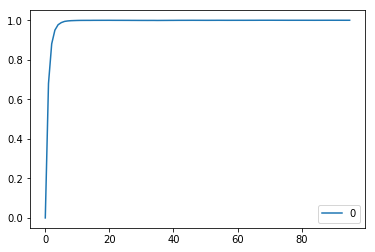

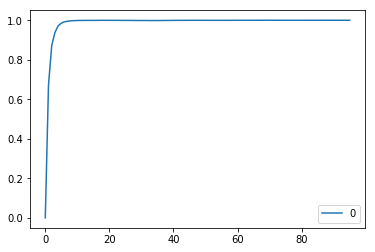

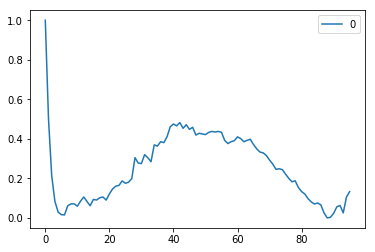

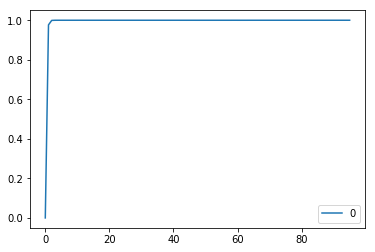

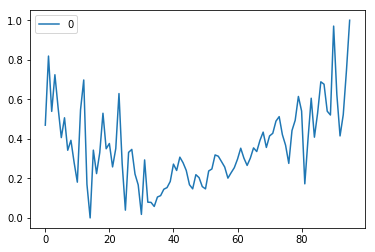

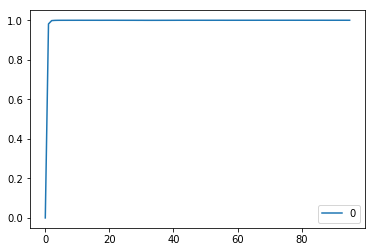

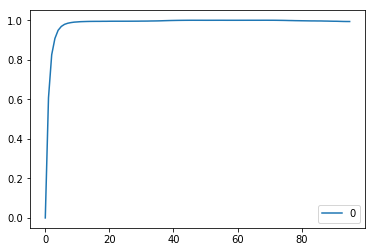

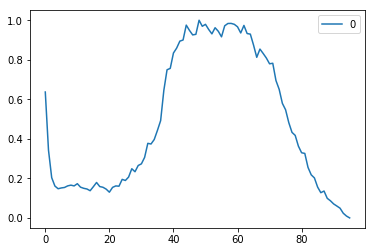

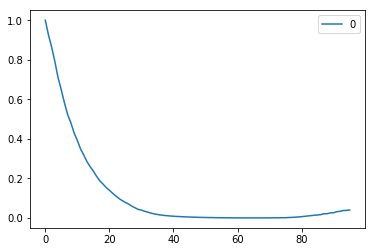

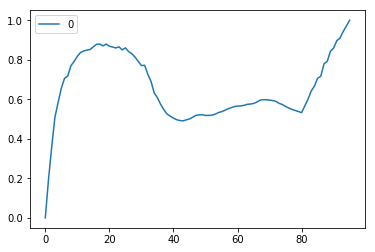

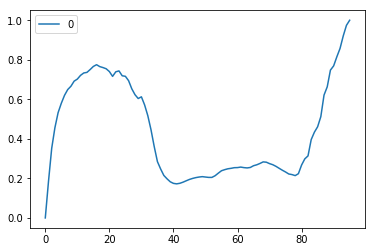

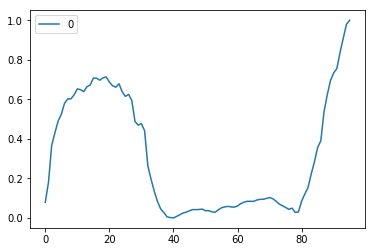

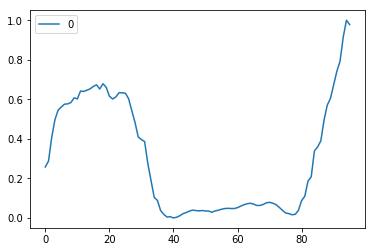

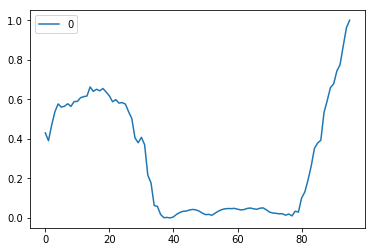

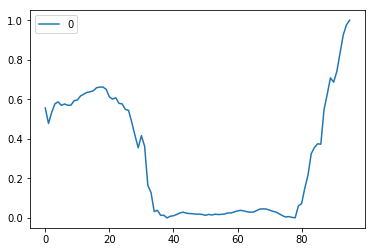

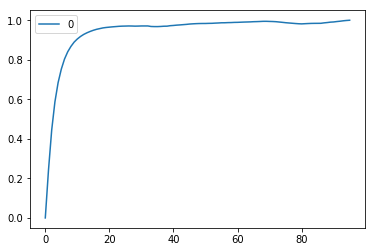

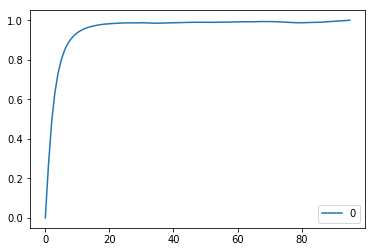

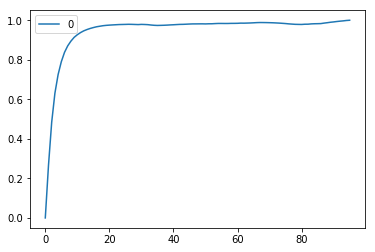

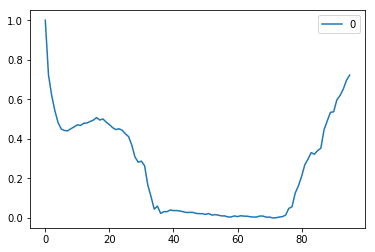

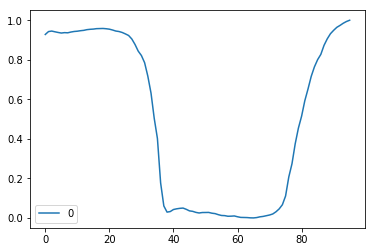

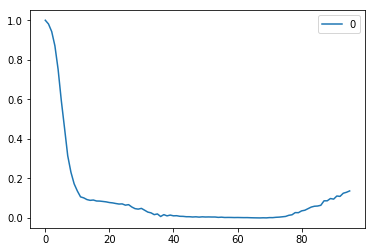

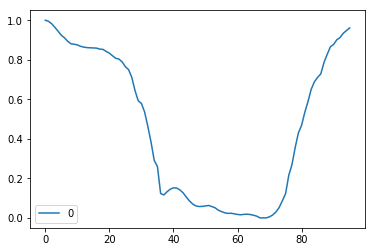

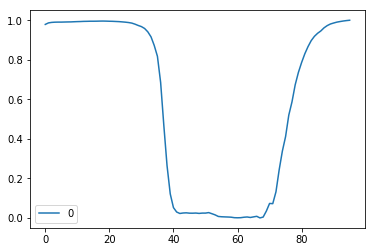

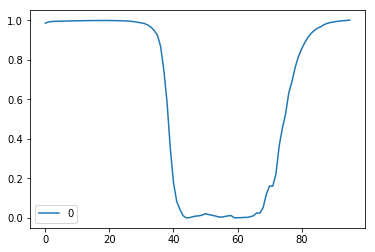

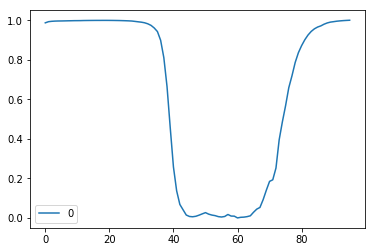

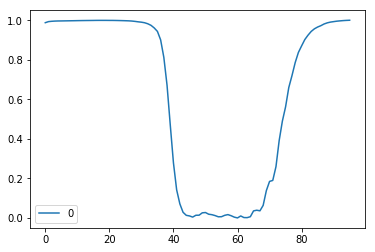

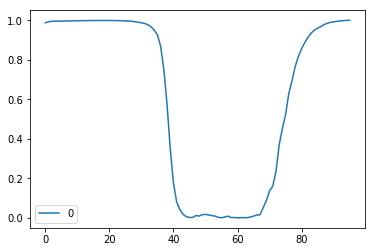

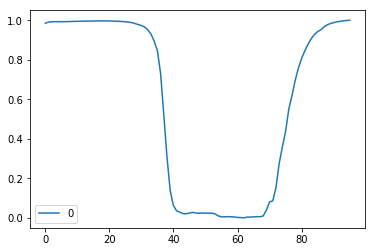

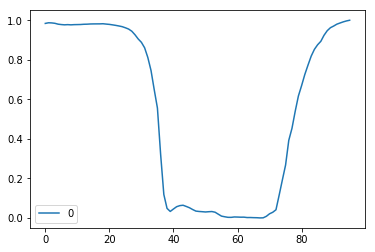

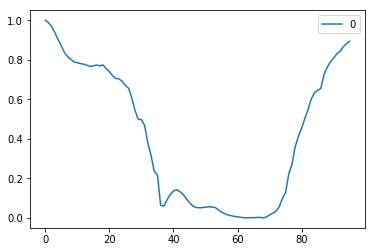

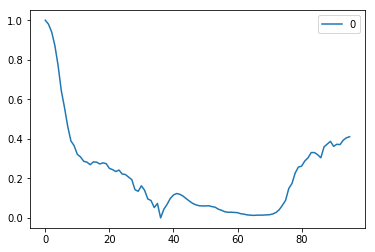

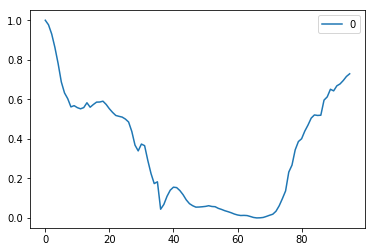

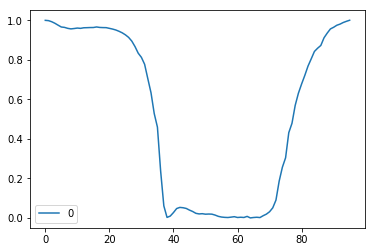

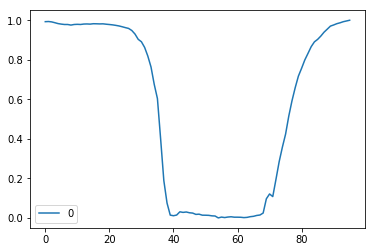

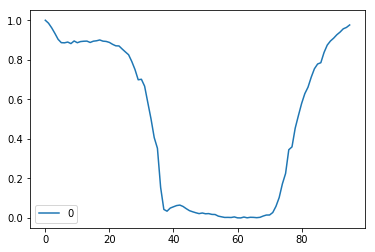

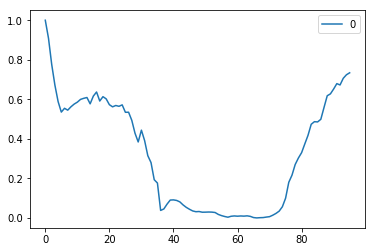

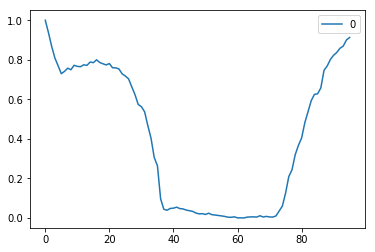

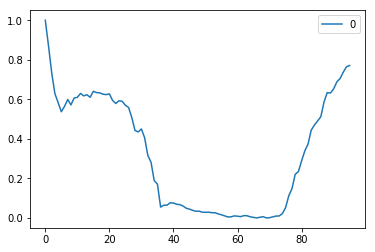

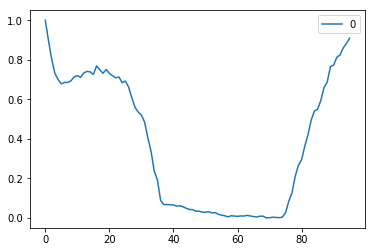

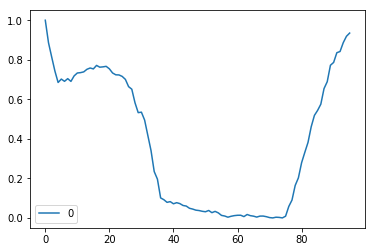

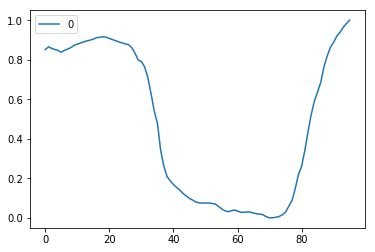

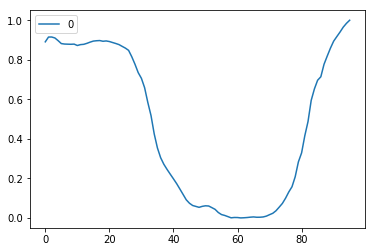

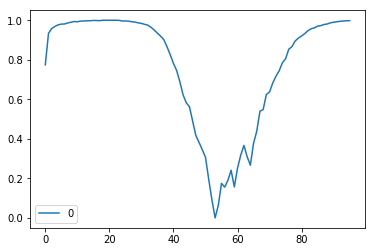

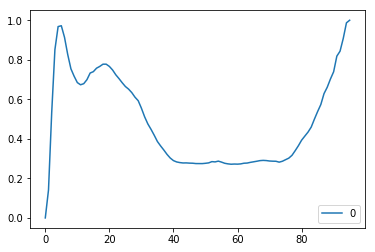

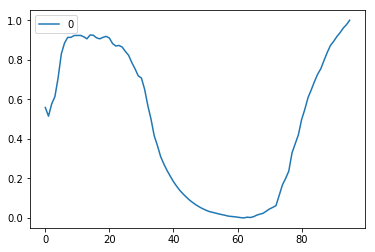

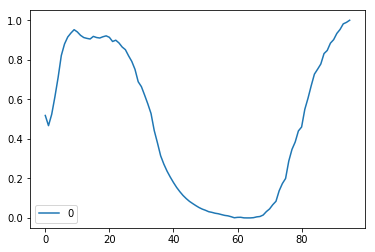

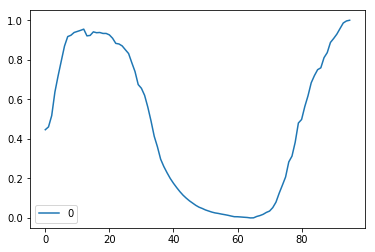

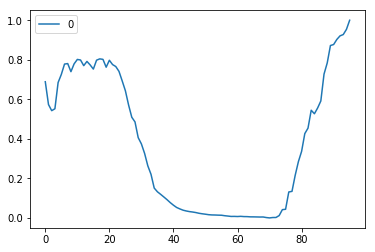

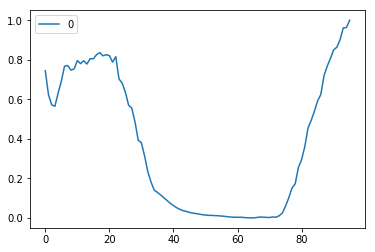

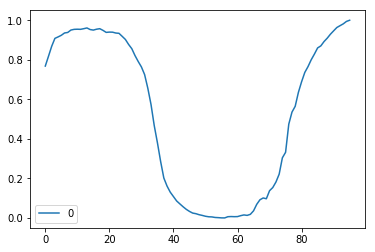

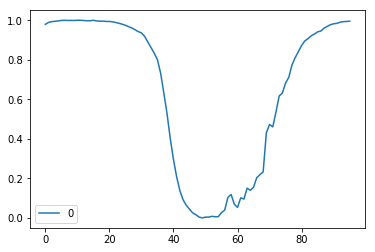

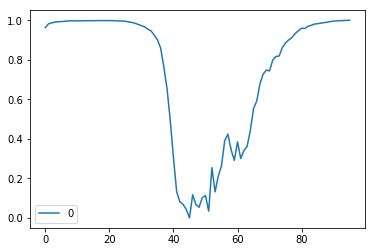

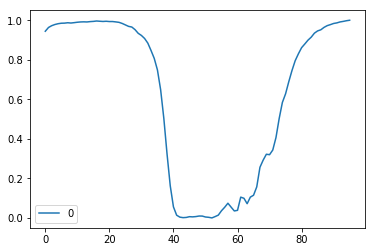

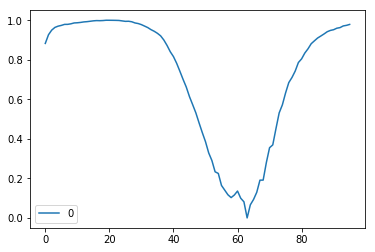

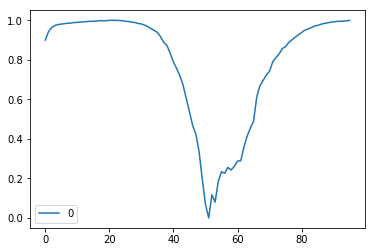

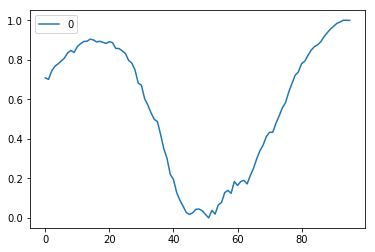

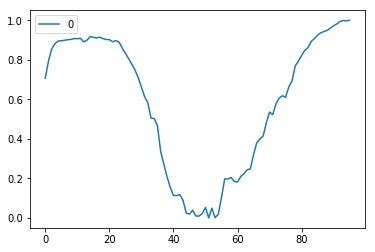

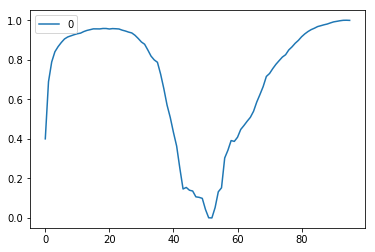

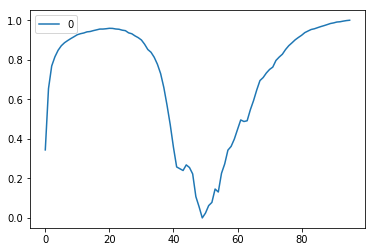

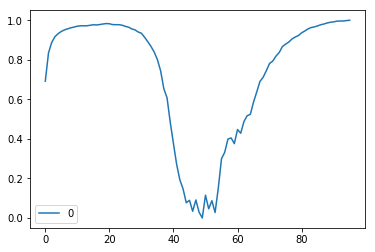

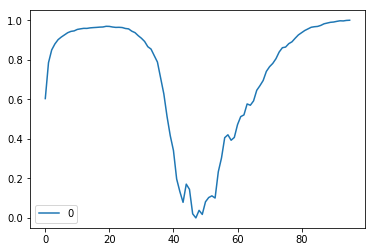

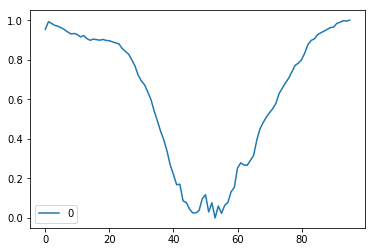

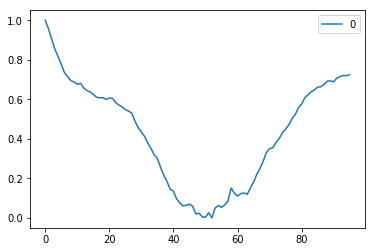

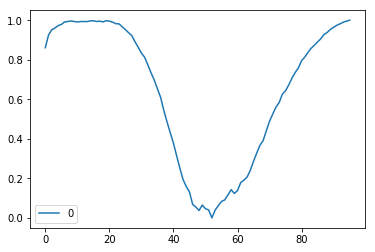

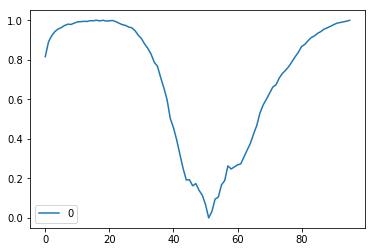

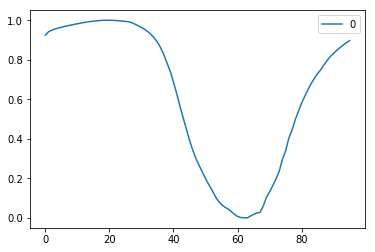

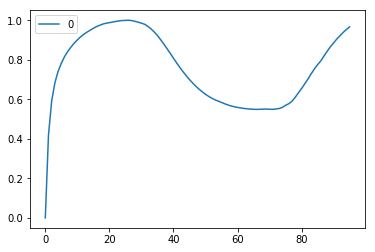

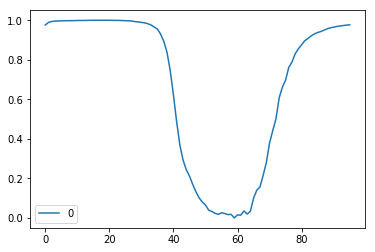

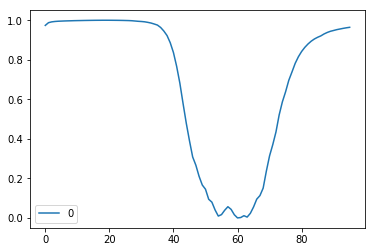

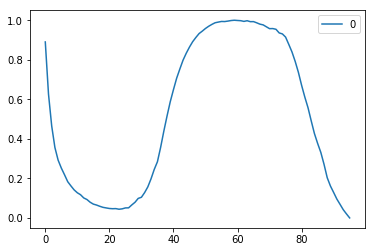

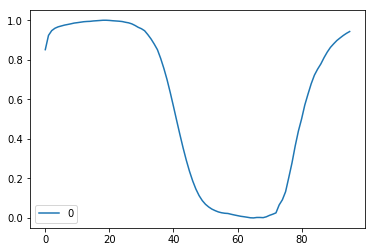

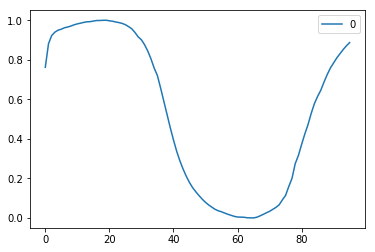

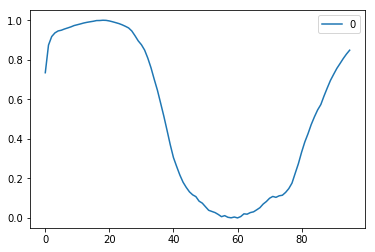

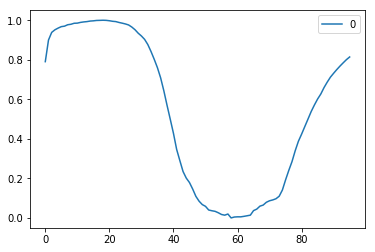

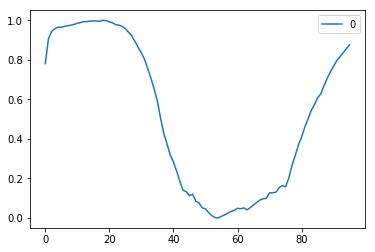

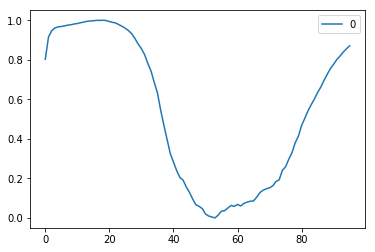

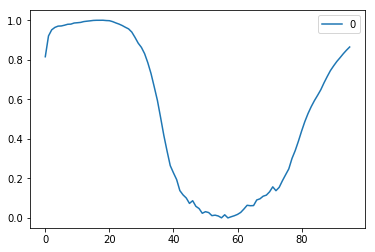

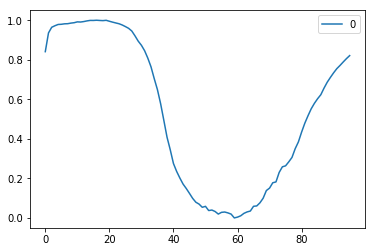

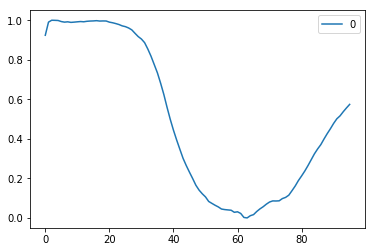

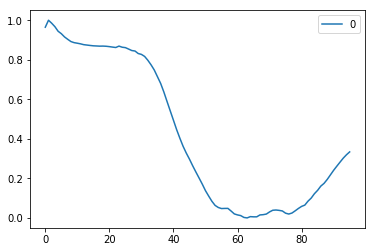

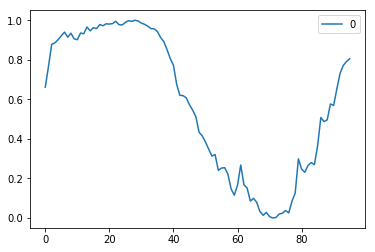

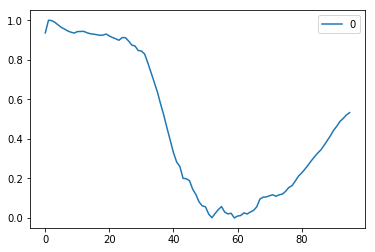

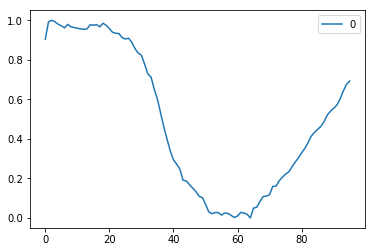

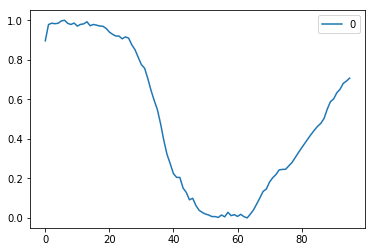

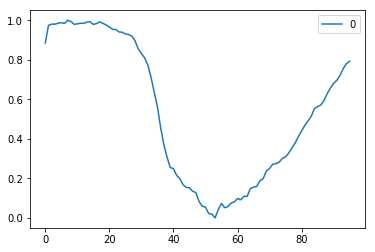

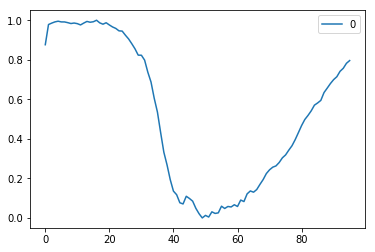

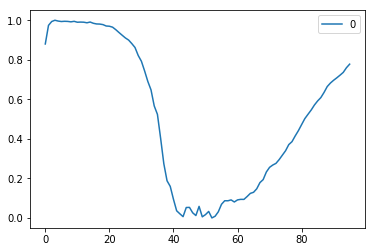

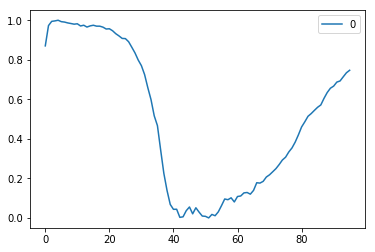

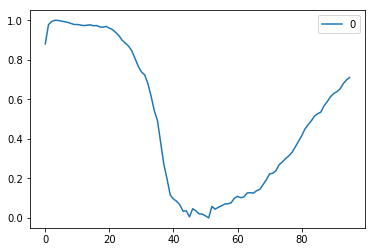

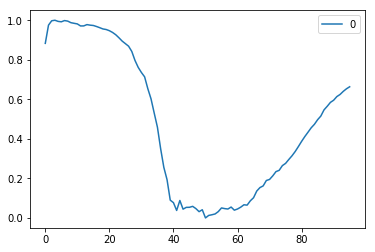

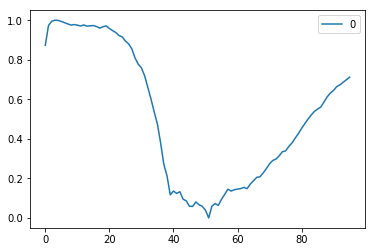

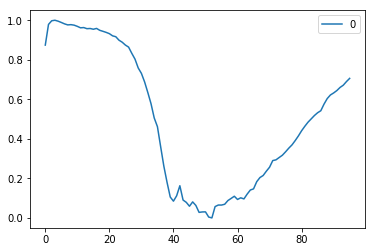

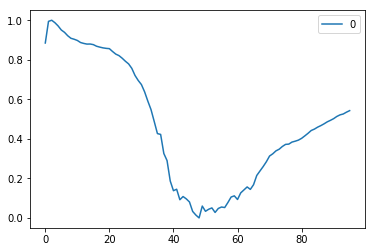

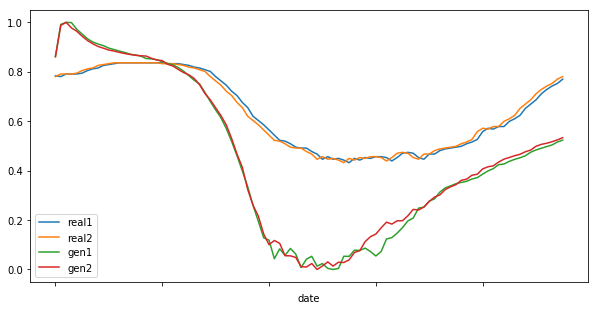

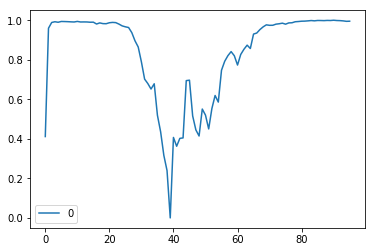

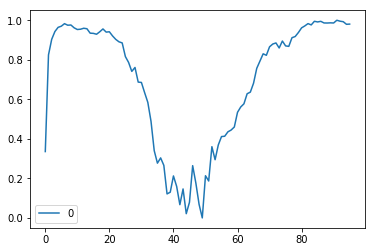

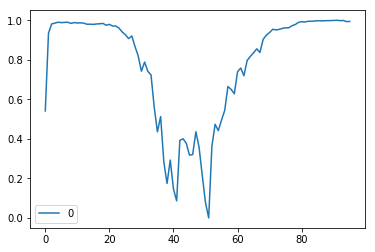

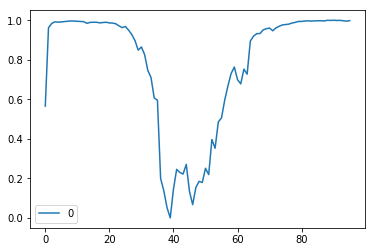

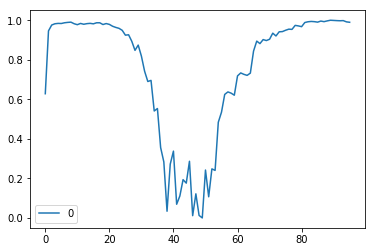

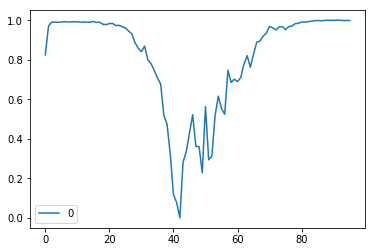

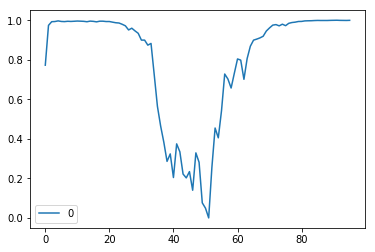

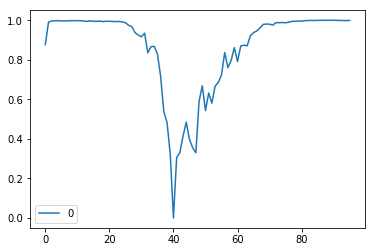

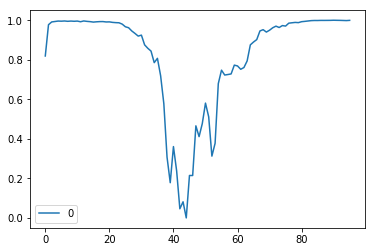

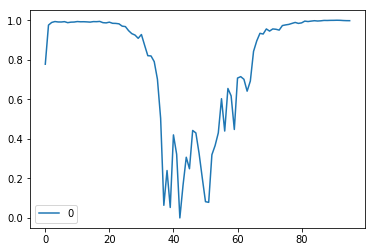

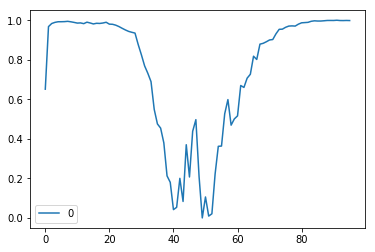

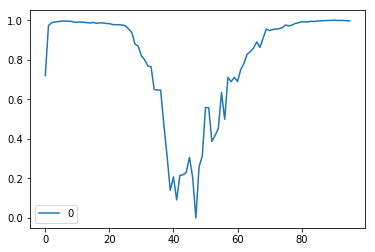

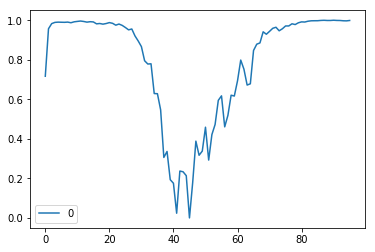

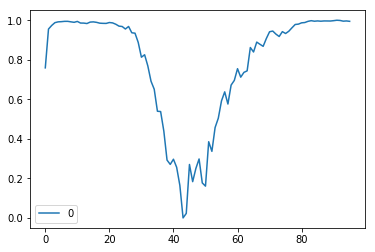

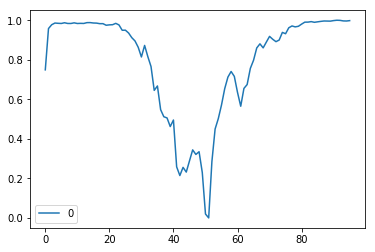

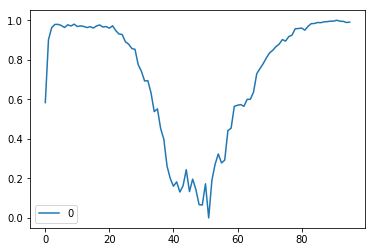

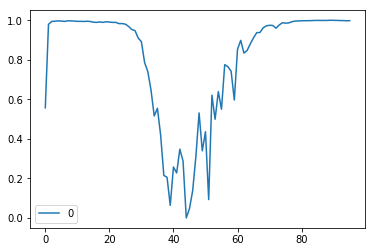

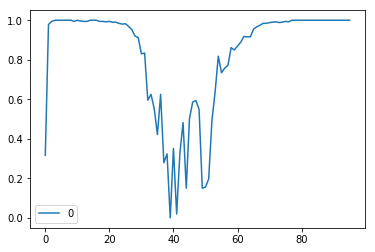

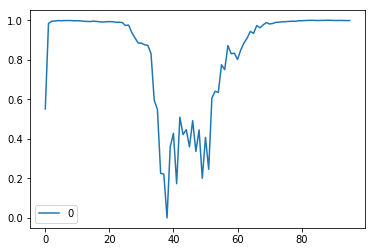

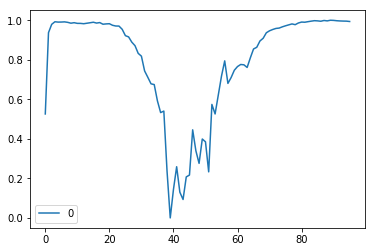

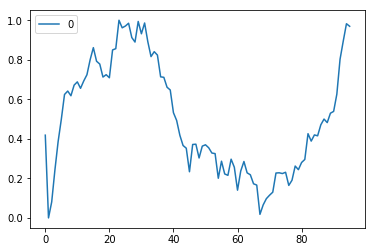

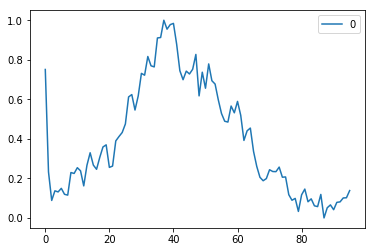

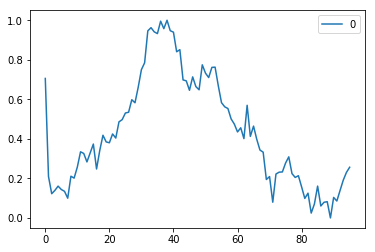

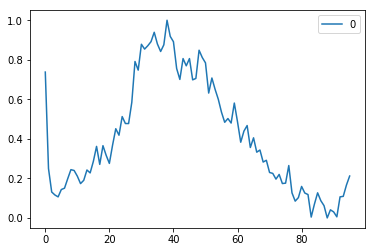

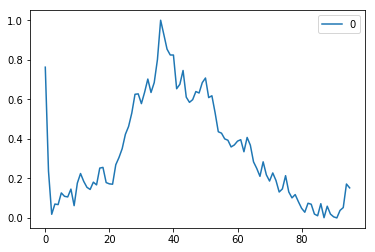

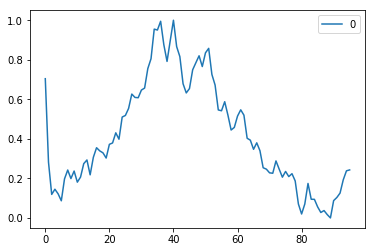

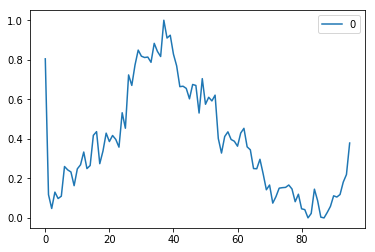

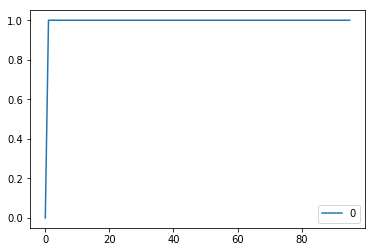

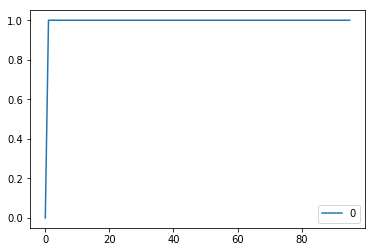

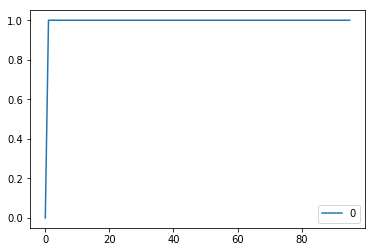

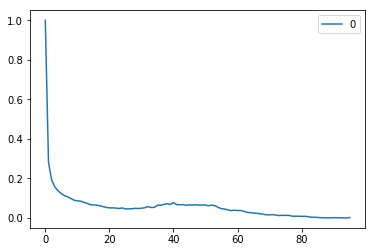

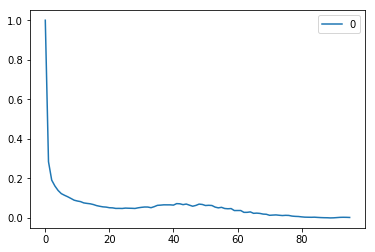

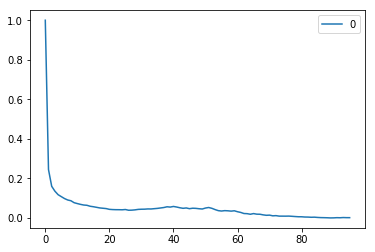

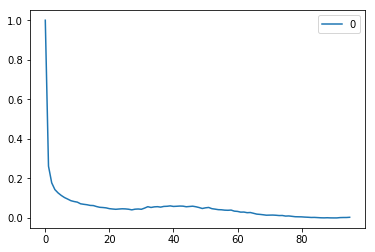

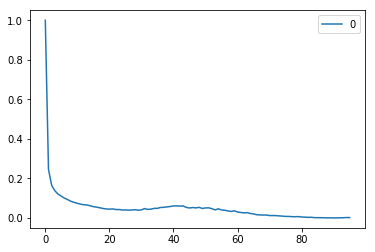

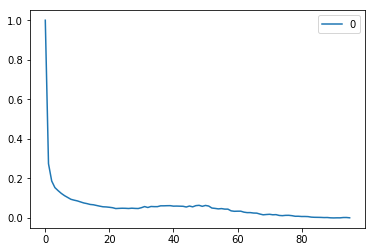

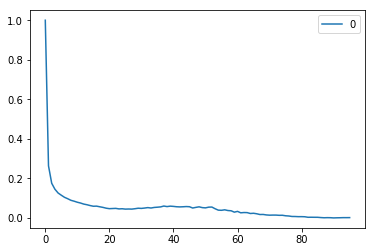

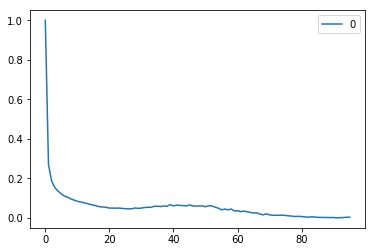

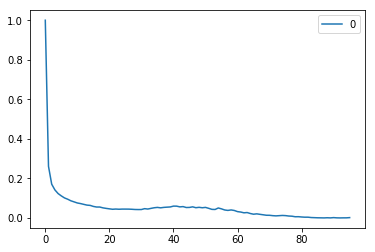

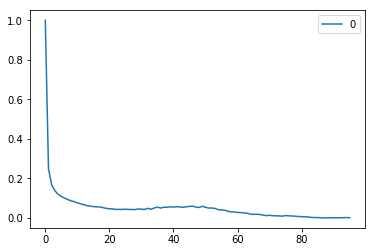

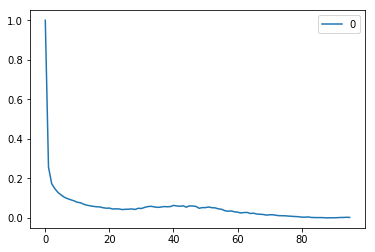

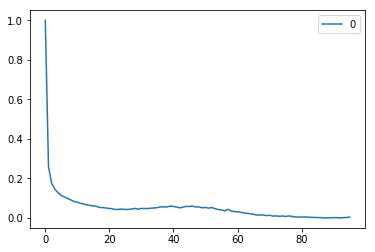

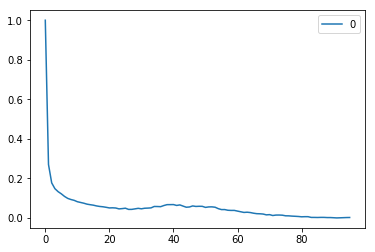

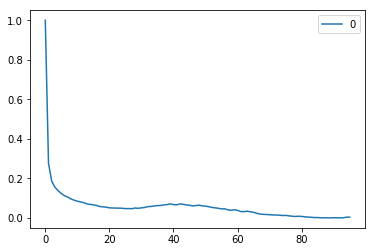

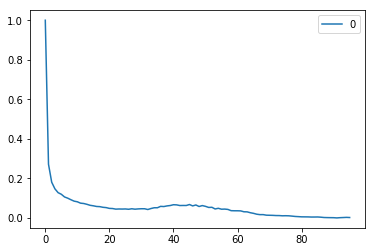

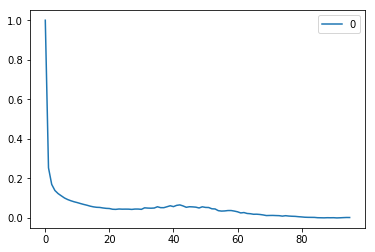

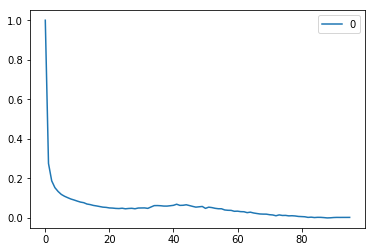

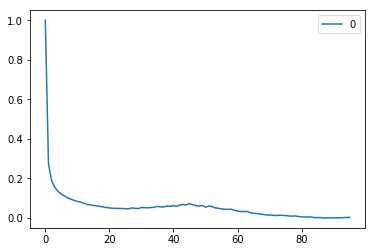

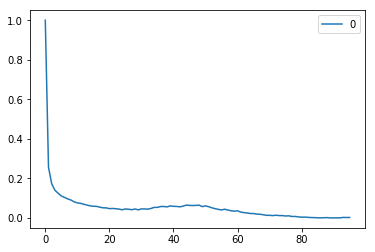

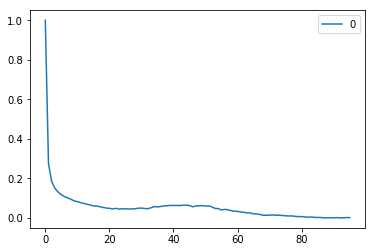

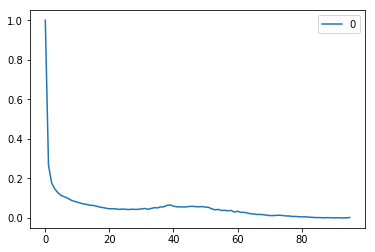

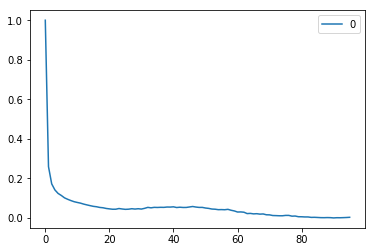

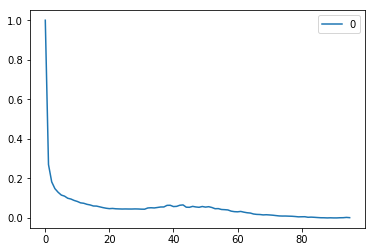

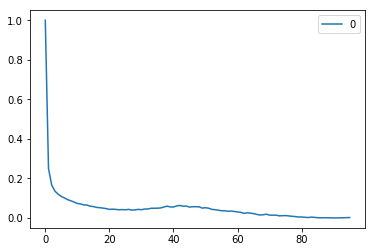

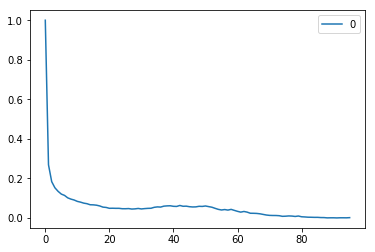

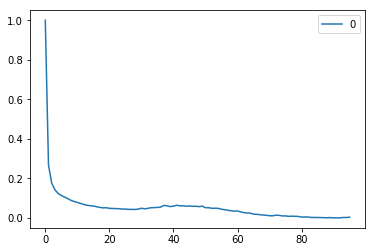

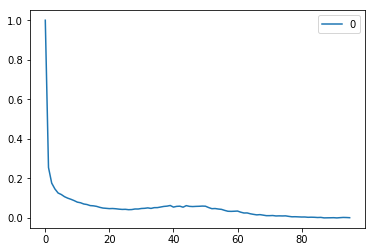

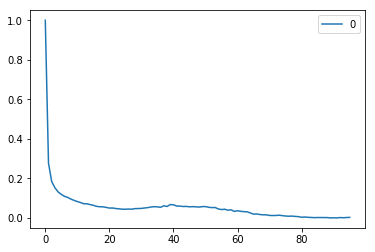

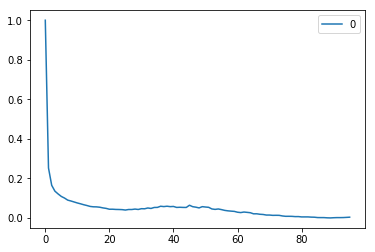

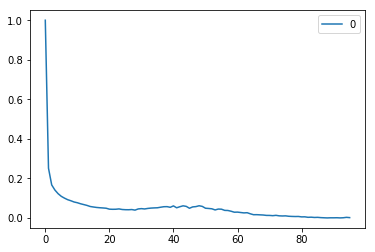

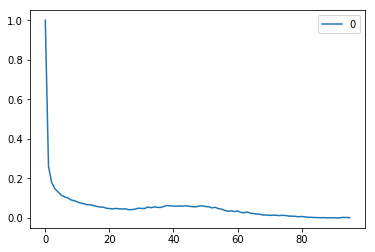

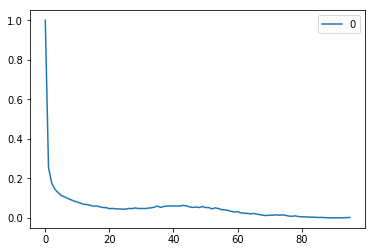

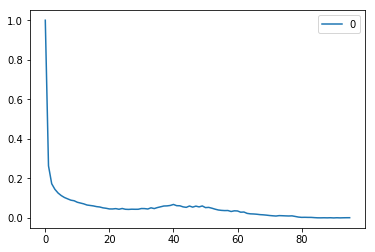

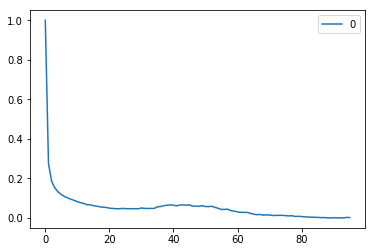

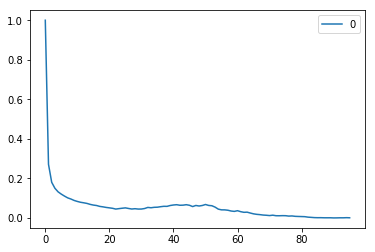

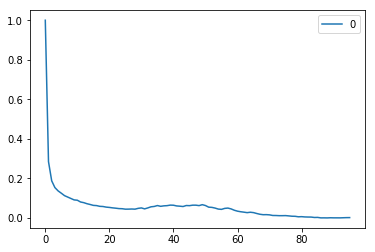

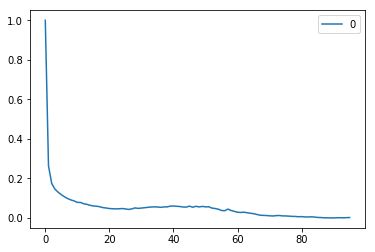

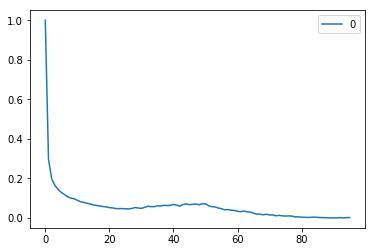

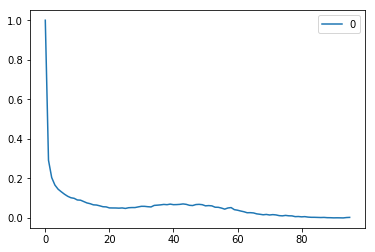

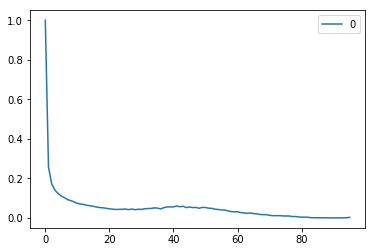

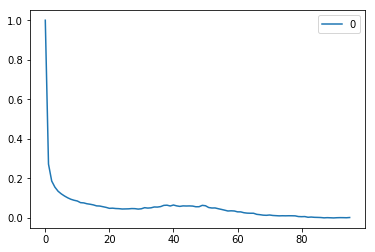

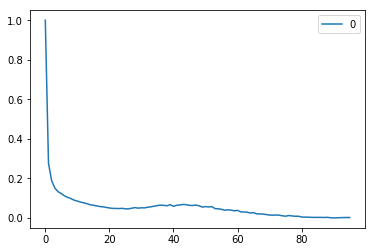

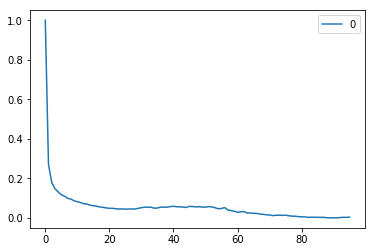

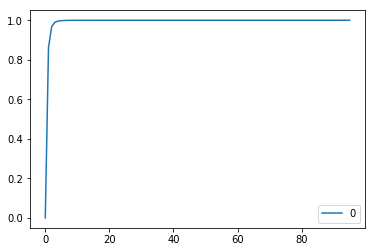

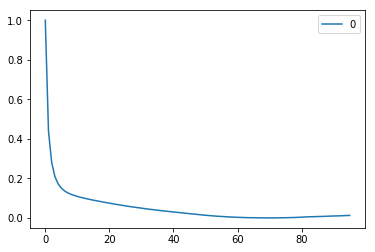

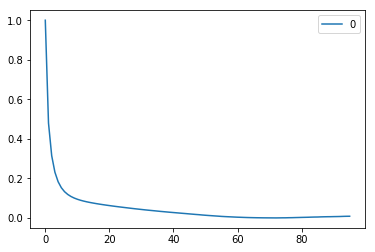

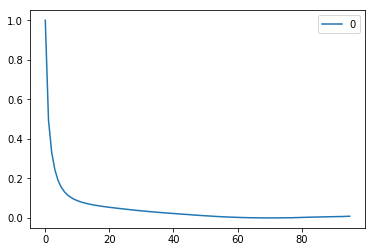

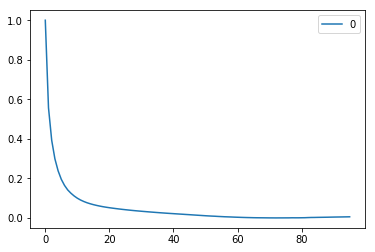

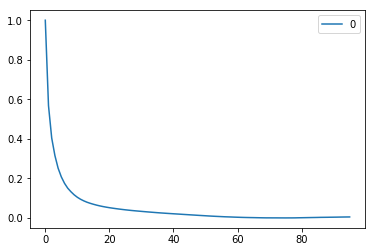

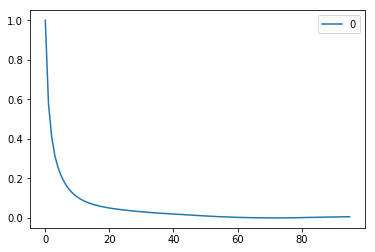

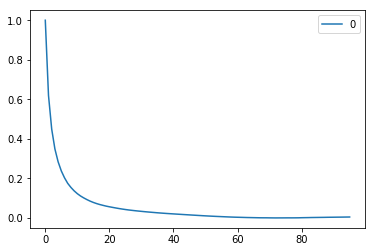

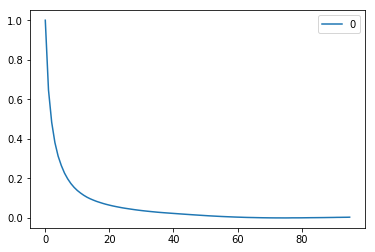

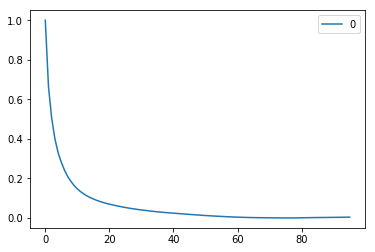

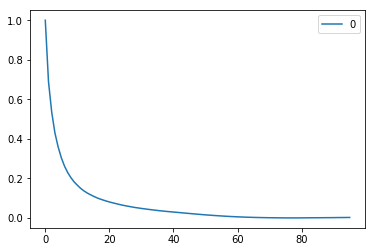

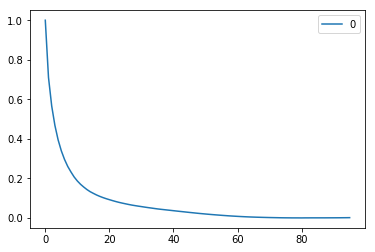

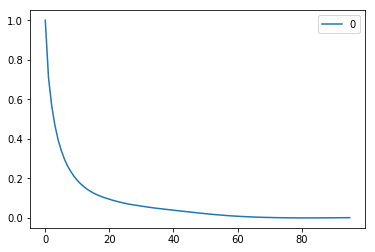

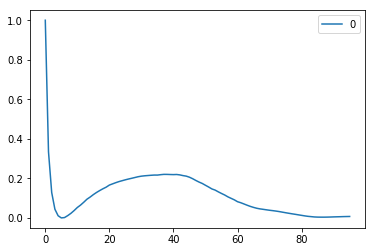

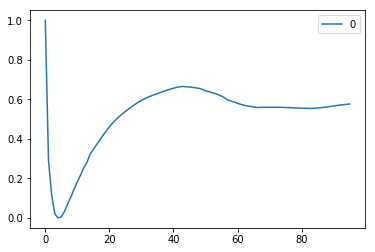

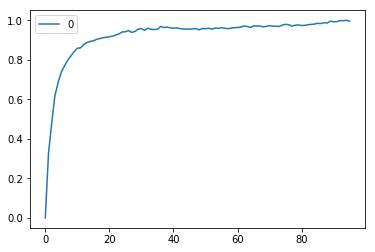

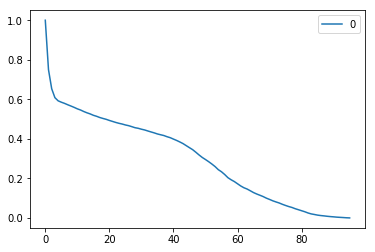

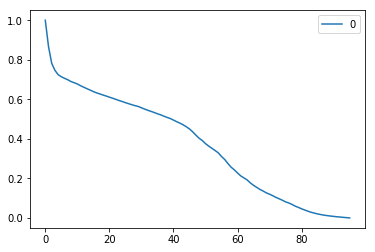

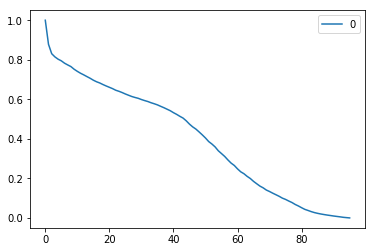

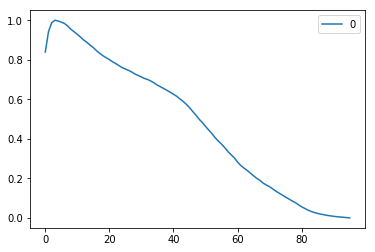

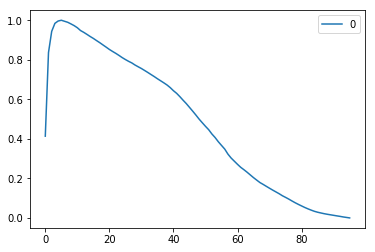

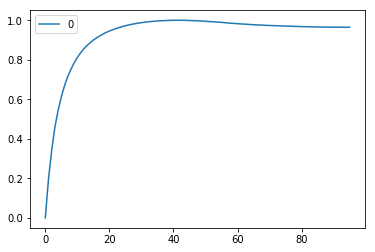

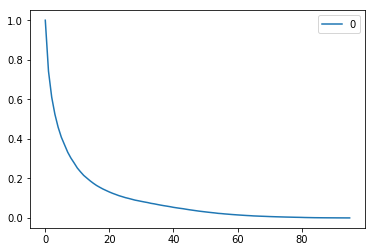

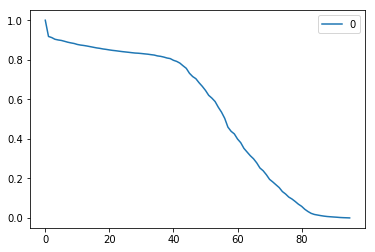

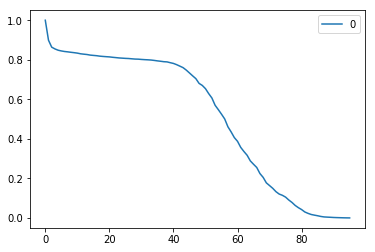

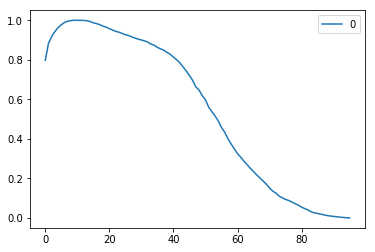

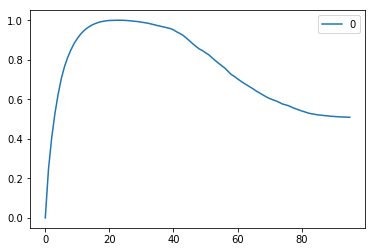

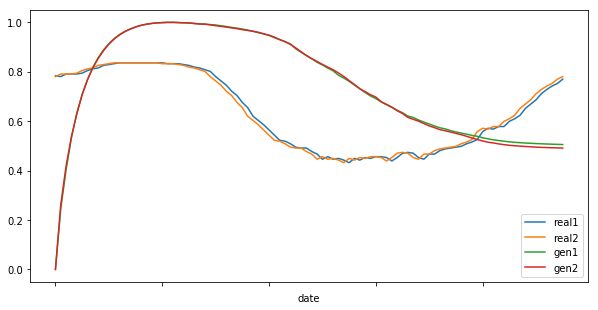

In [4]:
epochs = 300
for lr in (0.0005,0.001):
    for adm1 in (0.5): # not sensitive
        for base in (4,8):
            #for base in range(3, 8):
            for dropout in (0.3, 0.5):
                for alpha in(0.2, 0.4):
                    name=str(lr)+'_'+str(adm1)+'_'+str(base)+'_'+str(dropout)+'_'+str(alpha)
                    print(name)
                    train = Train(seqs_normal, adj, node_f, 500, key=9, 
                                  lr = lr, adam_beta_1 = adm1, base=base, dropout=dropout, alpha=alpha)
                    train(save_path='generated/'+str(epochs)+'/'+name+'_')
                    compare_plot(train, 
                                 str(lr)+'_'+str(adm1)+'_'+str(base)+'_'+str(dropout)+'_'+str(alpha),
                                 save_path='generated/'+str(epochs))

In [8]:
#train()
save_path='generated/'

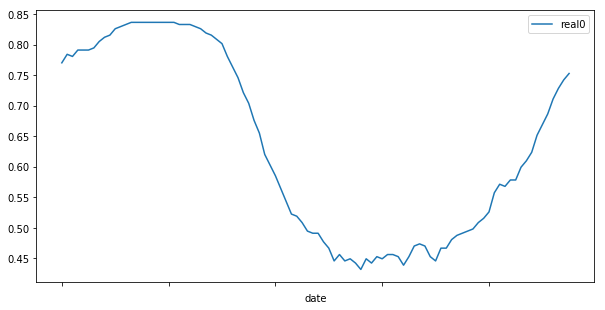

In [24]:
from matplotlib.pyplot import *
fig, ax = subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
n=1
key=9
for w in range(0,n):
    seqs_normal[w*batch_size:w*batch_size+96][key].plot(ax=ax) 
# for w in range(1,n):
#     generated_seq = train.generate()
#     generated_seq.plot(ax=ax)
ax.legend(['real'+str(w) for w in range(0,n)]);# +['gen'+str(w) for w in range(1,n)]);